# Assignment 1

# Density estimation using Real NVP

Normalizing flows is the class of probabilistic models that provides flexible parametrical probabilistic models, where the probability density function can be computed exactly. In the assignment, we will consider a real-valued non-volume preserving normalizing flows (Real NVP) -- a special case of normalizing flow.

#### Problem setting

Our goal is to train a generative network $g_\theta:  Z \rightarrow X, g = f^{-1}$ that maps latent variable $z \sim p(z)$ to a sample $x \sim p(x)$. Where $p(z)$ is a prior distibiution and $p(x)$ is a data distibution. An illustrative example is provided below.

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/2d-example.png)

#### Change of variable formula

Given an observed data variable $x \in X$,
a simple prior probability distribution $p_{Z}$ on a latent variable $z \in Z$,
and a bijection $f: X \rightarrow Z$ (with $g = f^{-1}$),
the change of variable formula defines a model distribution of $X$ by
<!-- \begin{align}
p_{X}(x) &= p_{Z}\big(f(x)\big) \left|\det\left(\cfrac{\partial f(x)}{\partial x^T} \right)\right|
\label{eq:change-variables}\\
\log\left(p_{X}(x)\right) &= \log\Big(p_{Z}\big(f(x)\big)\Big) + \log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)
,
\end{align} -->

![alt text](https://raw.githubusercontent.com/senya-ashukha/senya-ashukha.github.io/f4ed2d6ac83954b1358168dc98be3f17b6f2abbb/assignments/normalizing-flows/f.png)
where $\frac{\partial f(x)}{\partial x^T}$ is the Jacobian of $f$ at $x$.

Exact samples from the resulting distribution can be generated by using the inverse transform sampling rule. A sample $z \sim p_{Z}$ is drawn in the latent space, and its inverse image $x = f^{-1}(z) = g(z)$ generates a sample in the original space. Computing the density at a point $x$ is accomplished by computing the density of its image $f(x)$ and multiplying by the associated Jacobian determinant $\det\left(\frac{\partial f(x)}{\partial x^T}\right)$.

#### Real NVP

Real NVP presents a class of functions where $\log\left(\left|\det\left(\frac{\partial f(x)}{\partial x^T}\right)\right|\right)$ can be computed efficiently (see, 3.3 Properties, https://arxiv.org/abs/1605.08803). Every layer of Real NVP is a coupling layer followed by permutation layer. Combination of coupling and permutation layers can be implemented as a masked version of the coupling layer:
## $$y = b \odot x + (1 - b) \odot \Big(x \odot \exp\big(s(b \odot x)\big) + t(b \odot x)\Big)$$

where $s$ and $t$ stand for scale and translation, and are functions from $R^{D} \mapsto R^{D}$, and $\odot$ is the Hadamard product or element-wise product, $b$ is a binary mask. For more details on the model see the paper Density estimation using Real NVP https://arxiv.org/abs/1605.08803.

# In this assignment:
1. Implementation of Real NVP
2. Training Real NVP on moons dataset
3. Visualization of the generative model
4. Optional Research Assignment

Additional information:
- You will need the following python packages: PyTorch, Numpy, sklearn, matplotlib.
- If you have an urgent question or find a typo or a mistake, send it to ars.ashuha@gmail.com. The title should include "BDL Assignment 2 2018".
- A submission policy will be released later.

# Implementation of Real NVP

In [34]:
import torch
from torch import nn
from torch.nn.parameter import Parameter

In [35]:
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()
        
        # Create a flow
        # nets:  a function that returns a PyTorch neural network, e.g., nn.Sequential, s = nets(), s: dim(X) -> dim(X)
        # nett:  a function that returns a PyTorch neural network, e.g., nn.Sequential, t = nett(), t: dim(X) -> dim(X)
        # mask:  a torch.Tensor of size #number_of_coupling_layers x #dim(X)
        # prior: an object from torch.distributions e.g., torch.distributions.MultivariateNormal
        
        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])
        
    def g(self, z):
        # Compute and return g(z) = x, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # z: a torch.Tensor of shape batchSize x 1 x dim(X)
        # return x: a torch.Tensor of shape batchSize x 1 x dim(X)
        x = z
        reversed_idxs = reversed(range(len(self.mask)))
        for idx in reversed_idxs:
            x_masked = x * self.mask[idx]
            x = x_masked + (1 - self.mask[idx]) * (x - self.t[idx](x_masked)) * torch.exp(-self.s[idx](x_masked))
        return x

    def f(self, x):
        # Compute f(x) = z and log_det_Jakobian of f, 
        #    where self.mask[i], self.t[i], self.s[i] define a i-th masked coupling layer   
        # x: a torch.Tensor, of shape batchSize x dim(X), is a datapoint
        # return z: a torch.Tensor of shape batchSize x dim(X), a hidden representations
        # return log_det_J: a torch.Tensor of len batchSize
        z = x
        log_det_J = torch.zeros(list(x.size())[0])
        for idx in range(len(self.mask)):
            z_masked = z * self.mask[idx]
            s_out = self.s[idx](z_masked)
            z = z_masked + (1 - self.mask[idx]) * (z * torch.exp(s_out) + self.t[idx](z_masked))
            log_det_J += torch.sum(s_out * (1 - self.mask[idx]), dim=1)
        
        return z, log_det_J
    
    def log_prob(self, x):
        # Compute and return log p(x)
        # using the change of variable formula and log_det_J computed by f
        # return logp: torch.Tensor of len batchSize
        z, log_det_J = self.f(x)
        logp = self.prior.log_prob(z) + log_det_J
        return logp
        
    def sample(self, batchSize): 
        # Draw and return batchSize samples from flow using implementation of g
        # return x: torch.Tensor of shape batchSize x 1 x dim(X)
        z = self.prior.sample((batchSize, 1))
        x = self.g(z)
        return x

Functions for creating models:

In [59]:
def init_uniform(layer):
    if type(layer) == torch.nn.Linear:
        torch.nn.init.uniform_(layer.weight)

def init_normal(layer):
    if type(layer) == torch.nn.Linear:
        torch.nn.init.normal_(layer.weight)

def init_kaiming_uniform(layer):
    if type(layer) == torch.nn.Linear:
        torch.nn.init.kaiming_uniform_(layer.weight)

def init_kaiming_normal(layer):
    if type(layer) == torch.nn.Linear:
        torch.nn.init.kaiming_normal_(layer.weight)
        layer.bias.data.fill_(0)

def init_xavier_uniform(layer):
    if type(layer) == torch.nn.Linear:
        torch.nn.init.xavier_uniform_(layer.weight)

def init_xavier_normal(layer):
    if type(layer) == torch.nn.Linear:
        torch.nn.init.xavier_normal_(layer.weight)

Сonsider a simple fully connected architecture with consecutive linear layers of the same size as a model for experiments.

In [37]:
x_dim = 2
hidden_dim = 128
n_layers = 5

def create_model(
    n_layers=n_layers,
    x_dim=x_dim,
    hidden_dim=hidden_dim,
    nonlinearity=nn.ReLU,
    initialization=None
):
    model = torch.nn.Sequential()
    model.add_module('Input', torch.nn.Linear(x_dim, hidden_dim))
    model.add_module('NonlinearityIn', nonlinearity())
    for idx in range(n_layers):
        model.add_module('Linear' + str(idx + 1), torch.nn.Linear(hidden_dim, hidden_dim))
        model.add_module('Nonlinearity' + str(idx + 1), nonlinearity())
    model.add_module('Output', torch.nn.Linear(hidden_dim, x_dim))
    model.add_module('Tanh', torch.nn.Tanh())
    if initialization is not None:
        model.apply(initialization)
    return model

In [38]:
nets = lambda: create_model(n_layers, x_dim, hidden_dim, torch.nn.ReLU, None)
nett = lambda: create_model(n_layers, x_dim, hidden_dim, torch.nn.ReLU, None)

nets_test = nets()
nett_test = nett()
x_test = torch.zeros((1, x_dim))

assert nets_test(x_test).shape == torch.Size([1, x_dim])
assert nett_test(x_test).shape == torch.Size([1, x_dim])

# Check nets and nett are working i.e., computing without errors
# Check that resulting dimensions s and t are the same and equal dim(X)
# ❗️ Very important to make outputs of nets bounded due to exp (e.g. use nn.Tanh() as the last layer)
# ❗️ Don't be afraid to go too large, 3-4 not very small linear layers should work fine
# ❗️ Init of parameters matters, try different ones

In [39]:
import numpy as np

#The transformations in Real NVP seem quite simple, let's take the larger number of them for better quality
number_of_coupling_layers = 50

#Since the dimension of the objects is only two, let's set the mask so that the positions of the ones in them are staggered, 
#for alternating transformation of the two coordinates of the vectors
masks = torch.from_numpy(np.tile([[1, 0], [0, 1]], [int(number_of_coupling_layers / 2), 1]))
# number_of_coupling_layers like 6+ should works fine
# Check that when dim(X) == 2, the mask for every layer has just one 1.0 and one 0.0 elements.

#This property will be fulfilled due to the way we have set the masks manually:
assert ((masks == 0) | (masks == 1)).all()
assert torch.all(torch.sum(masks, dim=1) == 1)

In [40]:
from torch import distributions
prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))
# Check that prior has log_prob and sample methods
print(prior.log_prob(x_test))
print(prior.sample((1,)))


tensor([-1.8379])
tensor([[ 0.5277, -1.2549]])


In [41]:
flow = RealNVP(nets, nett, masks, prior)
# Check that a flow is reversible g(f(x)) = x
# With a big chance you have some errors in RealNVP.log_prob, think hard on it.
x_t = torch.Tensor([[0.7, 0.3]])
print(f'x: {x_t}')
print(f'g(f(x)): {flow.g(flow.f(x_t)[0])}')

x: tensor([[0.7000, 0.3000]])
g(f(x)): tensor([[0.7000, 0.3000]], grad_fn=<AddBackward0>)


In [ ]:
from sklearn import datasets

trainable_parameters = list(flow.s.parameters()) + list(flow.t.parameters())
optimizer = torch.optim.Adam(trainable_parameters, lr=1e-4)

for t in range(5001):    
    noisy_moons = datasets.make_moons(n_samples=100, noise=.05)
    loss = -torch.mean(flow.log_prob(torch.from_numpy(noisy_moons[0]).float()))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if t % 500 == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
# Check that the loss decreases
# Is the visualization below good?

iter 0: loss = 2.838
iter 500: loss = 0.507
iter 1000: loss = 0.381
iter 1500: loss = 0.426
iter 2000: loss = 0.455
iter 2500: loss = 0.366
iter 3000: loss = 0.475
iter 3500: loss = 0.362
iter 4000: loss = 0.302
iter 4500: loss = 0.313
iter 5000: loss = 0.328


The values of the loss are decreasing, but not quite stable, and slow enough, it depends a lot on the learning rate value.

# Visualization

In [42]:
from sklearn import datasets
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

noisy_moons = datasets.make_moons(n_samples=100, noise=.05)

Draw several plots: 
- samples from flow
- samples from prior
- data samples
- mapping form data to prior

The goal is to obtain figure similar to https://arxiv.org/abs/1605.08803

Text(0.5, 1.0, '$X = g(z)$')

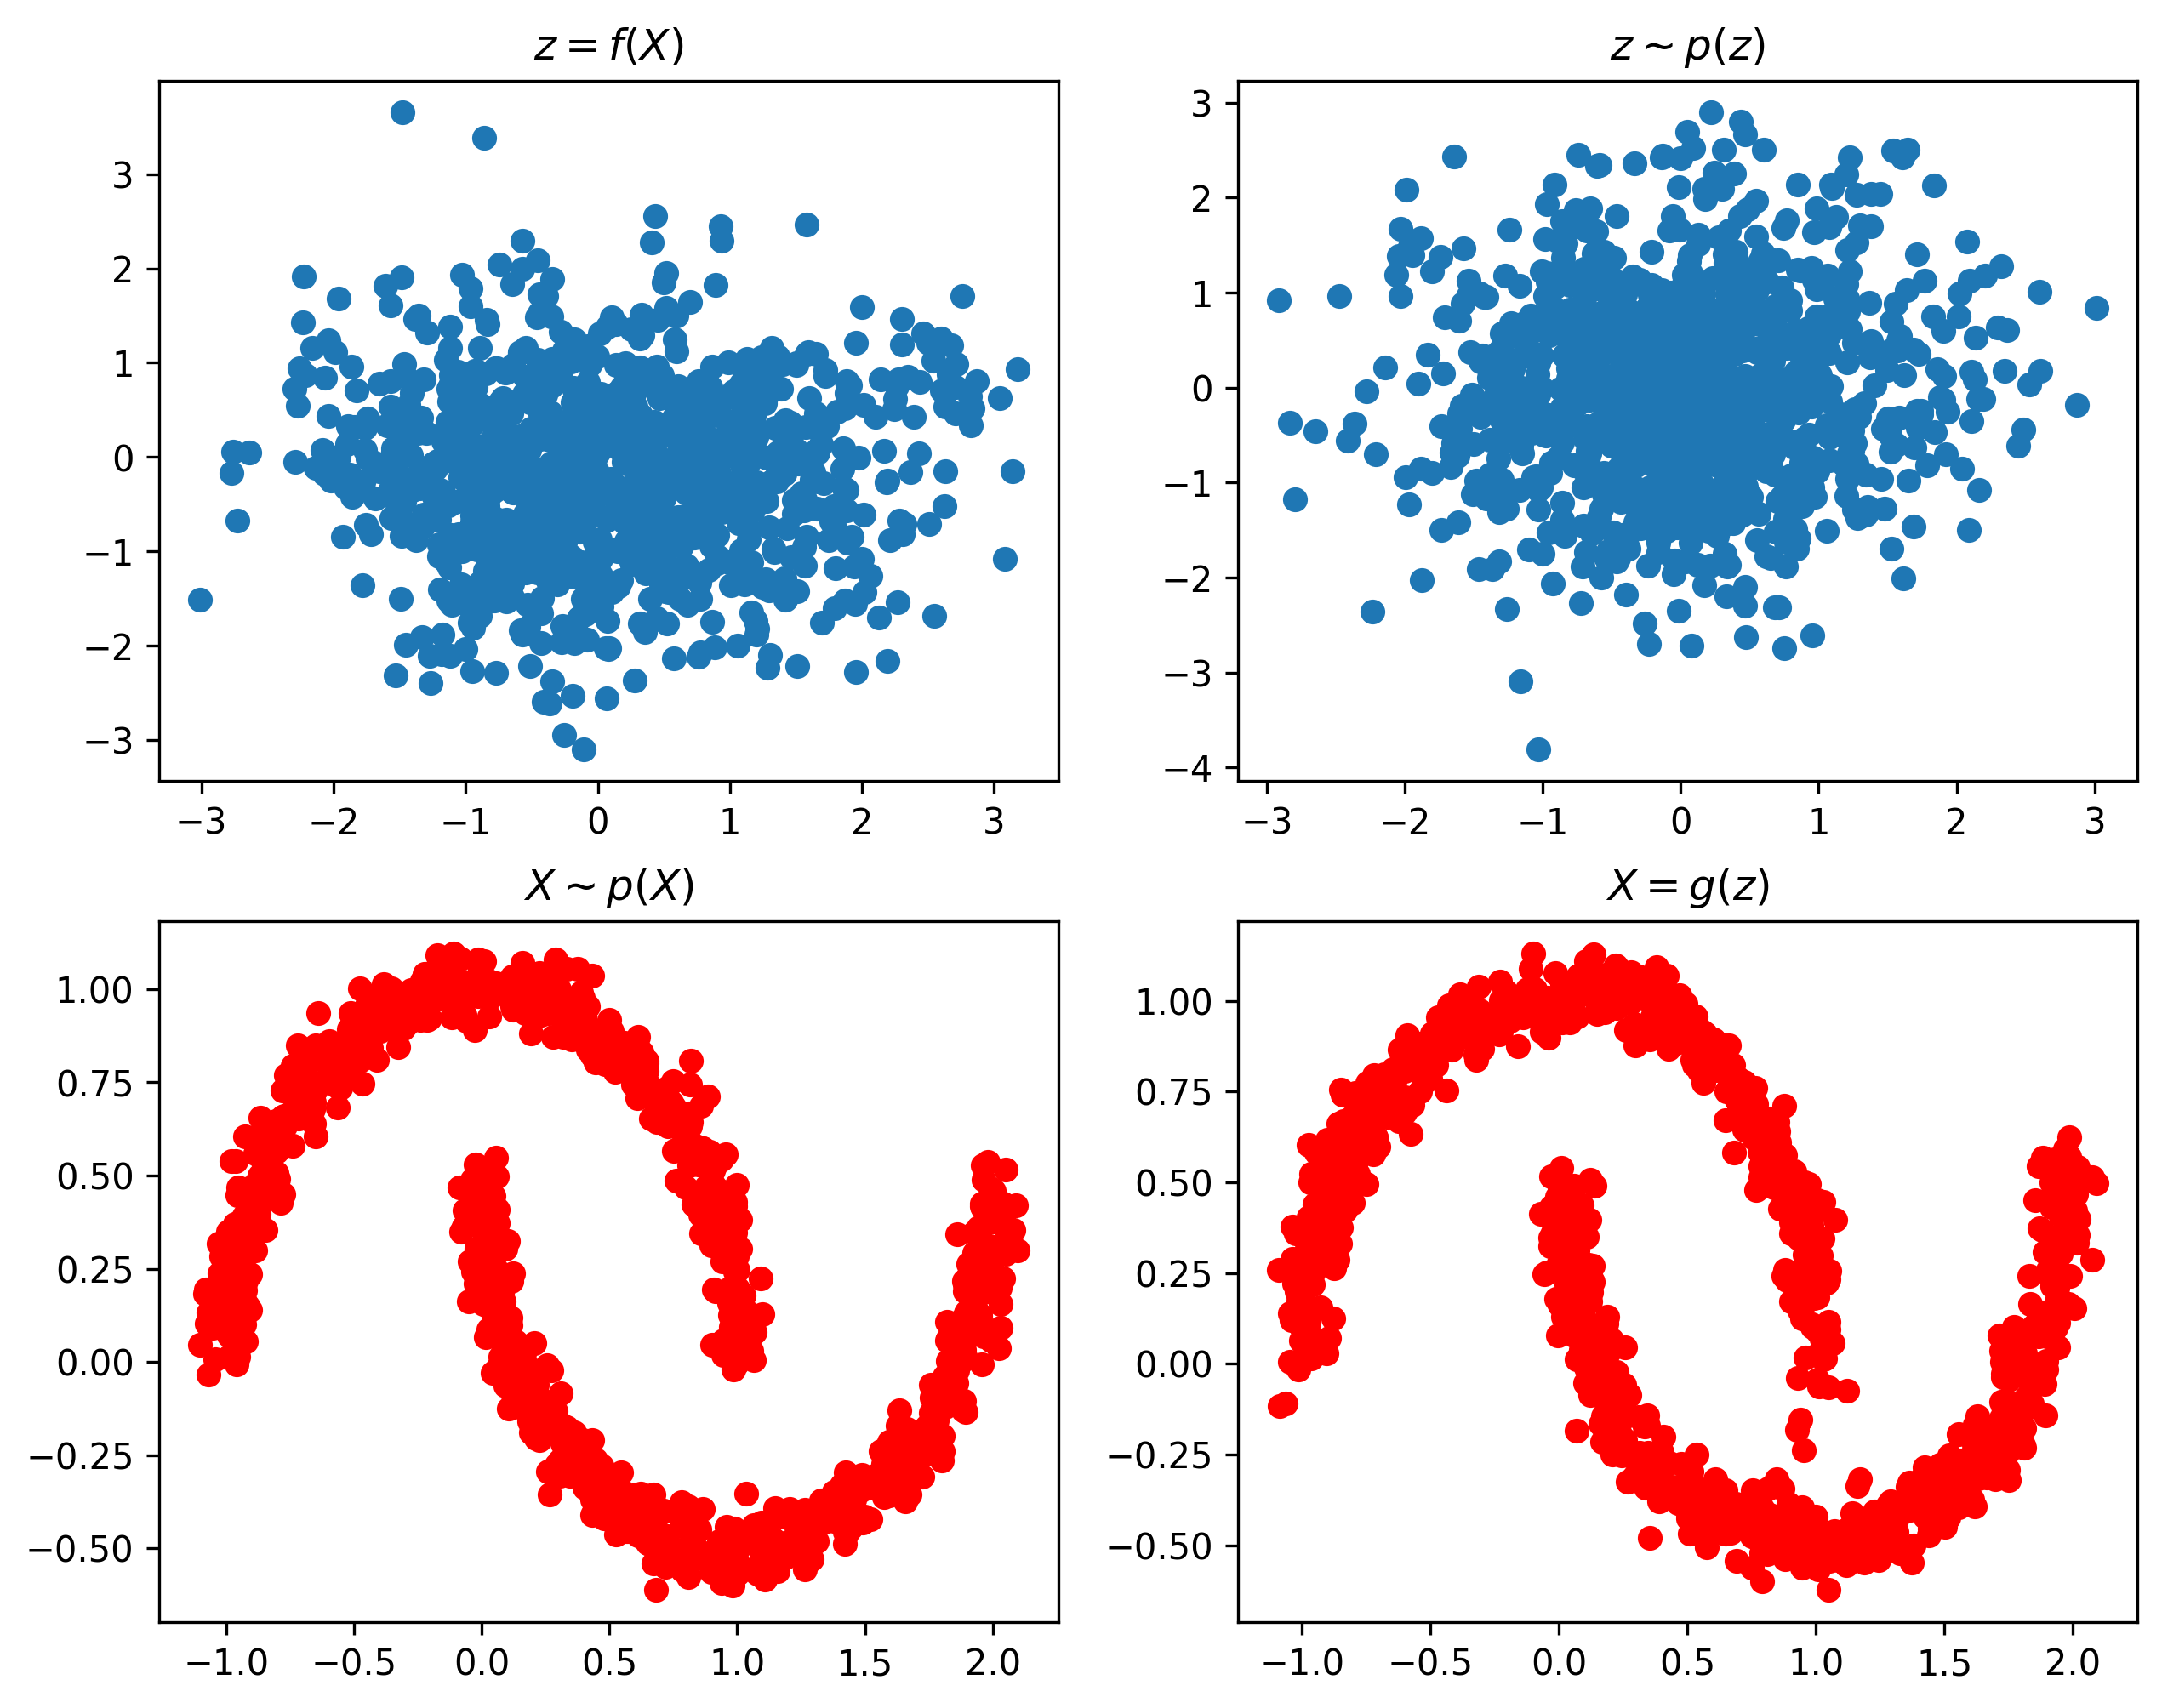

In [ ]:
noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
plt.subplot(221)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z = f(X)$')

z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
plt.subplot(222)
plt.scatter(z[:, 0], z[:, 1])
plt.title(r'$z \sim p(z)$')

plt.subplot(223)
x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
plt.scatter(x[:, 0], x[:, 1], c='r')
plt.title(r'$X \sim p(X)$')

plt.subplot(224)
x = flow.sample(1000).detach().numpy()
plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
plt.title(r'$X = g(z)$')

The resulting images look high-quality enough, and they are quite close to the original ones.

Let's conduct experiments for various network parameters (the number of layers, hidden size, the type of nonlinearity, the type of weights initialization, the number of coupling layers) and compare the generation results, the value of the loss function and the training time.

In [60]:
def create_and_train_model(x_dim, hidden_dim, n_layers, nonlinearity, initialization, number_of_coupling_layers):
    nets = lambda: create_model(n_layers, x_dim, hidden_dim, nonlinearity, initialization)
    nett = lambda: create_model(n_layers, x_dim, hidden_dim, nonlinearity, initialization)

    nets_test = nets()
    nett_test = nett()


    masks = torch.from_numpy(np.tile([[1, 0], [0, 1]], [int(number_of_coupling_layers / 2), 1]))

    prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

    flow = RealNVP(nets, nett, masks, prior)

    trainable_parameters = list(flow.s.parameters()) + list(flow.t.parameters())
    optimizer = torch.optim.Adam(trainable_parameters, lr=1e-4)

    for t in range(5001):    
        noisy_moons = datasets.make_moons(n_samples=100, noise=.05)
        loss = -torch.mean(flow.log_prob(torch.from_numpy(noisy_moons[0]).float()))
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if t % 500 == 0:
            print('iter %s:' % t, 'loss = %.3f' % loss)
    return flow


In [61]:
def plot_results(flow):
    noisy_moons = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
    z = flow.f(torch.from_numpy(noisy_moons))[0].detach().numpy()
    plt.subplot(221)
    plt.scatter(z[:, 0], z[:, 1])
    plt.title(r'$z = f(X)$')

    z = np.random.multivariate_normal(np.zeros(2), np.eye(2), 1000)
    plt.subplot(222)
    plt.scatter(z[:, 0], z[:, 1])
    plt.title(r'$z \sim p(z)$')

    plt.subplot(223)
    x = datasets.make_moons(n_samples=1000, noise=.05)[0].astype(np.float32)
    plt.scatter(x[:, 0], x[:, 1], c='r')
    plt.title(r'$X \sim p(X)$')

    plt.subplot(224)
    x = flow.sample(1000).detach().numpy()
    plt.scatter(x[:, 0, 0], x[:, 0, 1], c='r')
    plt.title(r'$X = g(z)$')

First let's consider the number of coupling layers. The following parameter values can be used as the initial configuration: hidden dimension=128, number of linear layers=5, no special weight initialization, ReLU as activation function. 

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=6)

iter 0: loss = 2.703
iter 500: loss = 0.965
iter 1000: loss = 0.653
iter 1500: loss = 0.607
iter 2000: loss = 0.431
iter 2500: loss = 0.632
iter 3000: loss = 0.580
iter 3500: loss = 0.410
iter 4000: loss = 0.535
iter 4500: loss = 0.594
iter 5000: loss = 0.378
CPU times: user 4min 44s, sys: 569 ms, total: 4min 44s
Wall time: 4min 55s


Text(0.5, 1.0, '$X = g(z)$')

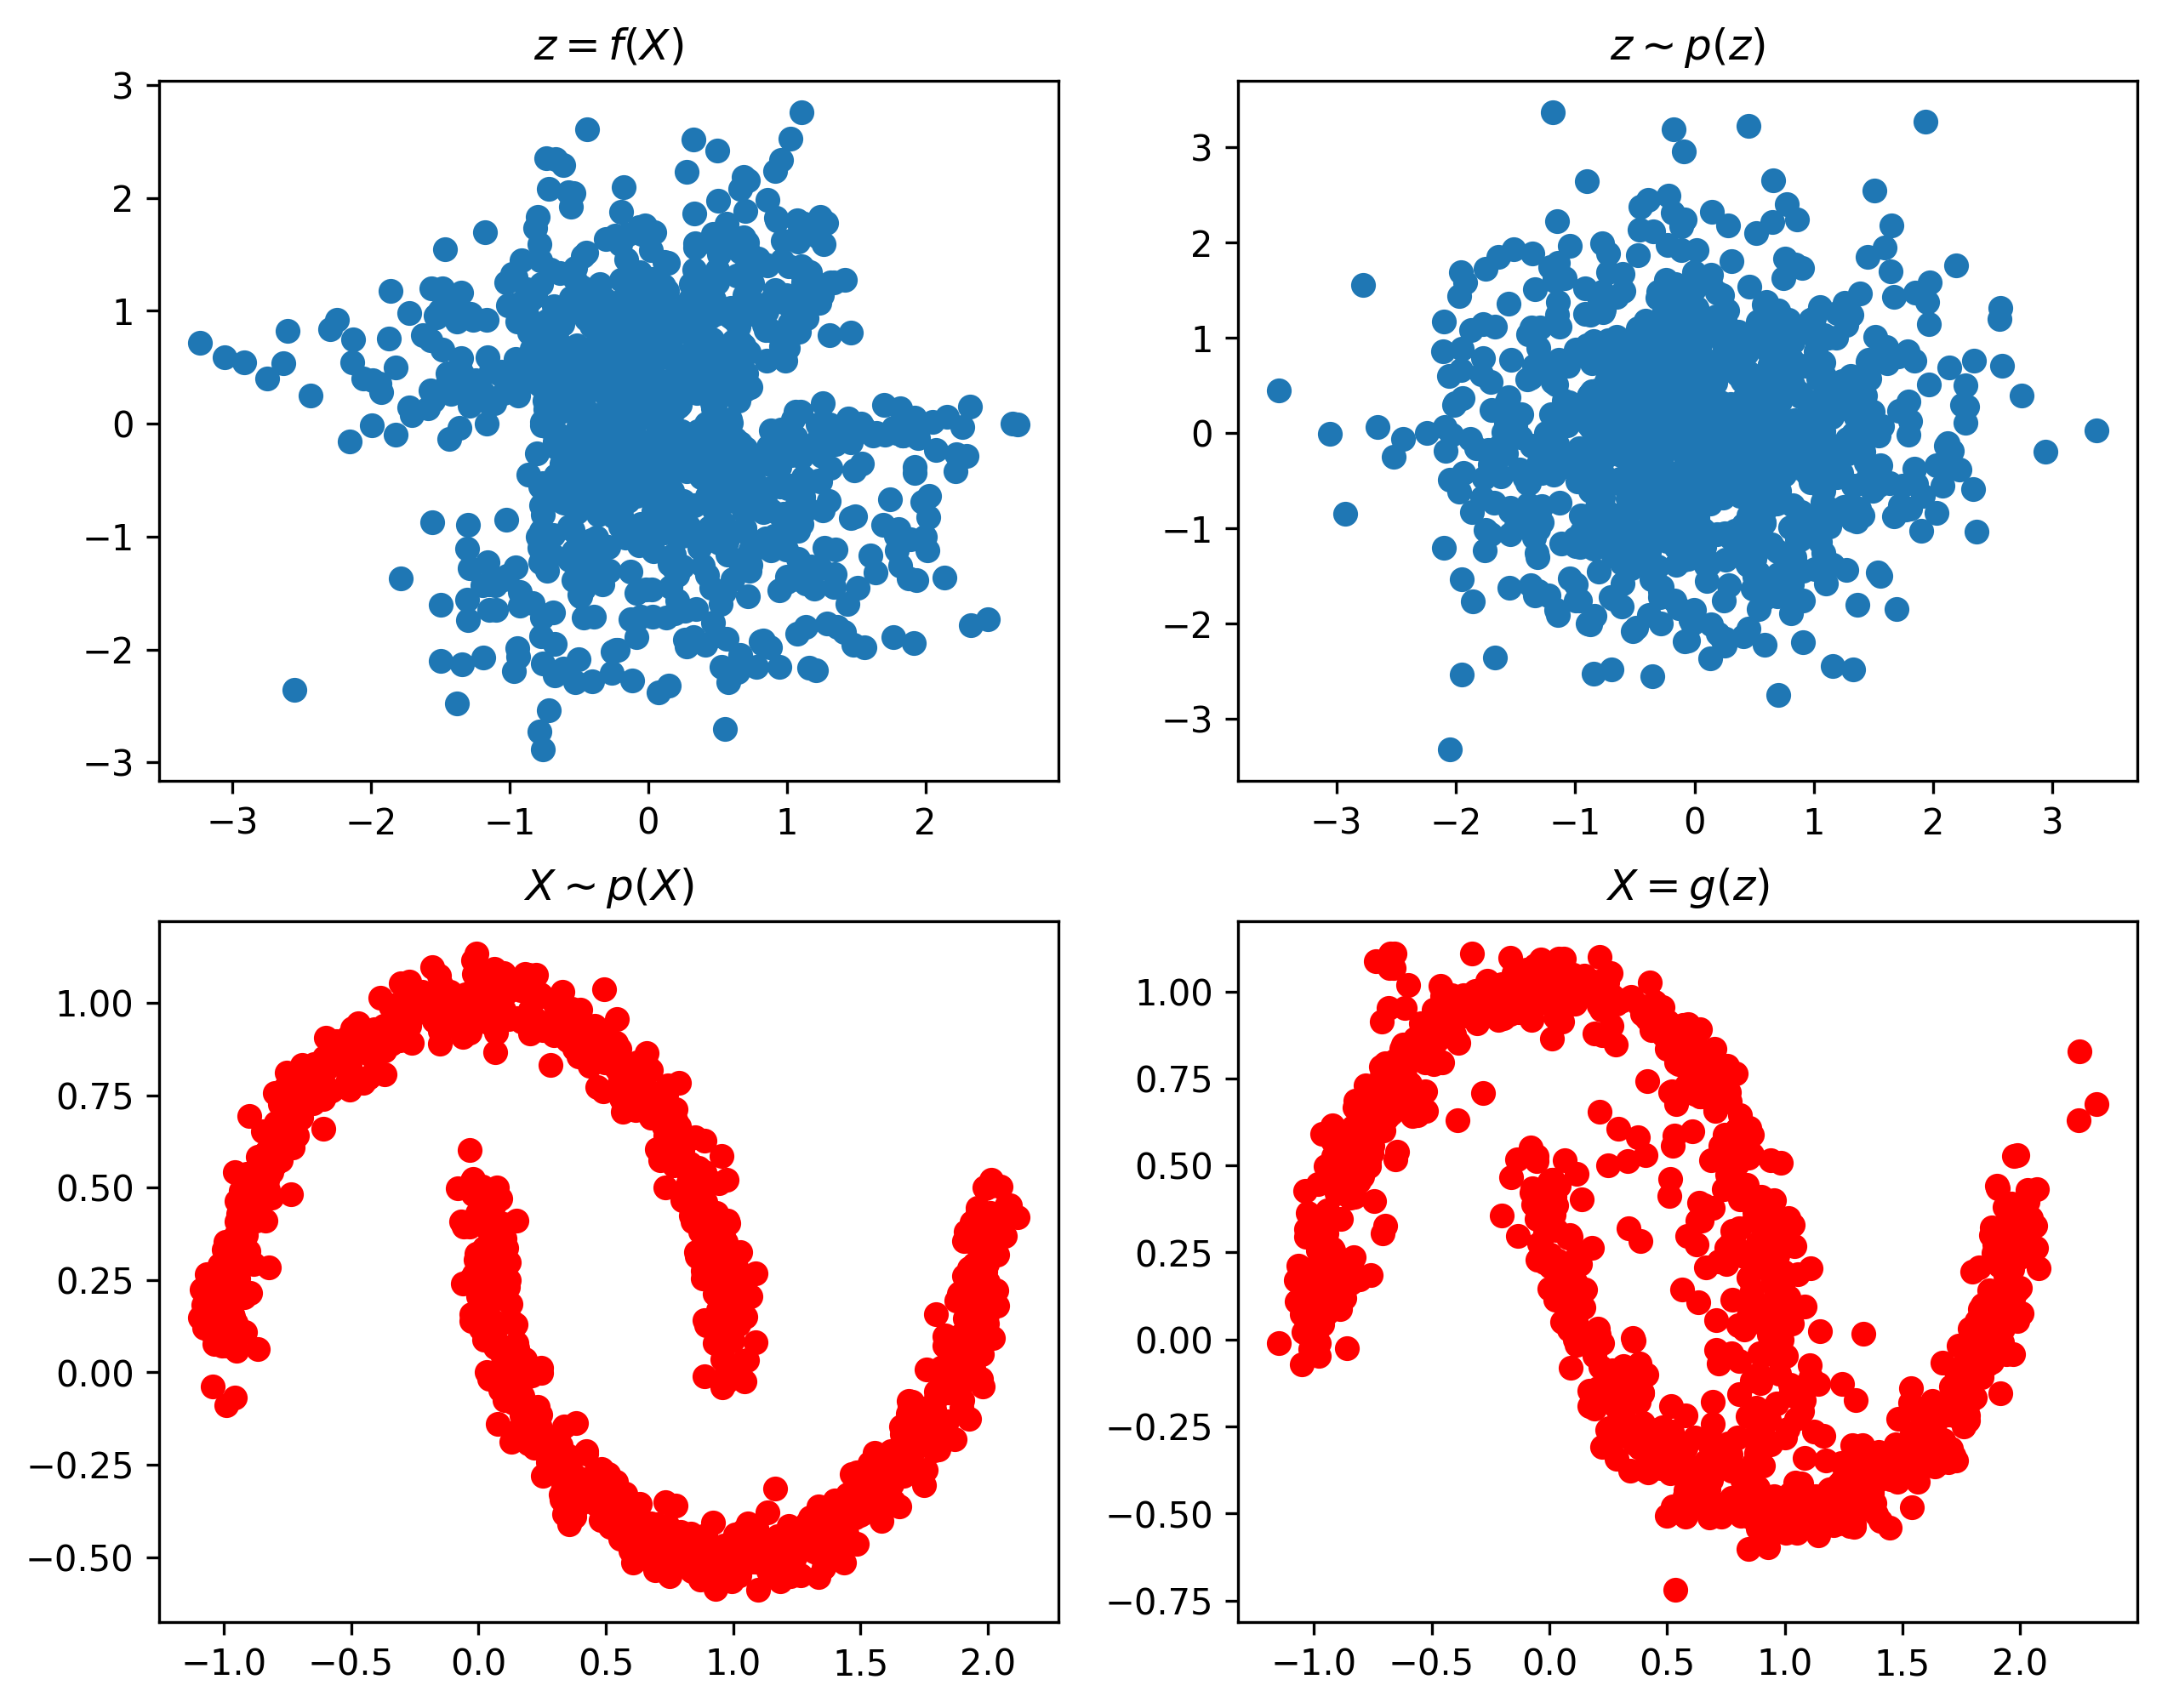

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=10)

iter 0: loss = 2.655
iter 500: loss = 0.723
iter 1000: loss = 0.470
iter 1500: loss = 0.381
iter 2000: loss = 0.452
iter 2500: loss = 0.489
iter 3000: loss = 0.379
iter 3500: loss = 0.543
iter 4000: loss = 0.368
iter 4500: loss = 0.351
iter 5000: loss = 0.406
CPU times: user 7min 42s, sys: 1.07 s, total: 7min 43s
Wall time: 7min 51s


Text(0.5, 1.0, '$X = g(z)$')

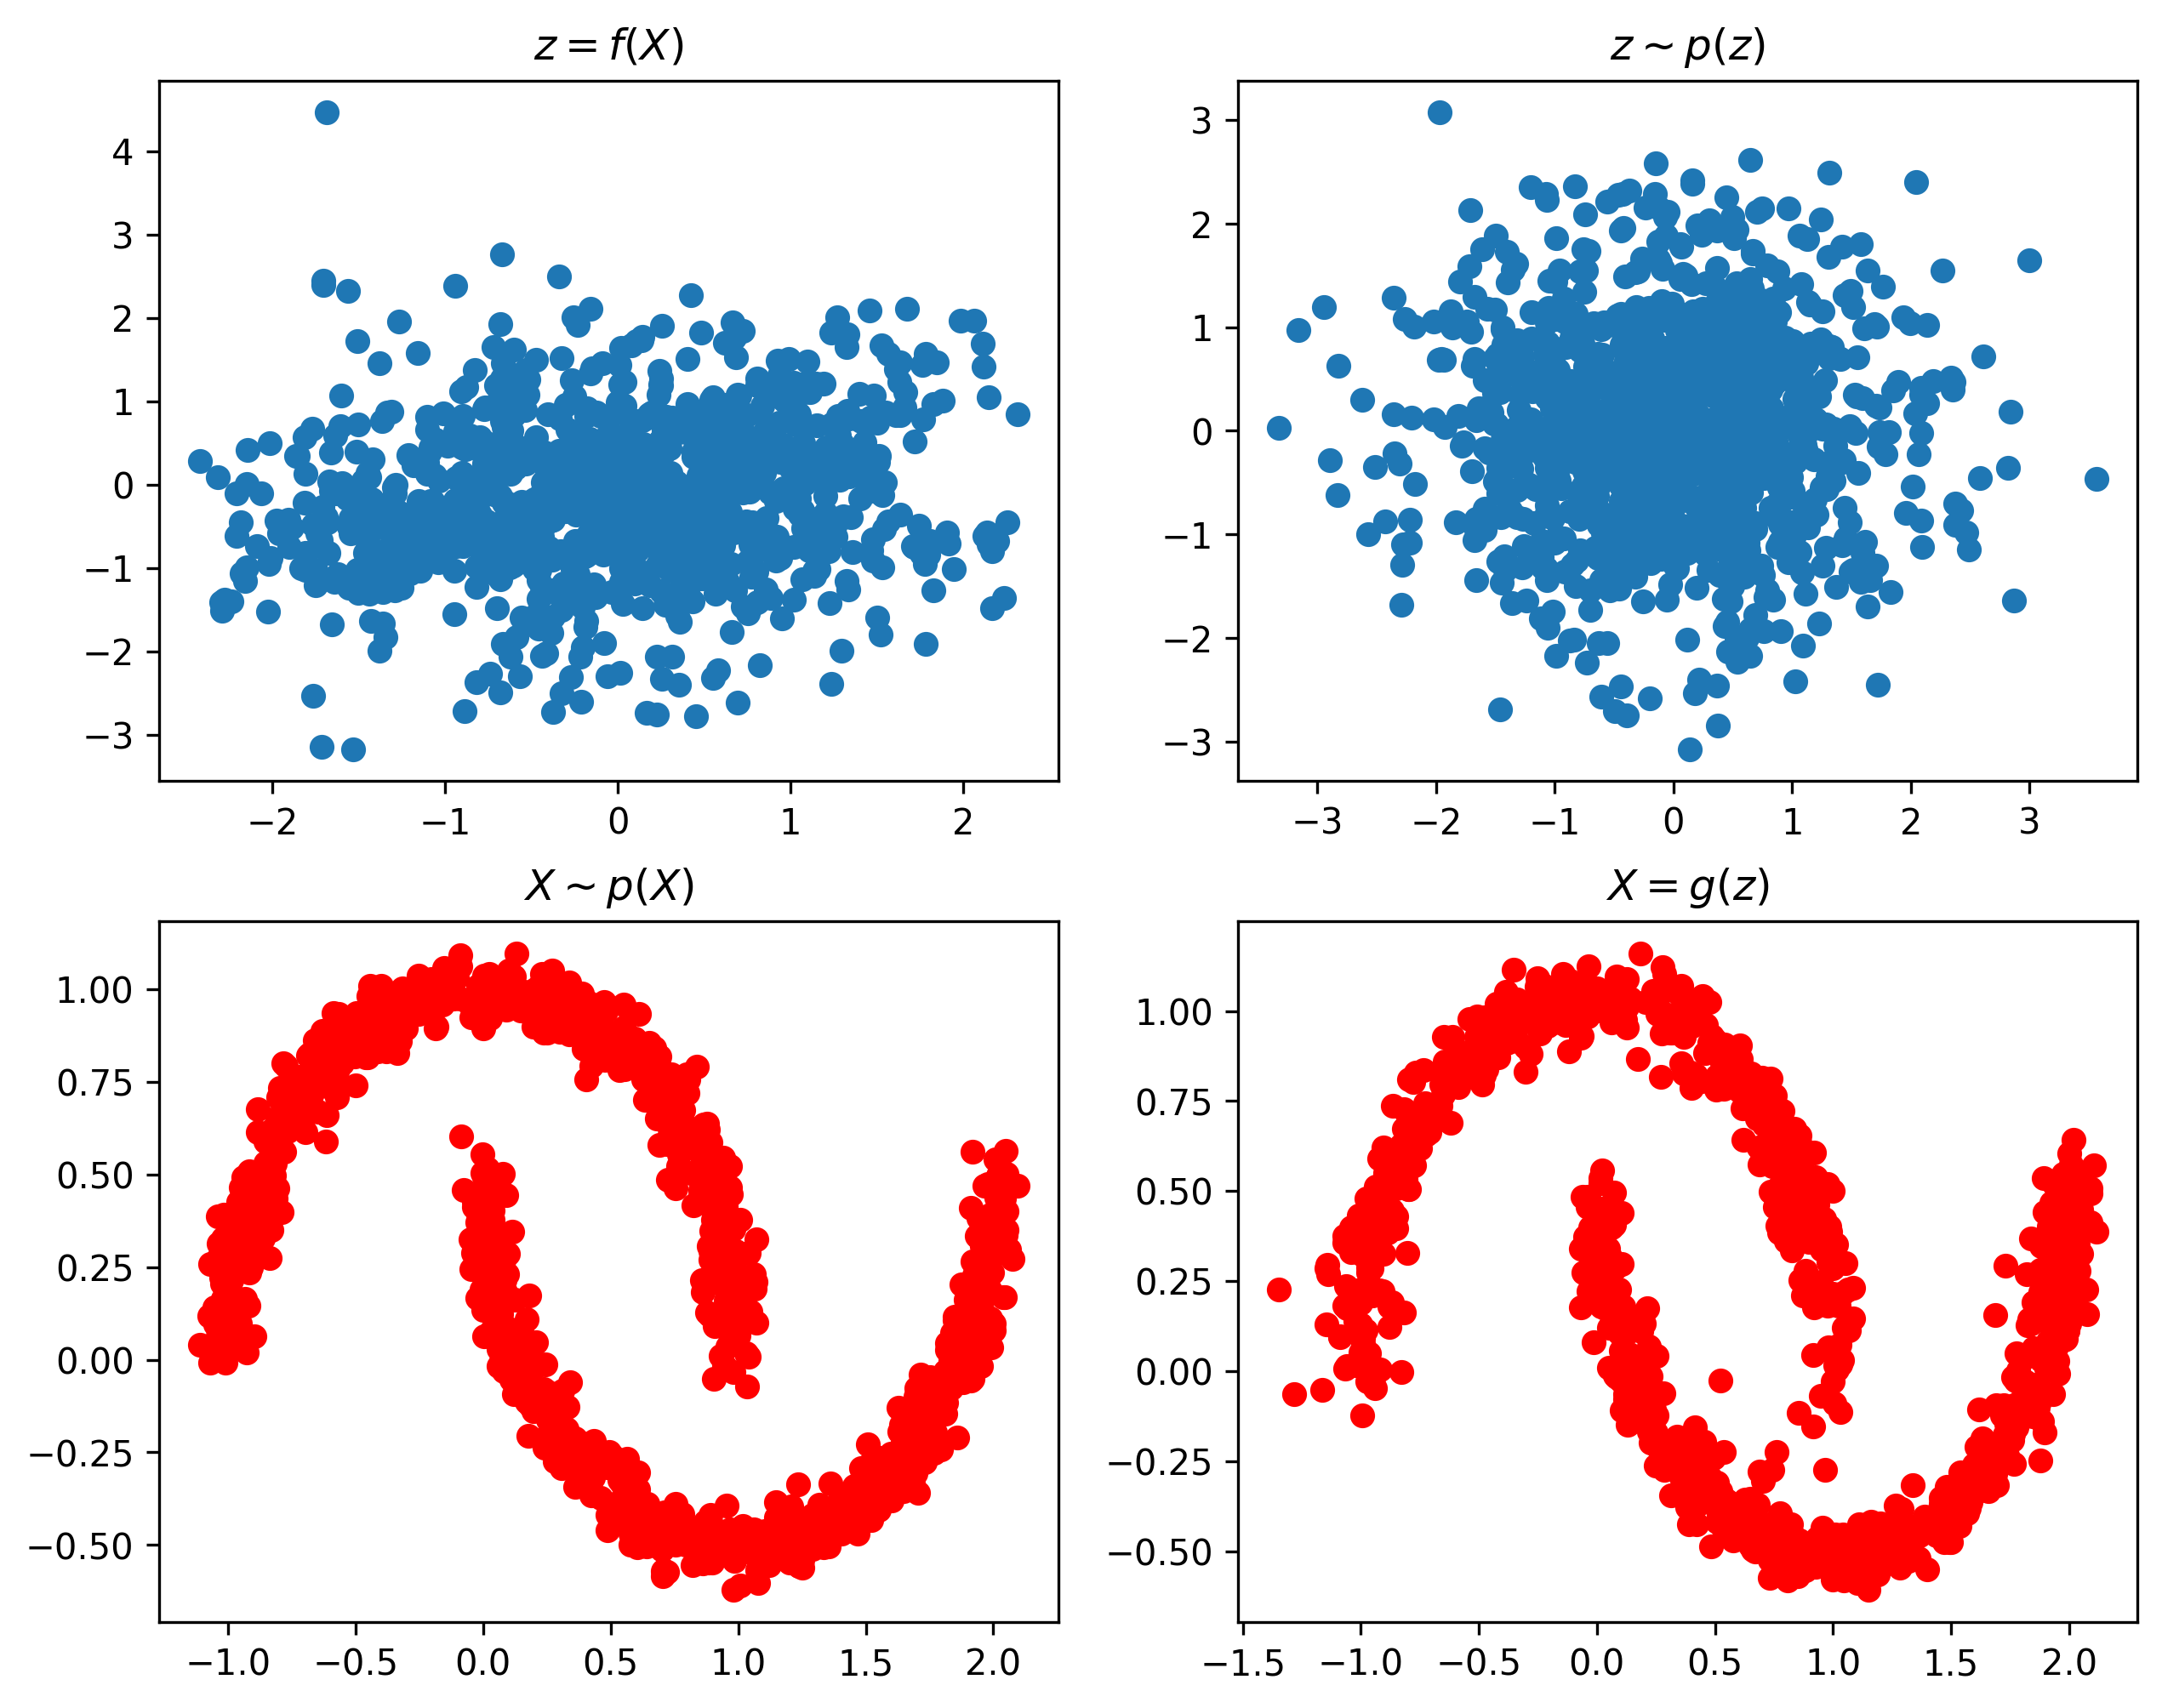

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=20)

iter 0: loss = 2.710
iter 500: loss = 0.767
iter 1000: loss = 0.605
iter 1500: loss = 0.500
iter 2000: loss = 0.433
iter 2500: loss = 0.306
iter 3000: loss = 0.464
iter 3500: loss = 0.407
iter 4000: loss = 0.398
iter 4500: loss = 0.329
iter 5000: loss = 0.456
CPU times: user 15min 1s, sys: 2.32 s, total: 15min 4s
Wall time: 15min 13s


Text(0.5, 1.0, '$X = g(z)$')

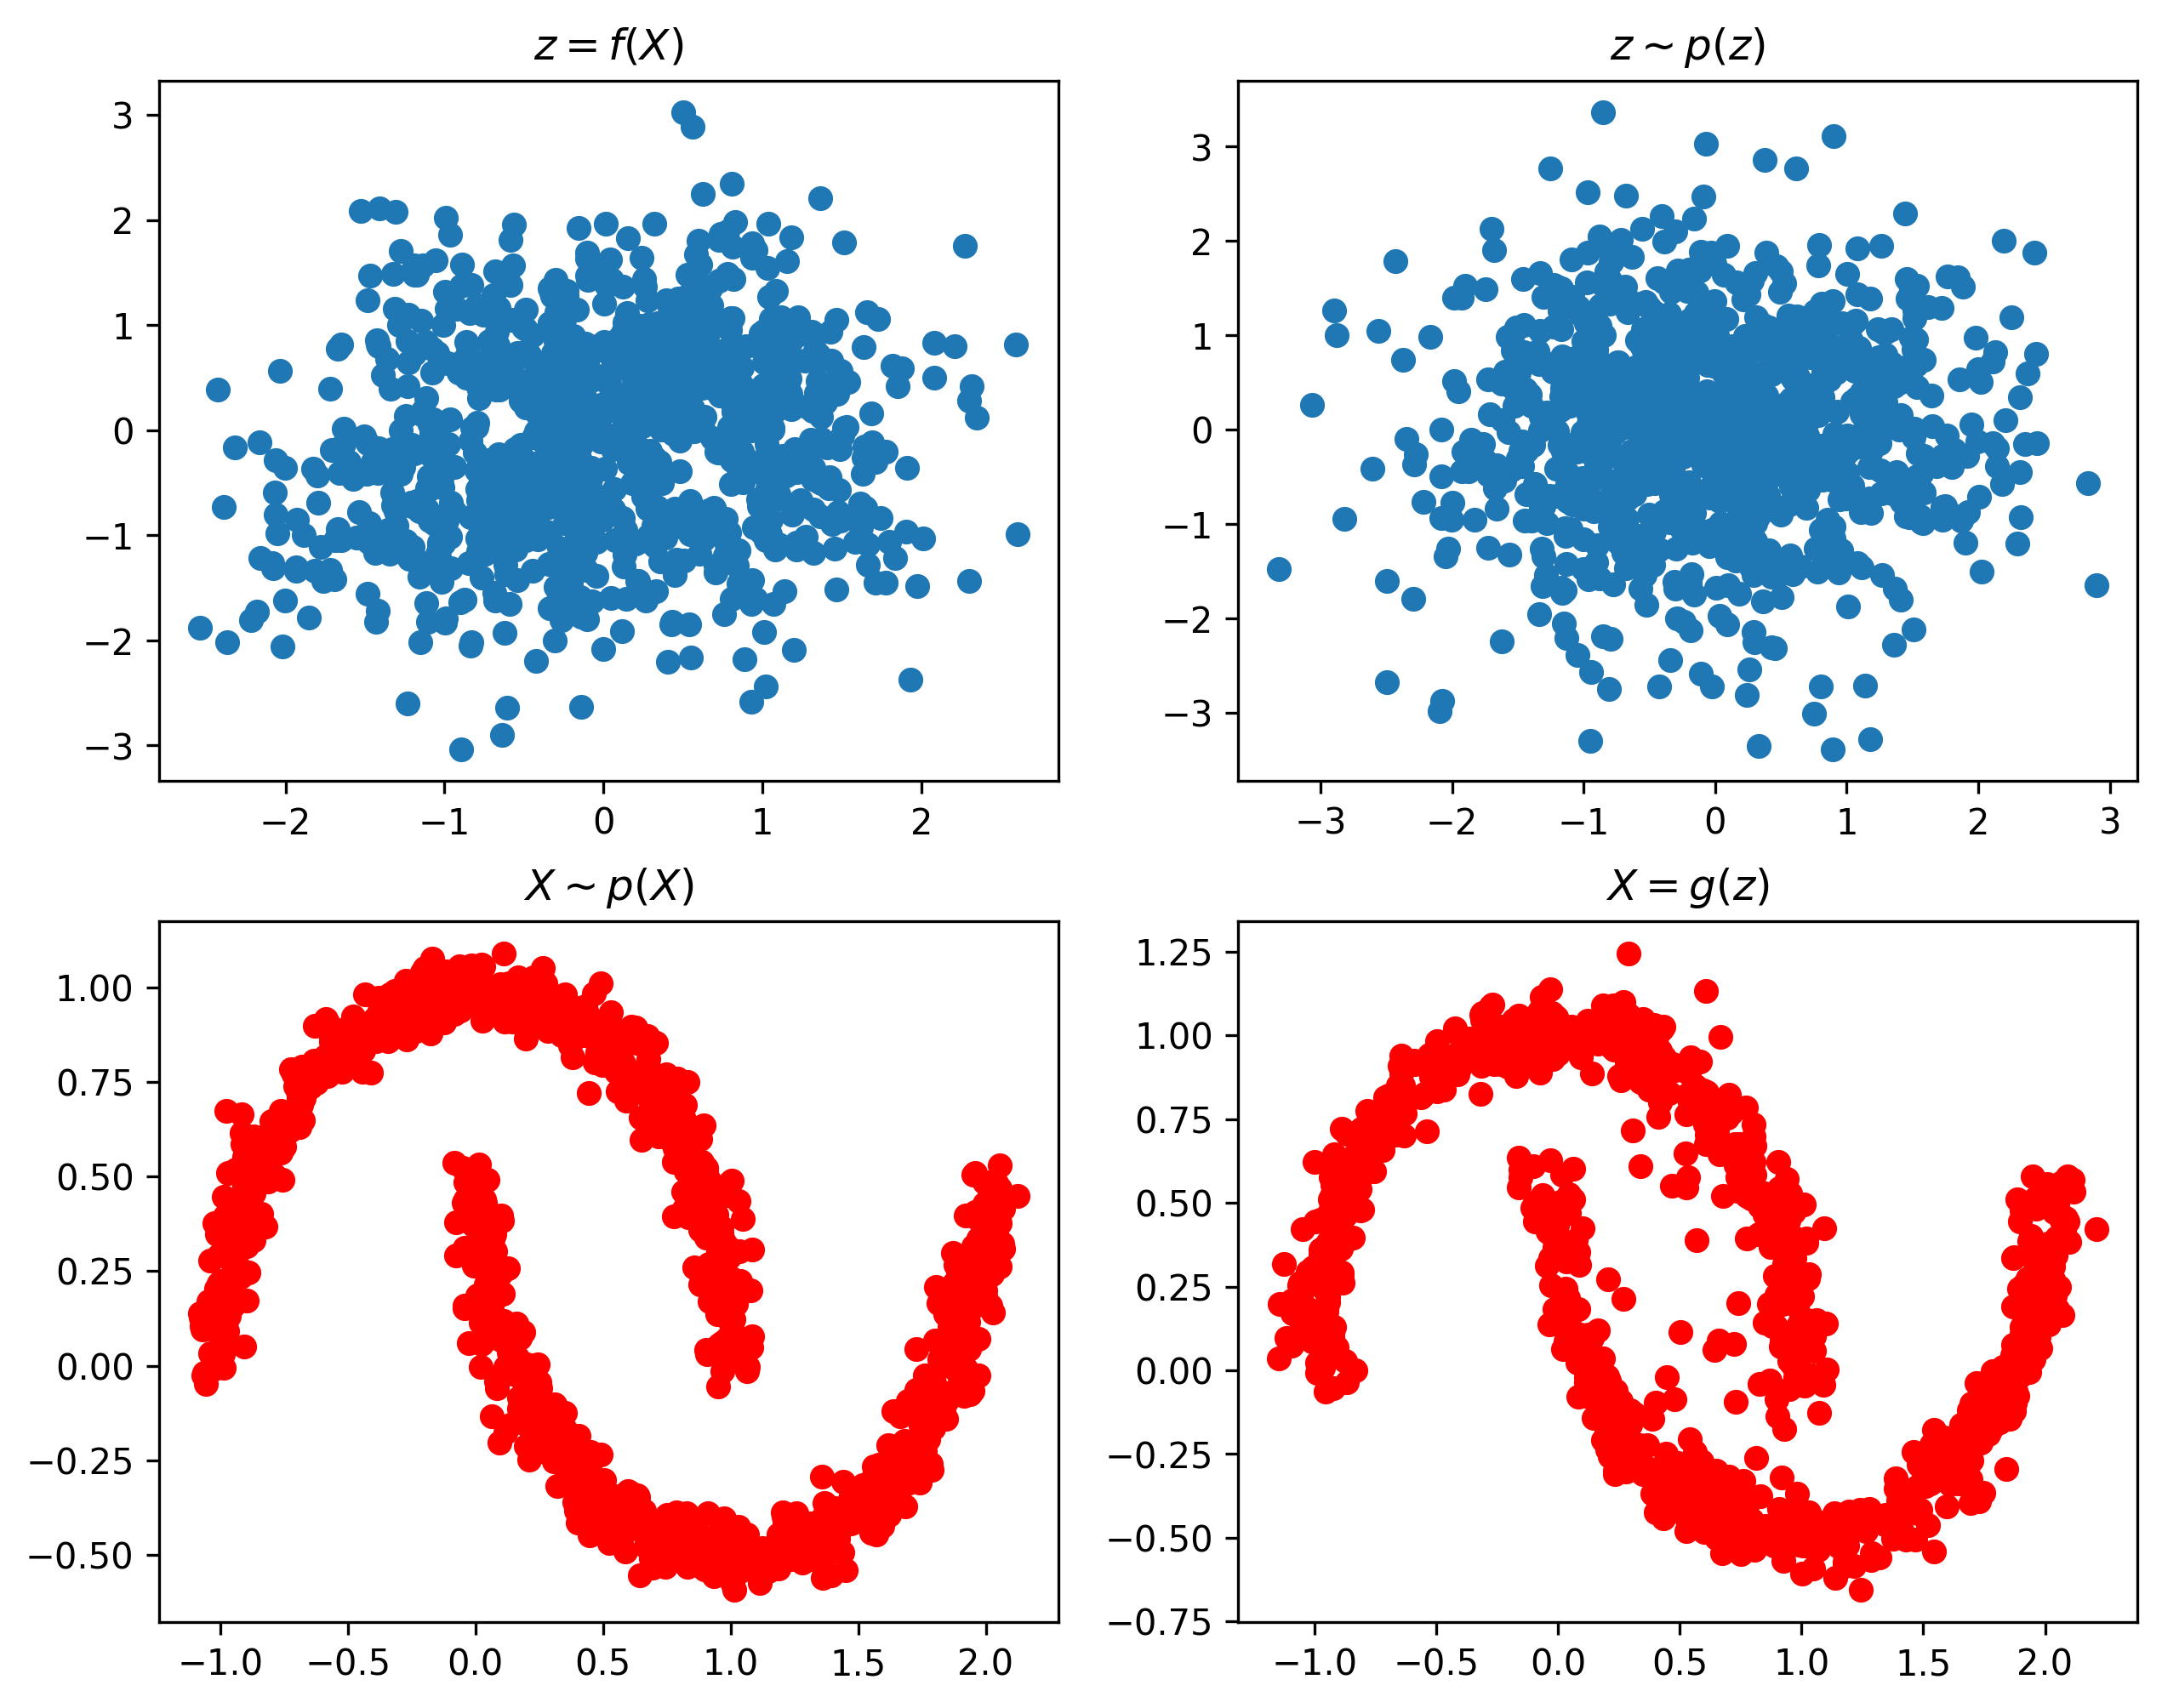

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=30)

iter 0: loss = 2.722
iter 500: loss = 0.581
iter 1000: loss = 0.486
iter 1500: loss = 0.530
iter 2000: loss = 0.489
iter 2500: loss = 0.438
iter 3000: loss = 0.470
iter 3500: loss = 0.340
iter 4000: loss = 0.401
iter 4500: loss = 0.373
iter 5000: loss = 0.341
CPU times: user 21min 47s, sys: 3.05 s, total: 21min 50s
Wall time: 21min 54s


Text(0.5, 1.0, '$X = g(z)$')

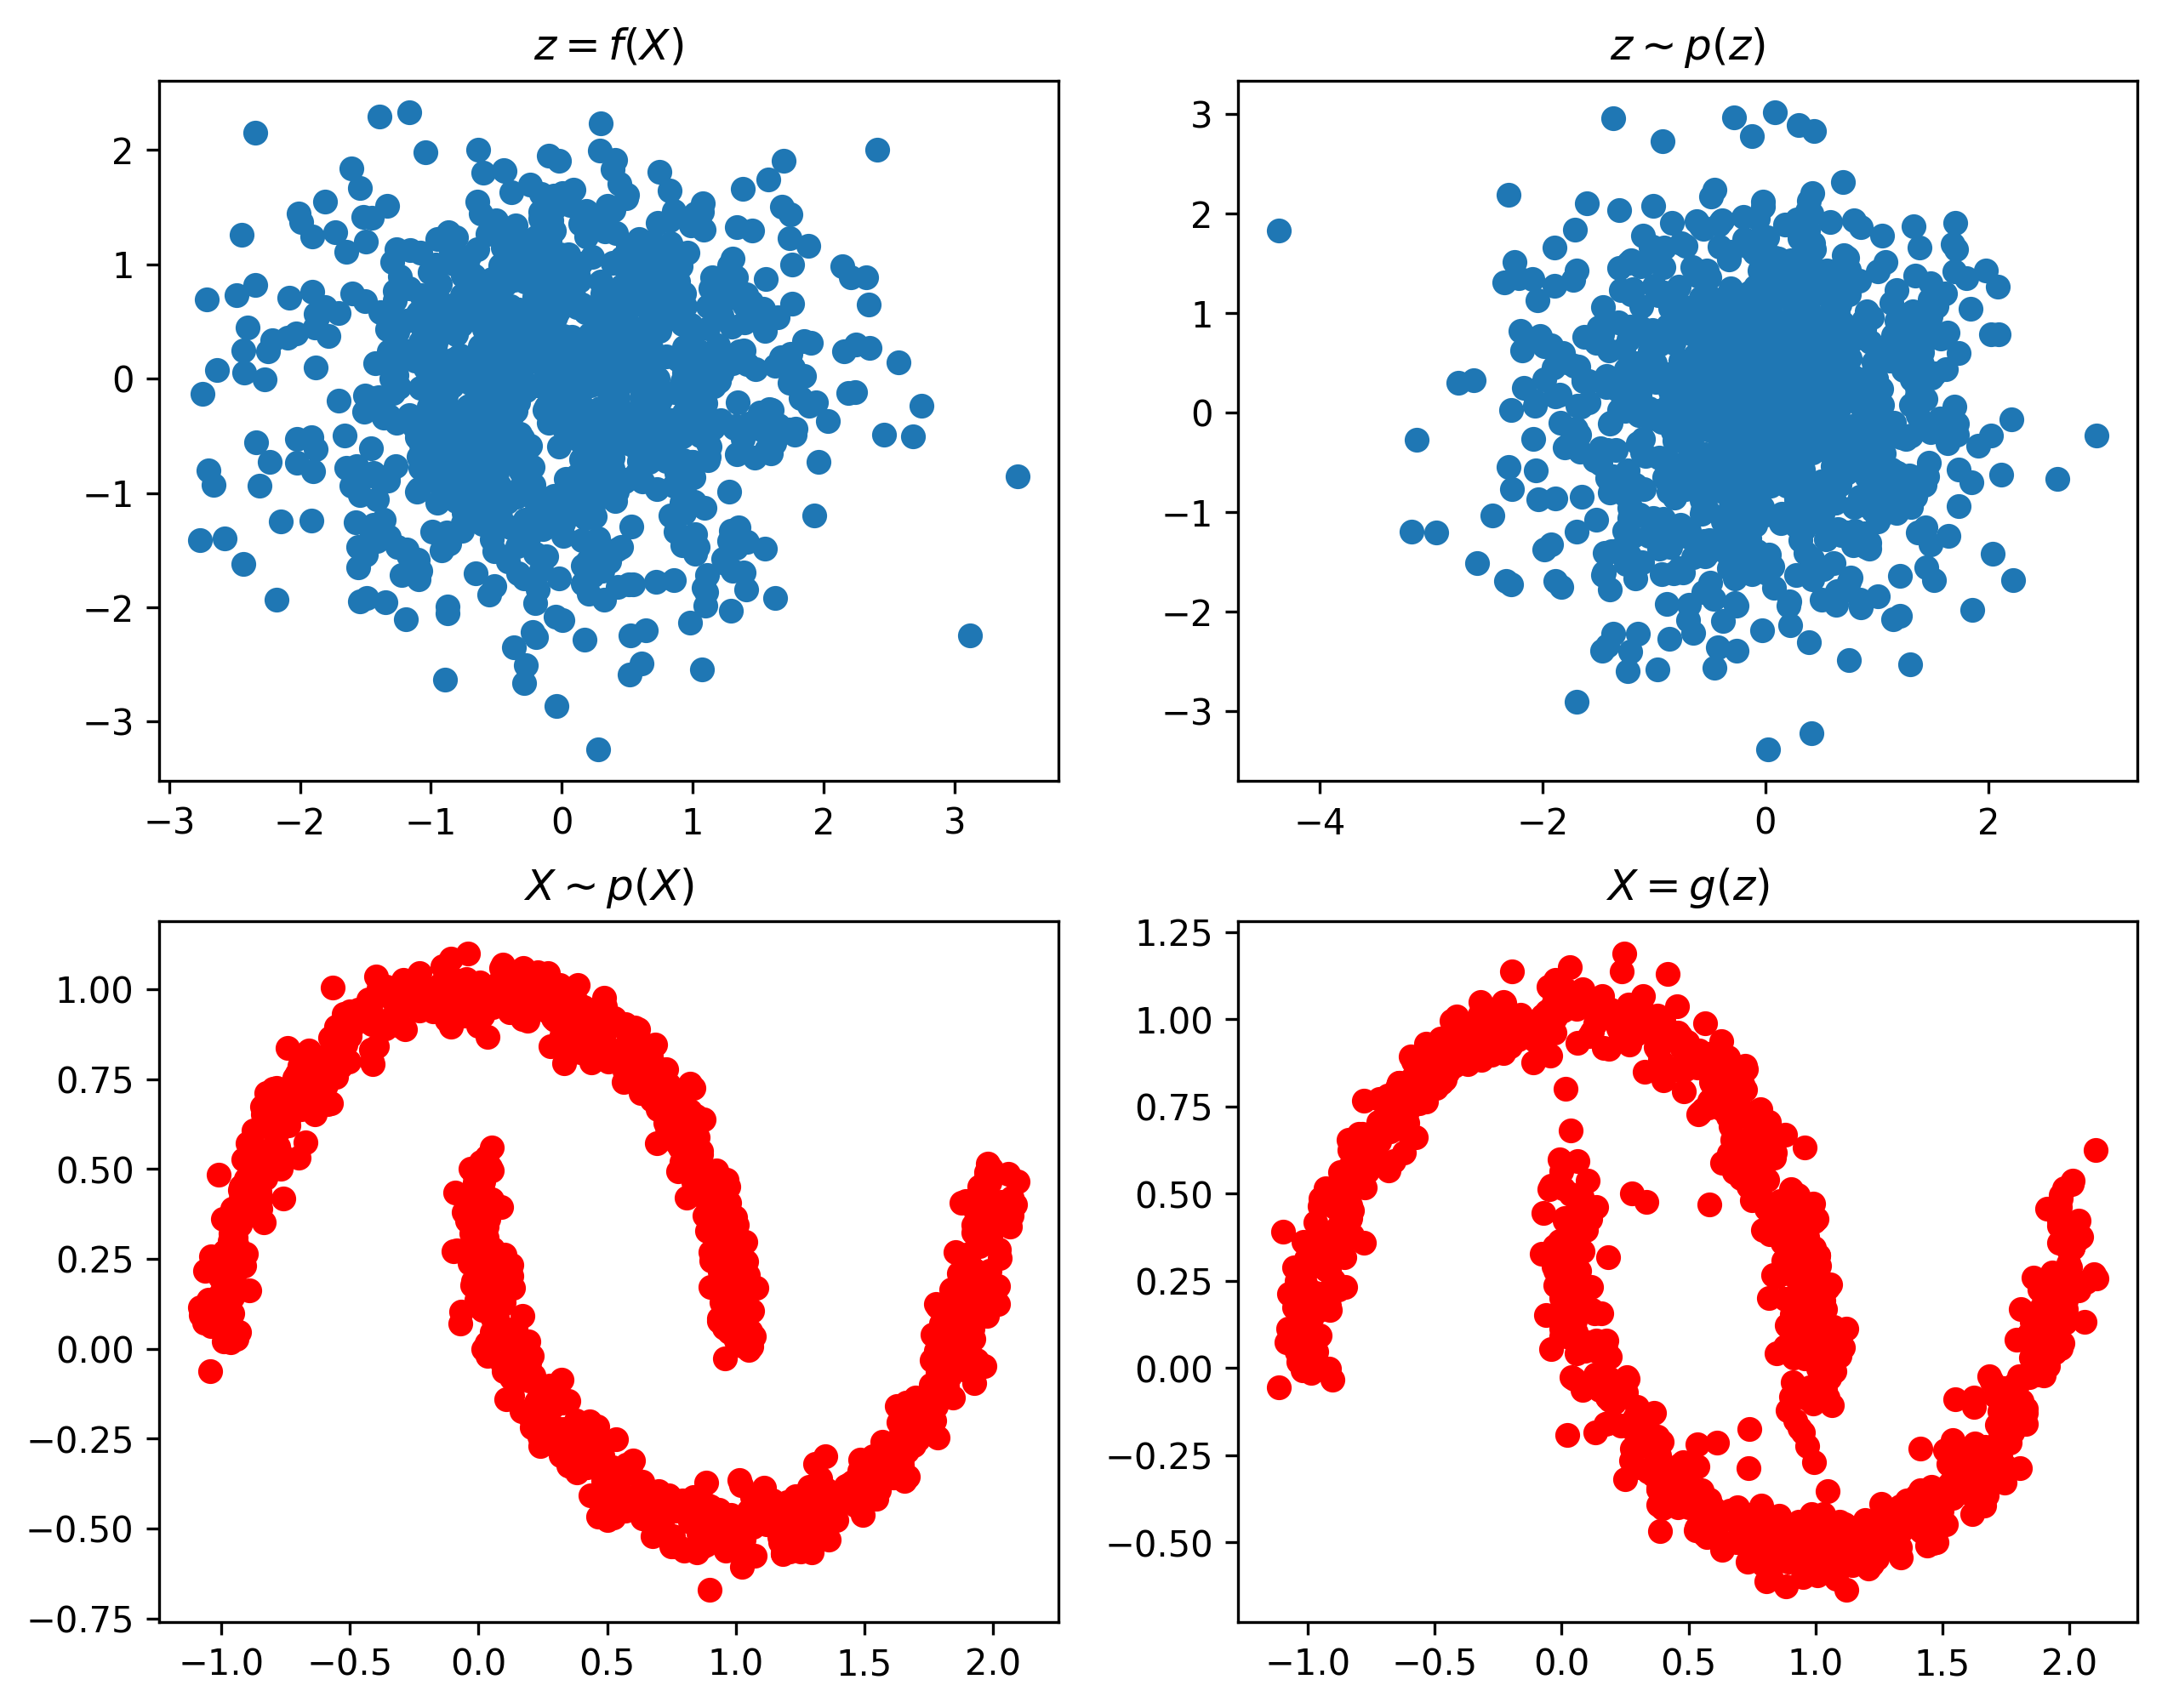

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.797
iter 500: loss = 0.600
iter 1000: loss = 0.385
iter 1500: loss = 0.432
iter 2000: loss = 0.498
iter 2500: loss = 0.468
iter 3000: loss = 0.431
iter 3500: loss = 0.432
iter 4000: loss = 0.337
iter 4500: loss = 0.401
iter 5000: loss = 0.364
CPU times: user 35min 52s, sys: 4.93 s, total: 35min 56s
Wall time: 35min 47s


Text(0.5, 1.0, '$X = g(z)$')

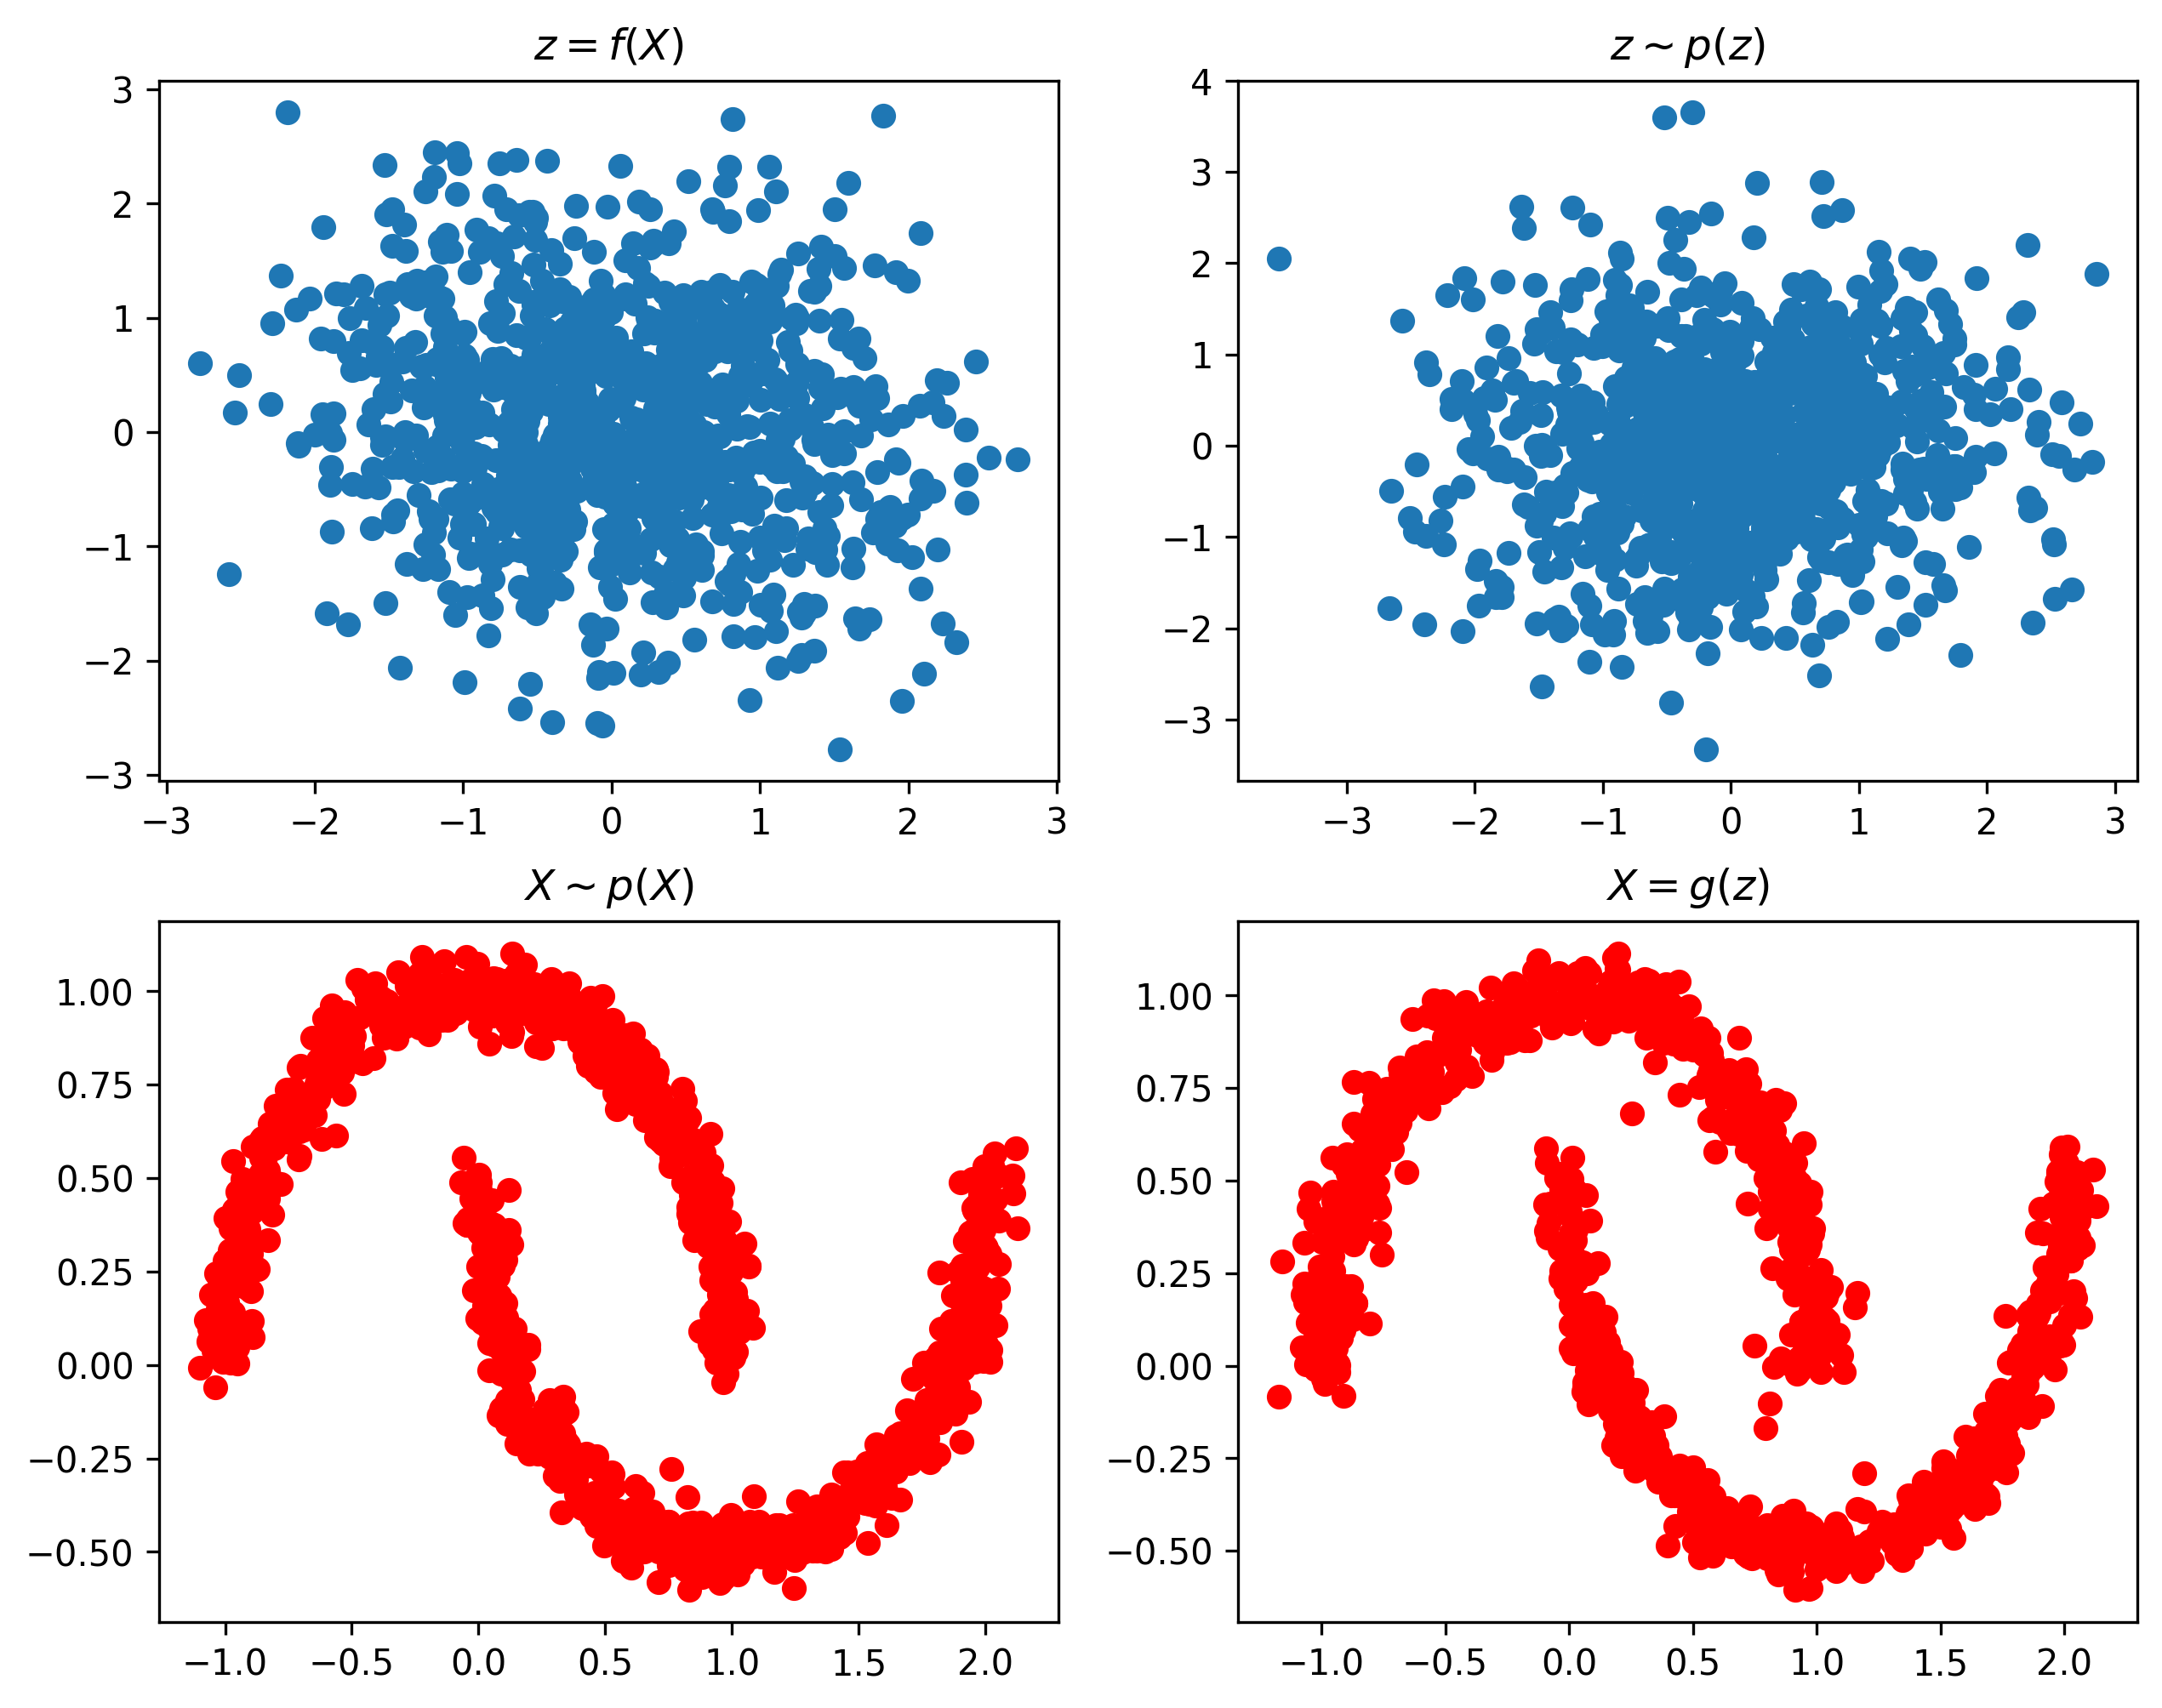

In [ ]:
plot_results(flow)

In general, it is possible to say that with an increase in the number of coupling layers, the generation result becomes better and more realistic, and the value of the loss function decreases very slightly, but the training time of the model increases. Visually, the best results were obtained with 50 layers. With the increase in the number of coupling layers, the number of tunable parameters of the model increases, the model becomes more flexible, however, since the transformations used in RealNVP are quite simple and are performed within the framework of one epoch, it does not require more epochs of training and the use of specifically other parameters of the optimizer, and the quality of the result increases at the same time. However, it is difficult to talk about an explicit dependency between the quality of generation and the number of coupling layers, since the results, for example, for 10 layers, seem to be of higher quality than for 20 and 30, so most likely the optimal number of coupling layers lies in a certain bounded range. In general, all the generation results can be called relatively realistic.

Next, let's take the value of 50 as the optimal number of coupling layers.

Let's consider the number of linear layers.

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=3, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.396
iter 500: loss = 0.621
iter 1000: loss = 0.434
iter 1500: loss = 0.297
iter 2000: loss = 0.312
iter 2500: loss = 0.394
iter 3000: loss = 0.354
iter 3500: loss = 0.390
iter 4000: loss = 0.254
iter 4500: loss = 0.462
iter 5000: loss = 0.338
CPU times: user 24min 29s, sys: 4.44 s, total: 24min 34s
Wall time: 24min 37s


/usr/local/lib/python3.9/dist-packages/torch/distributions/distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


Text(0.5, 1.0, '$X = g(z)$')

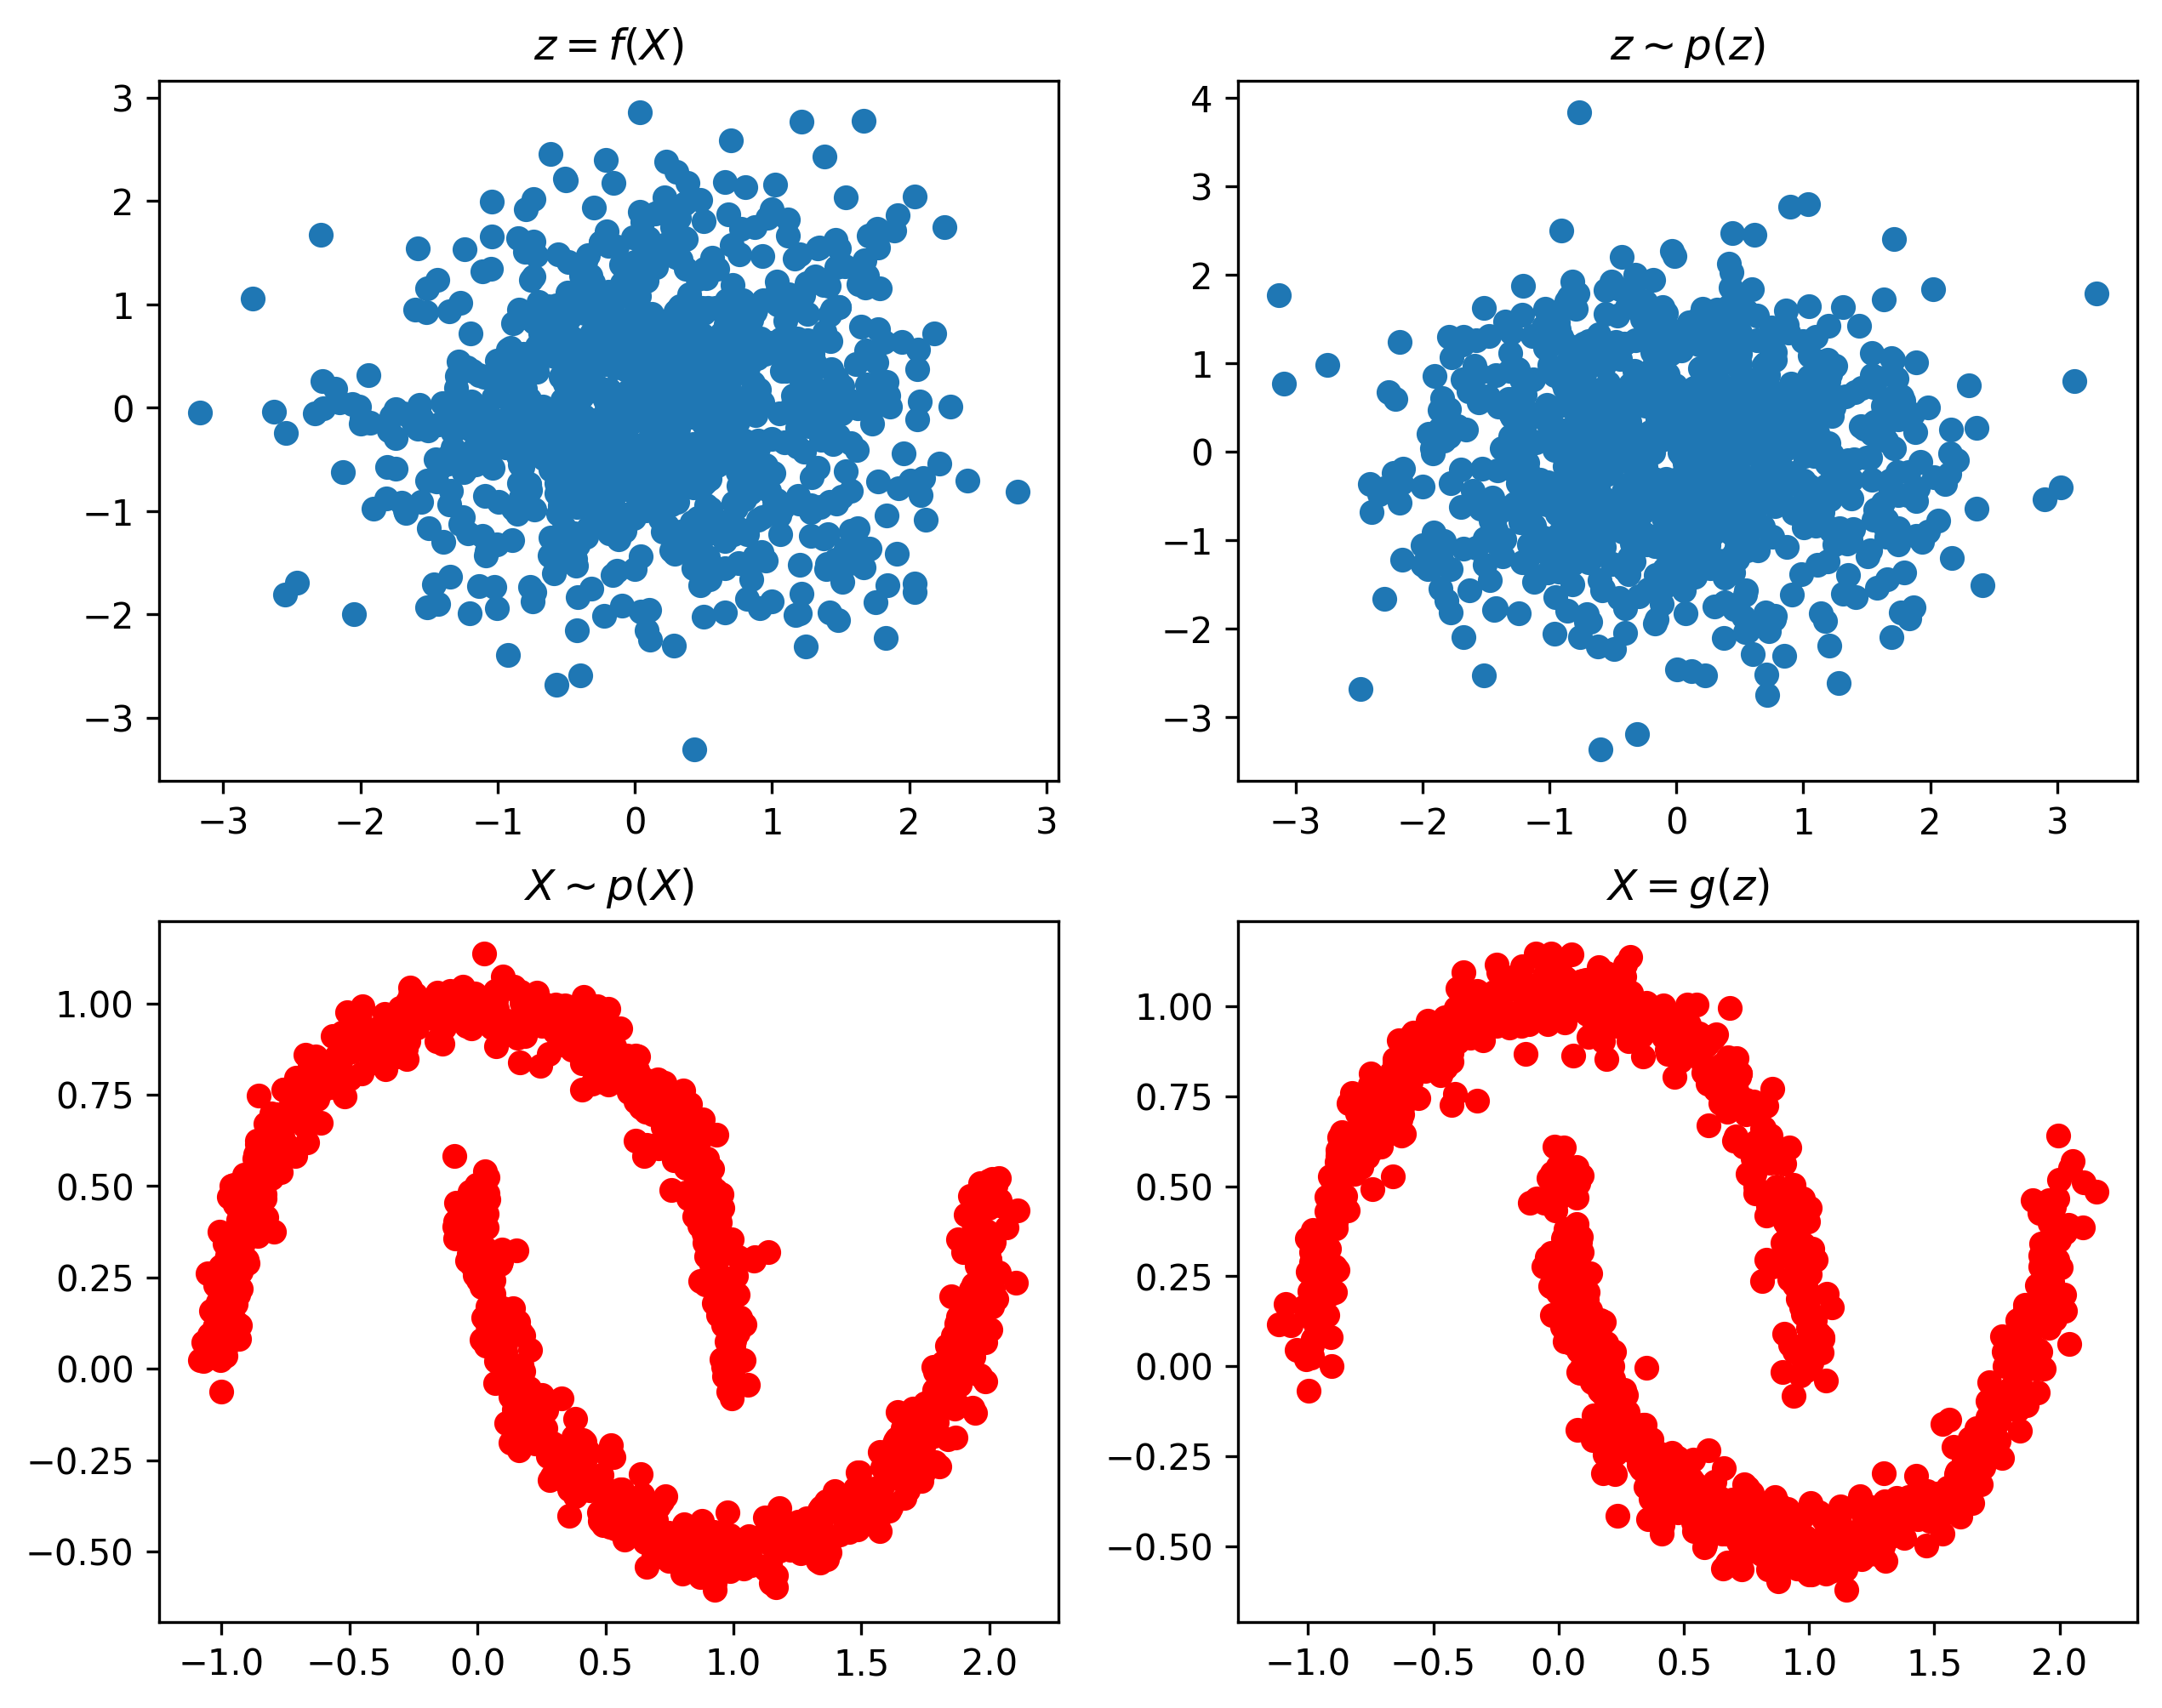

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 3.380
iter 500: loss = 0.501
iter 1000: loss = 0.411
iter 1500: loss = 0.431
iter 2000: loss = 0.346
iter 2500: loss = 0.341
iter 3000: loss = 0.255
iter 3500: loss = 0.401
iter 4000: loss = 0.405
iter 4500: loss = 0.363
iter 5000: loss = 0.345
CPU times: user 36min 40s, sys: 6.04 s, total: 36min 46s
Wall time: 36min 40s


Text(0.5, 1.0, '$X = g(z)$')

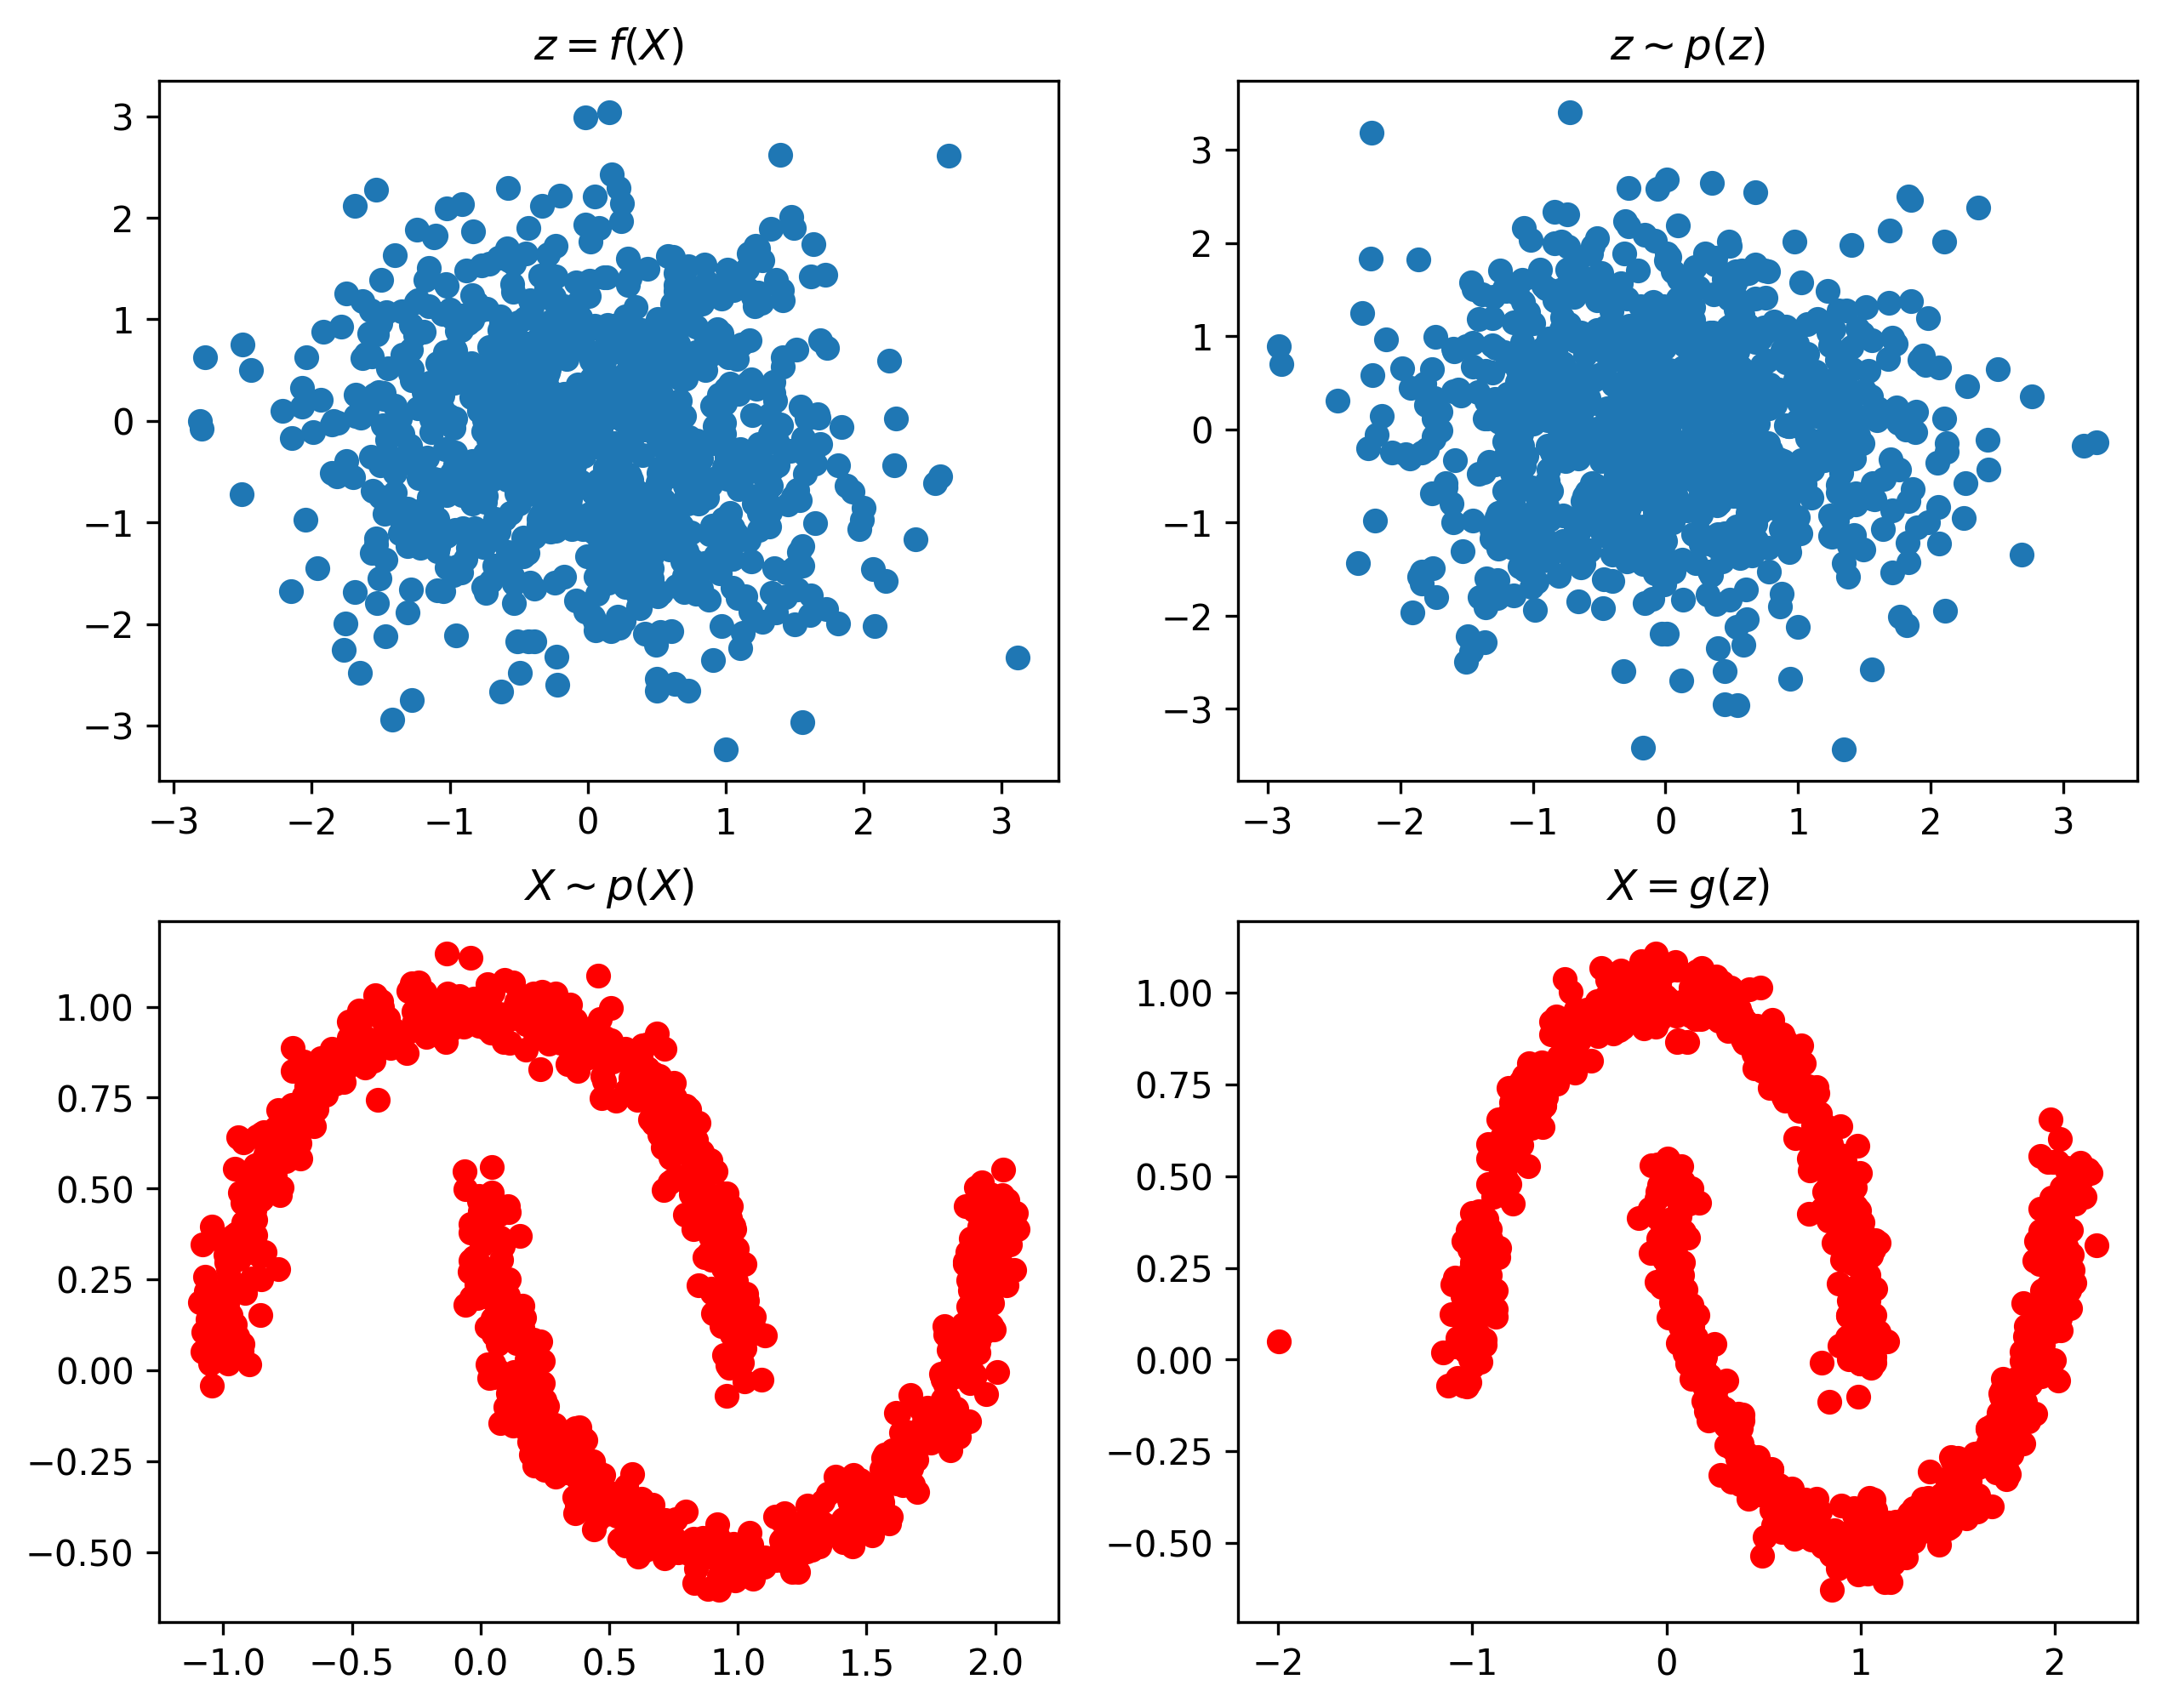

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=7, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.946
iter 500: loss = 0.757
iter 1000: loss = 0.475
iter 1500: loss = 0.514
iter 2000: loss = 0.558
iter 2500: loss = 0.349
iter 3000: loss = 0.465
iter 3500: loss = 0.304
iter 4000: loss = 0.423
iter 4500: loss = 0.372
iter 5000: loss = 0.519
CPU times: user 49min 2s, sys: 7.83 s, total: 49min 10s
Wall time: 49min 8s


Text(0.5, 1.0, '$X = g(z)$')

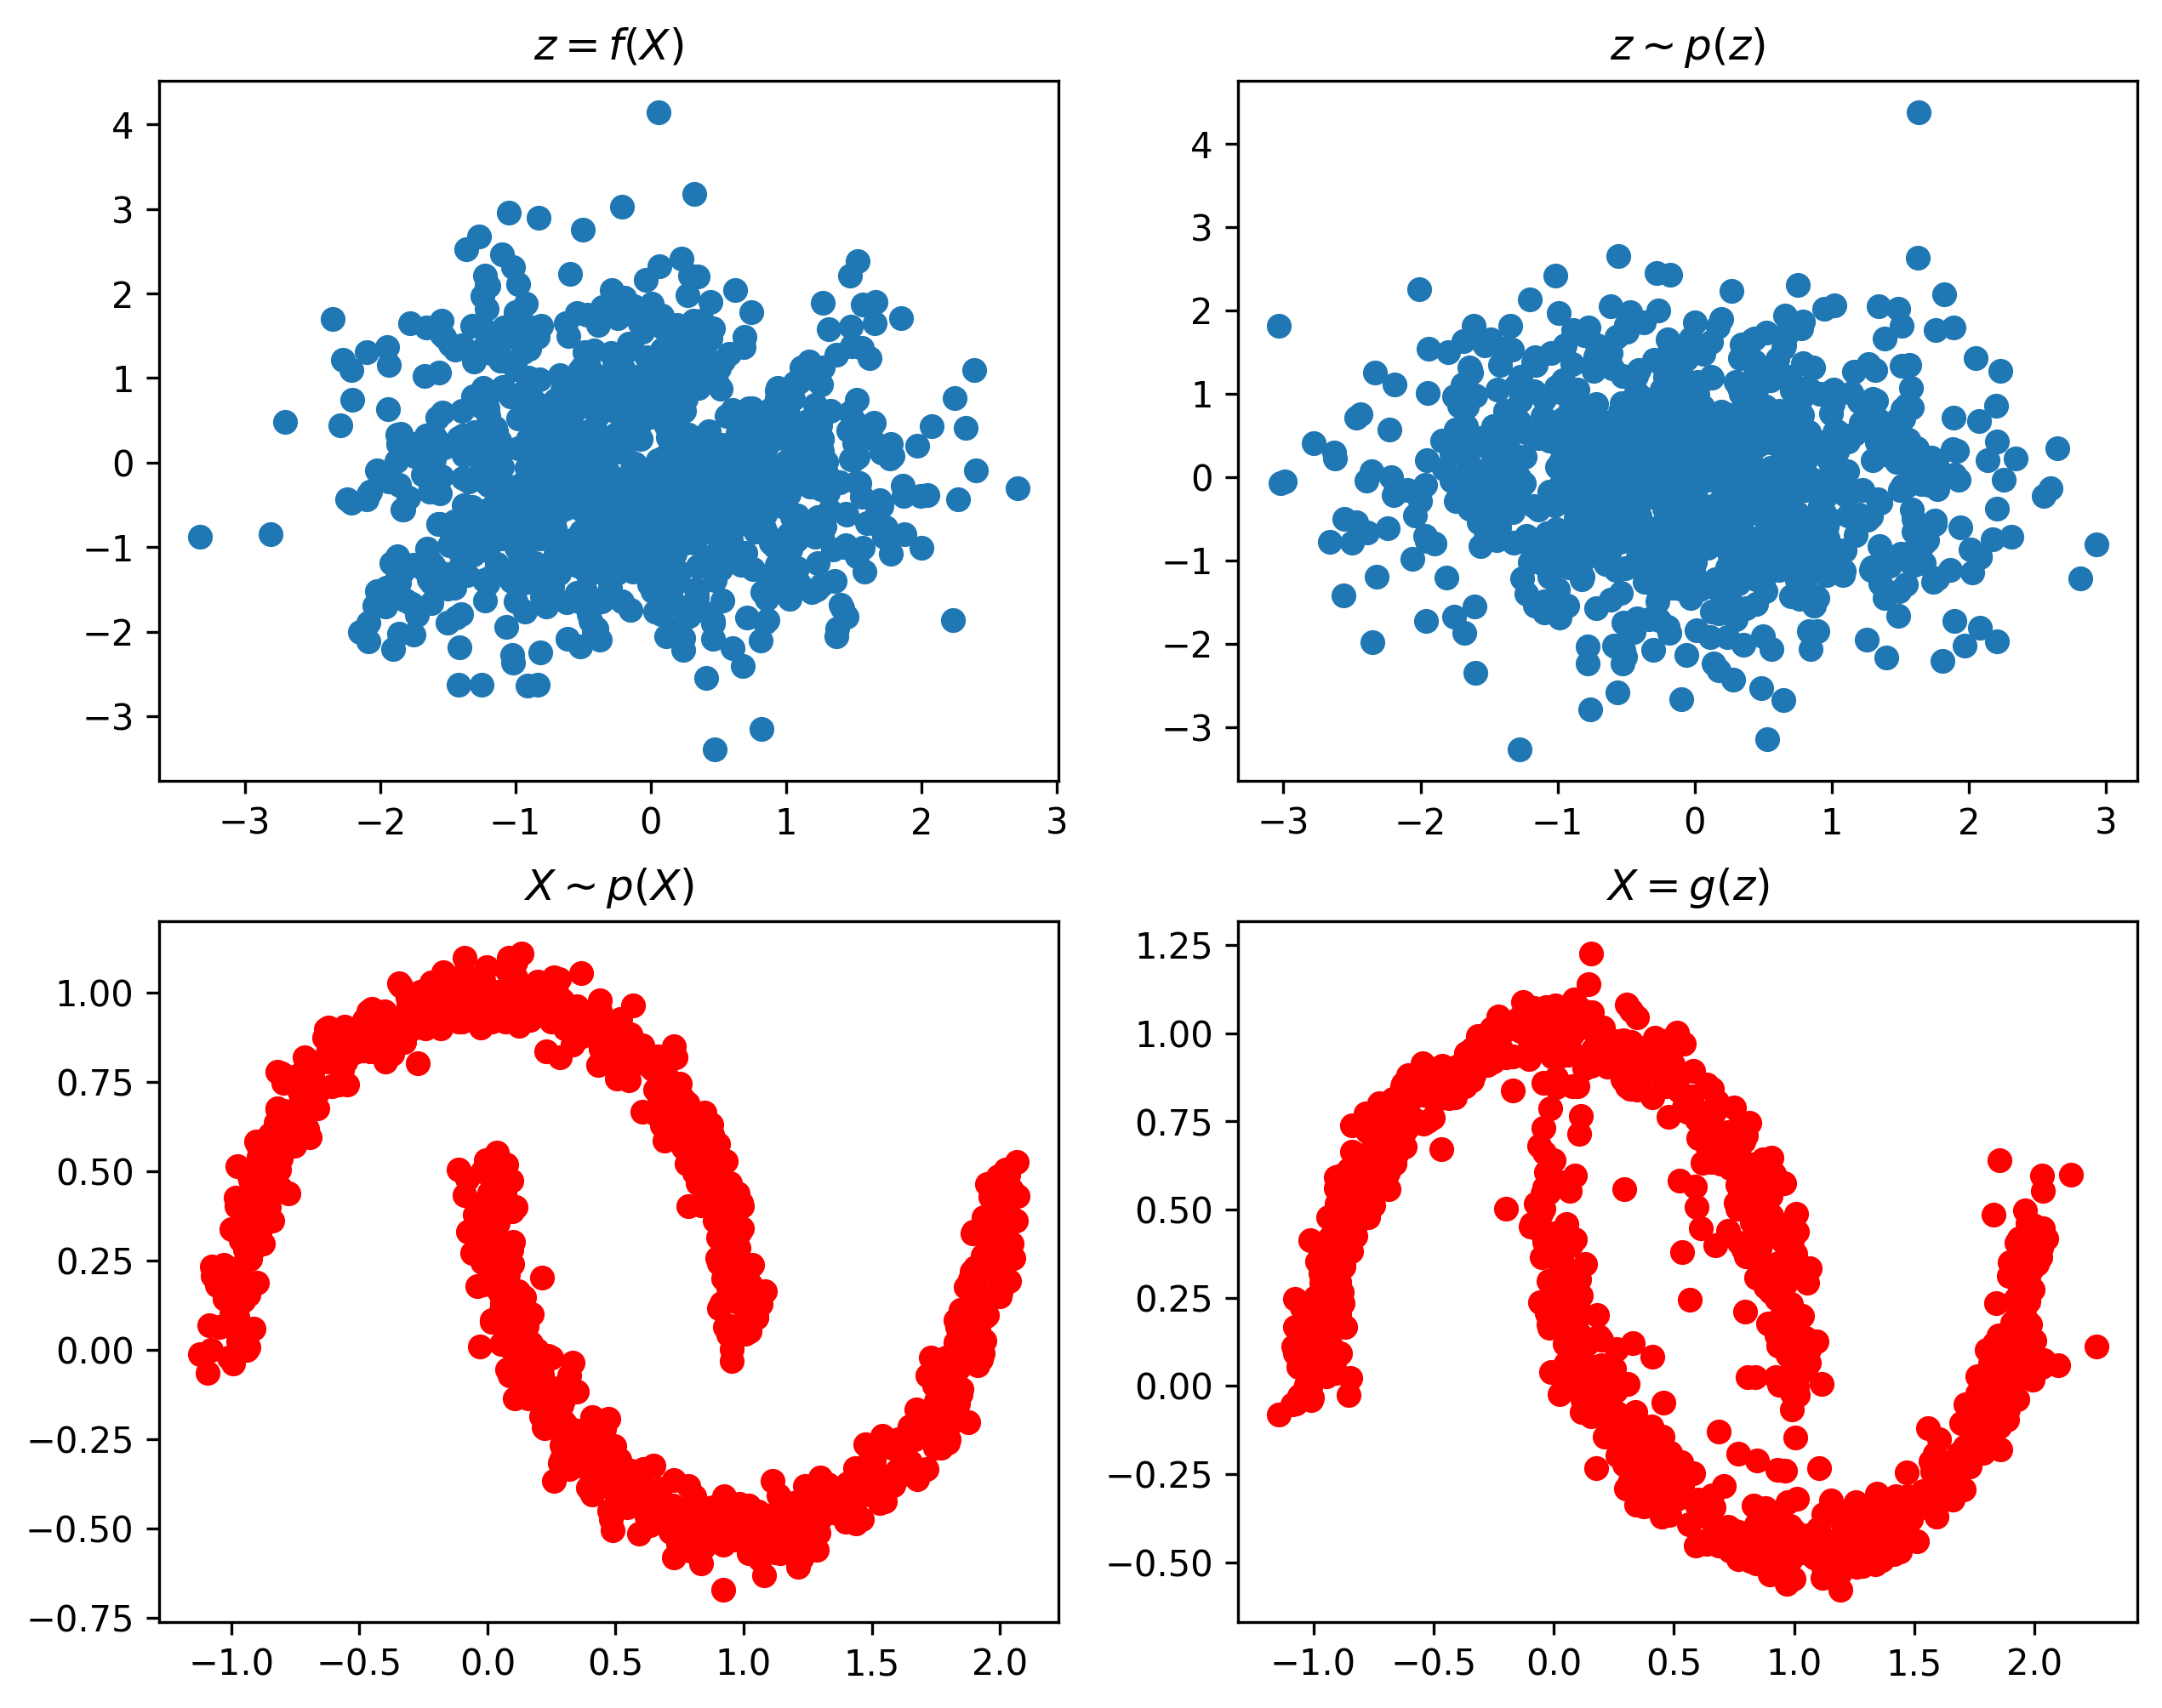

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=10, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 3.017
iter 500: loss = 0.696
iter 1000: loss = 0.466
iter 1500: loss = 0.503
iter 2000: loss = 0.487
iter 2500: loss = 0.497
iter 3000: loss = 0.445
iter 3500: loss = 0.382
iter 4000: loss = 0.446
iter 4500: loss = 0.422
iter 5000: loss = 0.484
CPU times: user 1h 8min 10s, sys: 10.5 s, total: 1h 8min 20s
Wall time: 1h 8min 12s


Text(0.5, 1.0, '$X = g(z)$')

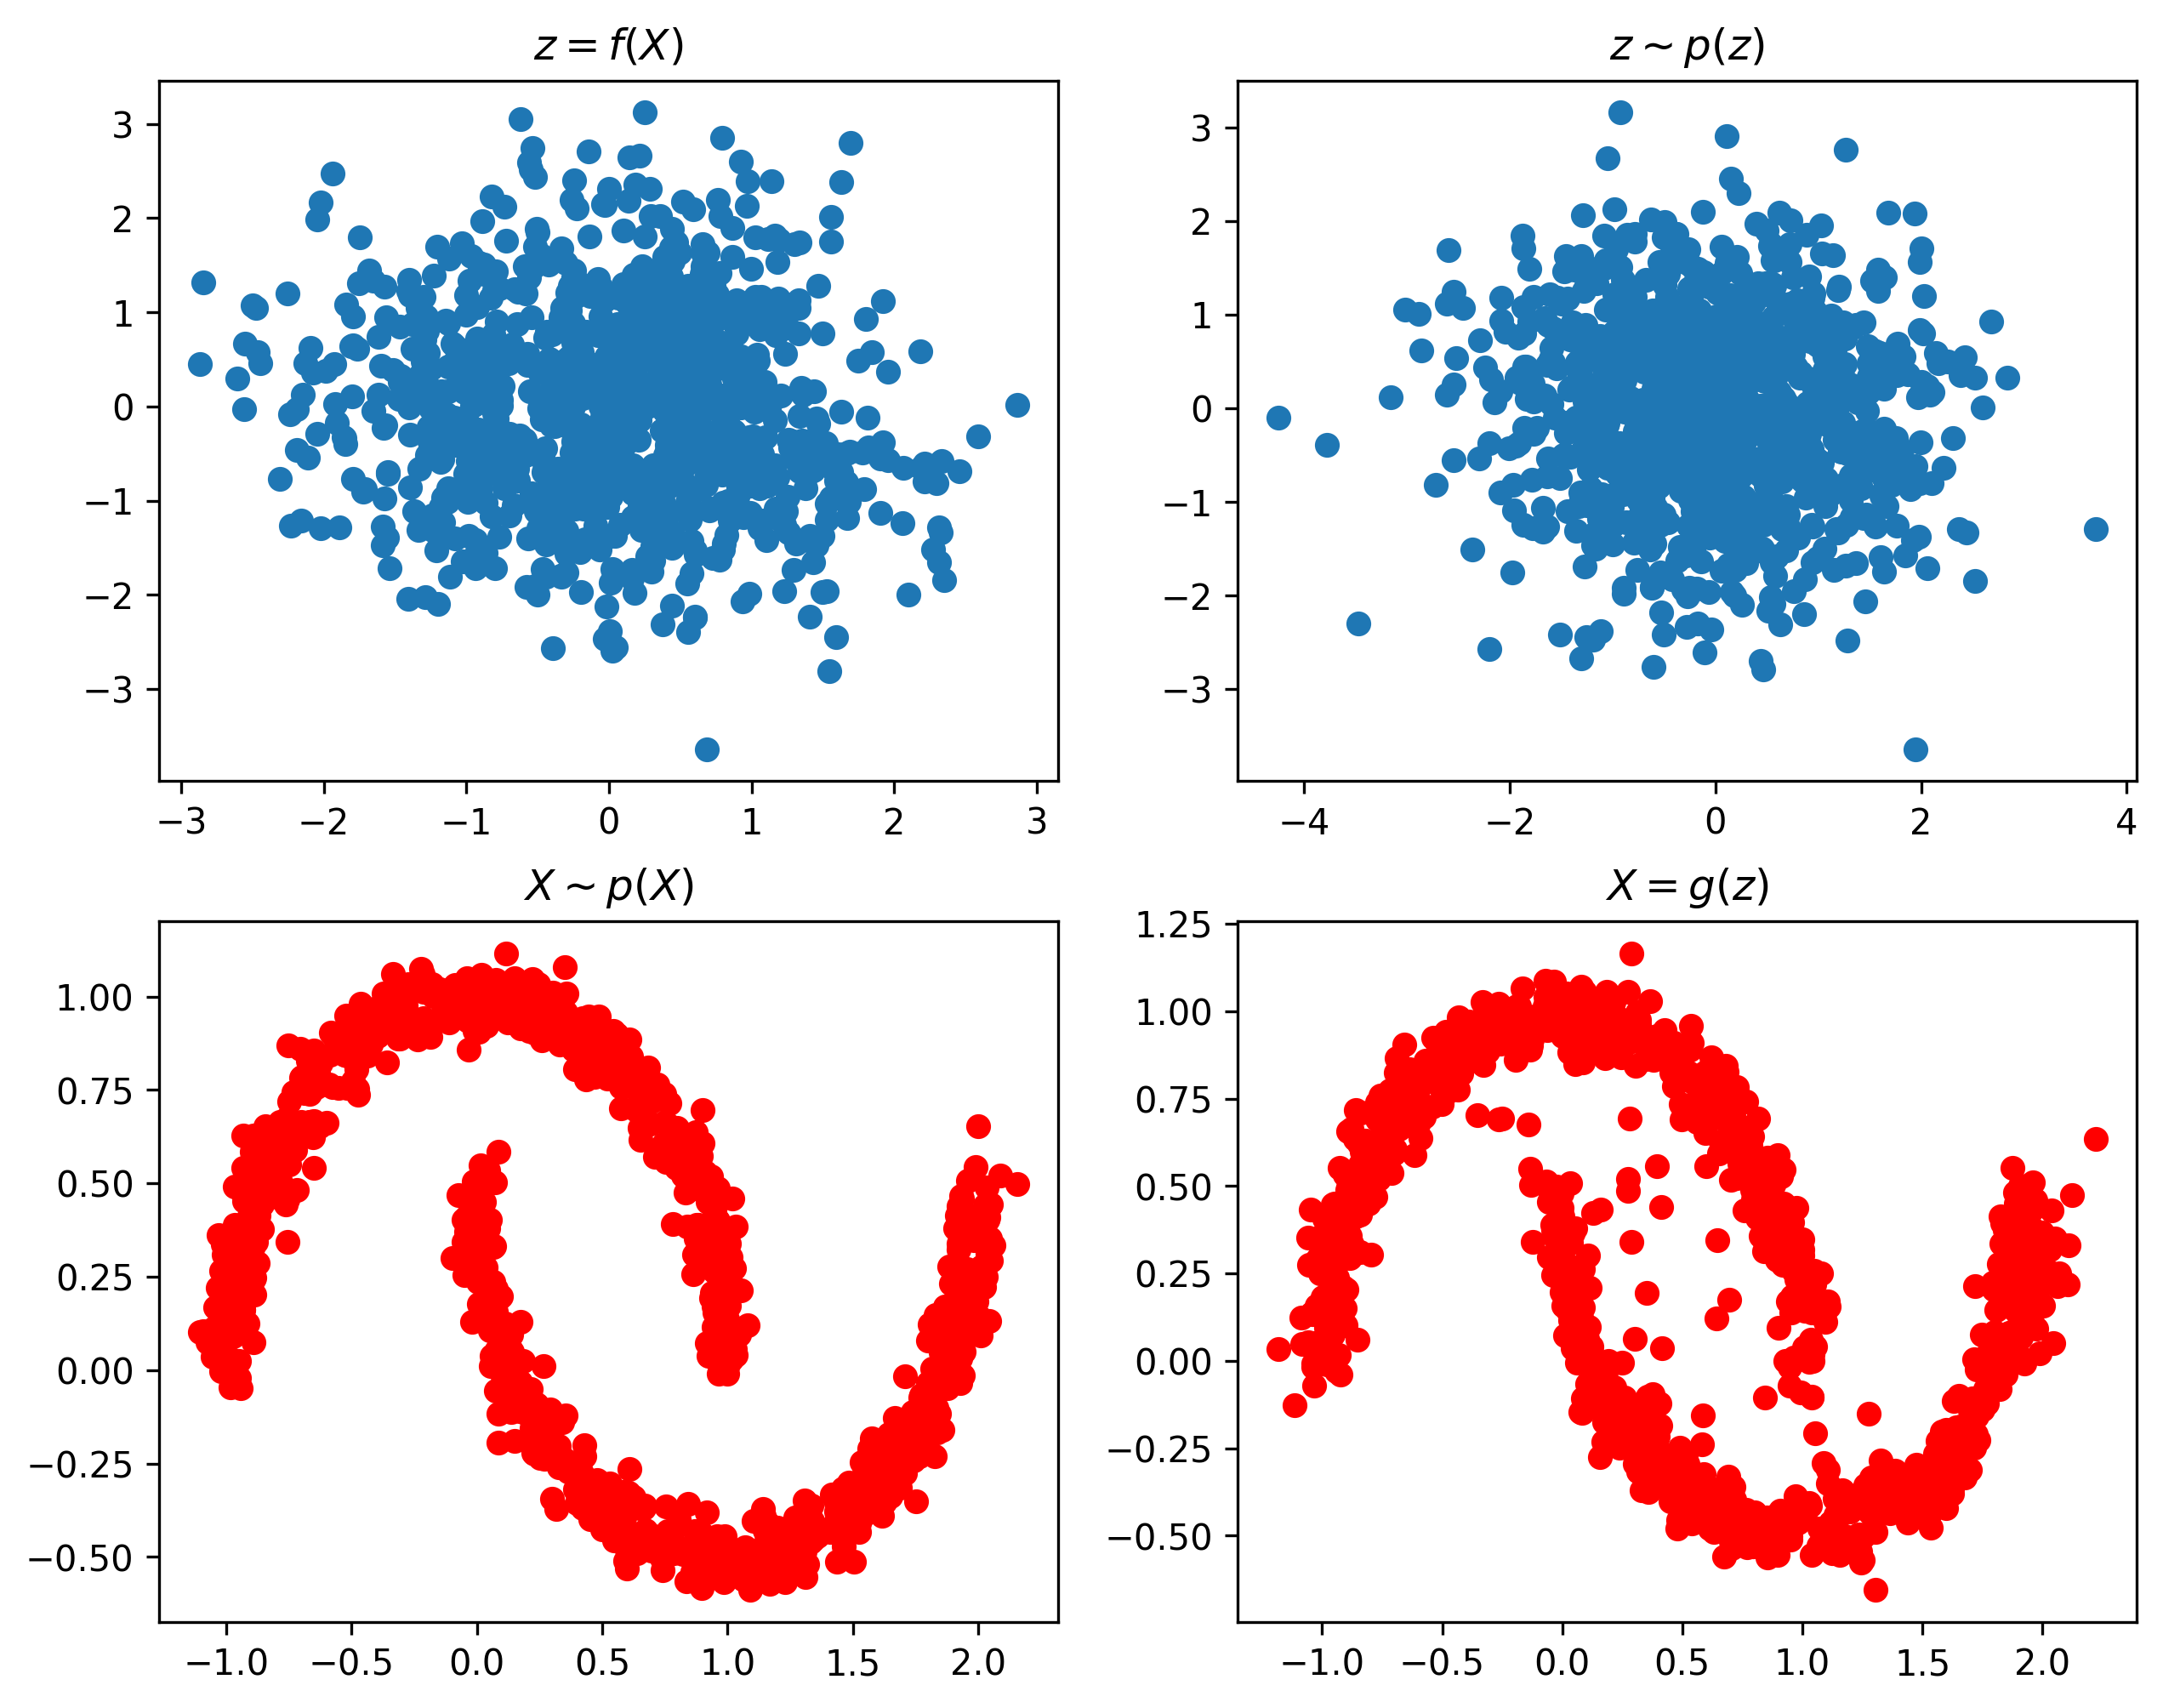

In [ ]:
plot_results(flow)

The results for 3 and 5 layers are very qualitative and similar to each other, for the 5 layers the result looks a little better, with a more even shape, but there is one outlier on it. Also, the values of the loss function for 5 layers are slightly lower. With more than 5 layers, the quality of generation decreases. This can probably be overcome by increasing the number of training epochs and changing the parameters of the optimizer, since the complexity of the model increases with the increase in the number of linear layers. Also, the increase in the number of linear layers significantly increases the model training time.

As the best value for the number of linear layers, we will then use the value of 5.

Let's now consider the effect of the activation function type on the generation result.

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.ReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.856
iter 500: loss = 0.412
iter 1000: loss = 0.521
iter 1500: loss = 0.315
iter 2000: loss = 0.418
iter 2500: loss = 0.396
iter 3000: loss = 0.389
iter 3500: loss = 0.398
iter 4000: loss = 0.393
iter 4500: loss = 0.501
iter 5000: loss = 0.437
CPU times: user 38min 3s, sys: 5.73 s, total: 38min 8s
Wall time: 38min 50s


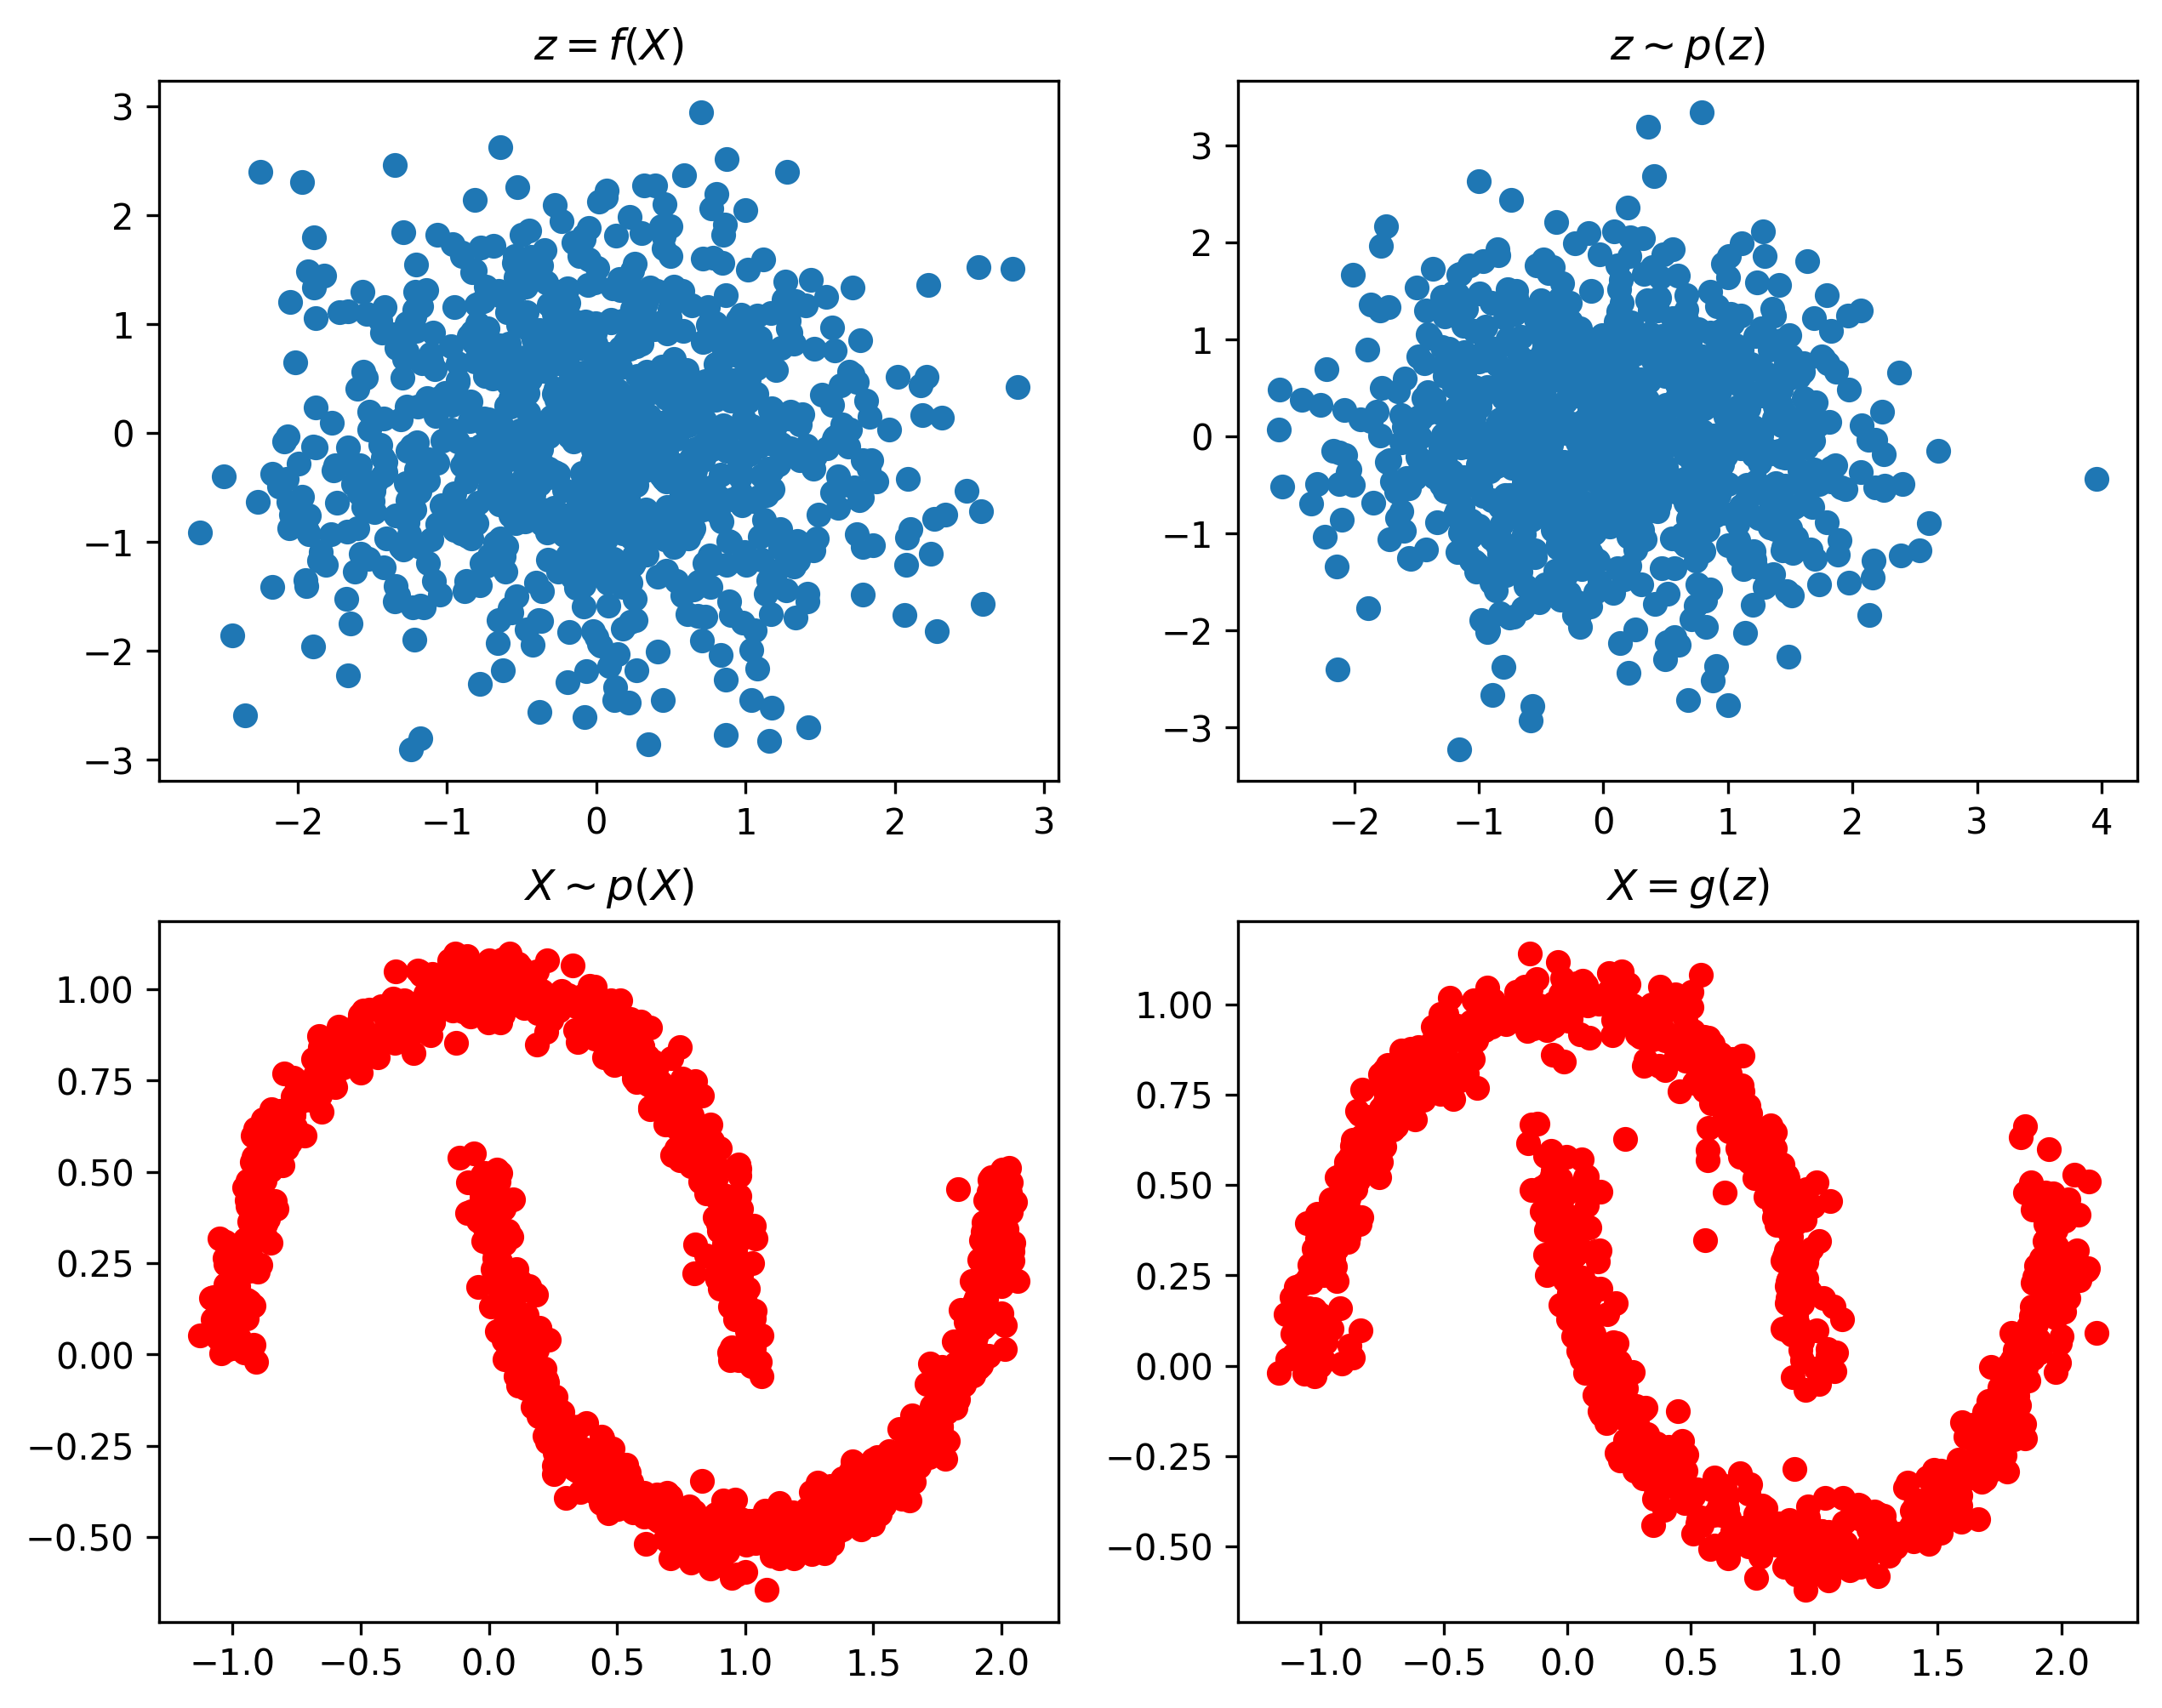

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.Tanh, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.401
iter 500: loss = 0.520
iter 1000: loss = 0.440
iter 1500: loss = 0.530
iter 2000: loss = 0.481
iter 2500: loss = 0.416
iter 3000: loss = 0.493
iter 3500: loss = 0.358
iter 4000: loss = 0.600
iter 4500: loss = 0.417
iter 5000: loss = 0.340
CPU times: user 32min 59s, sys: 3.7 s, total: 33min 3s
Wall time: 33min 17s


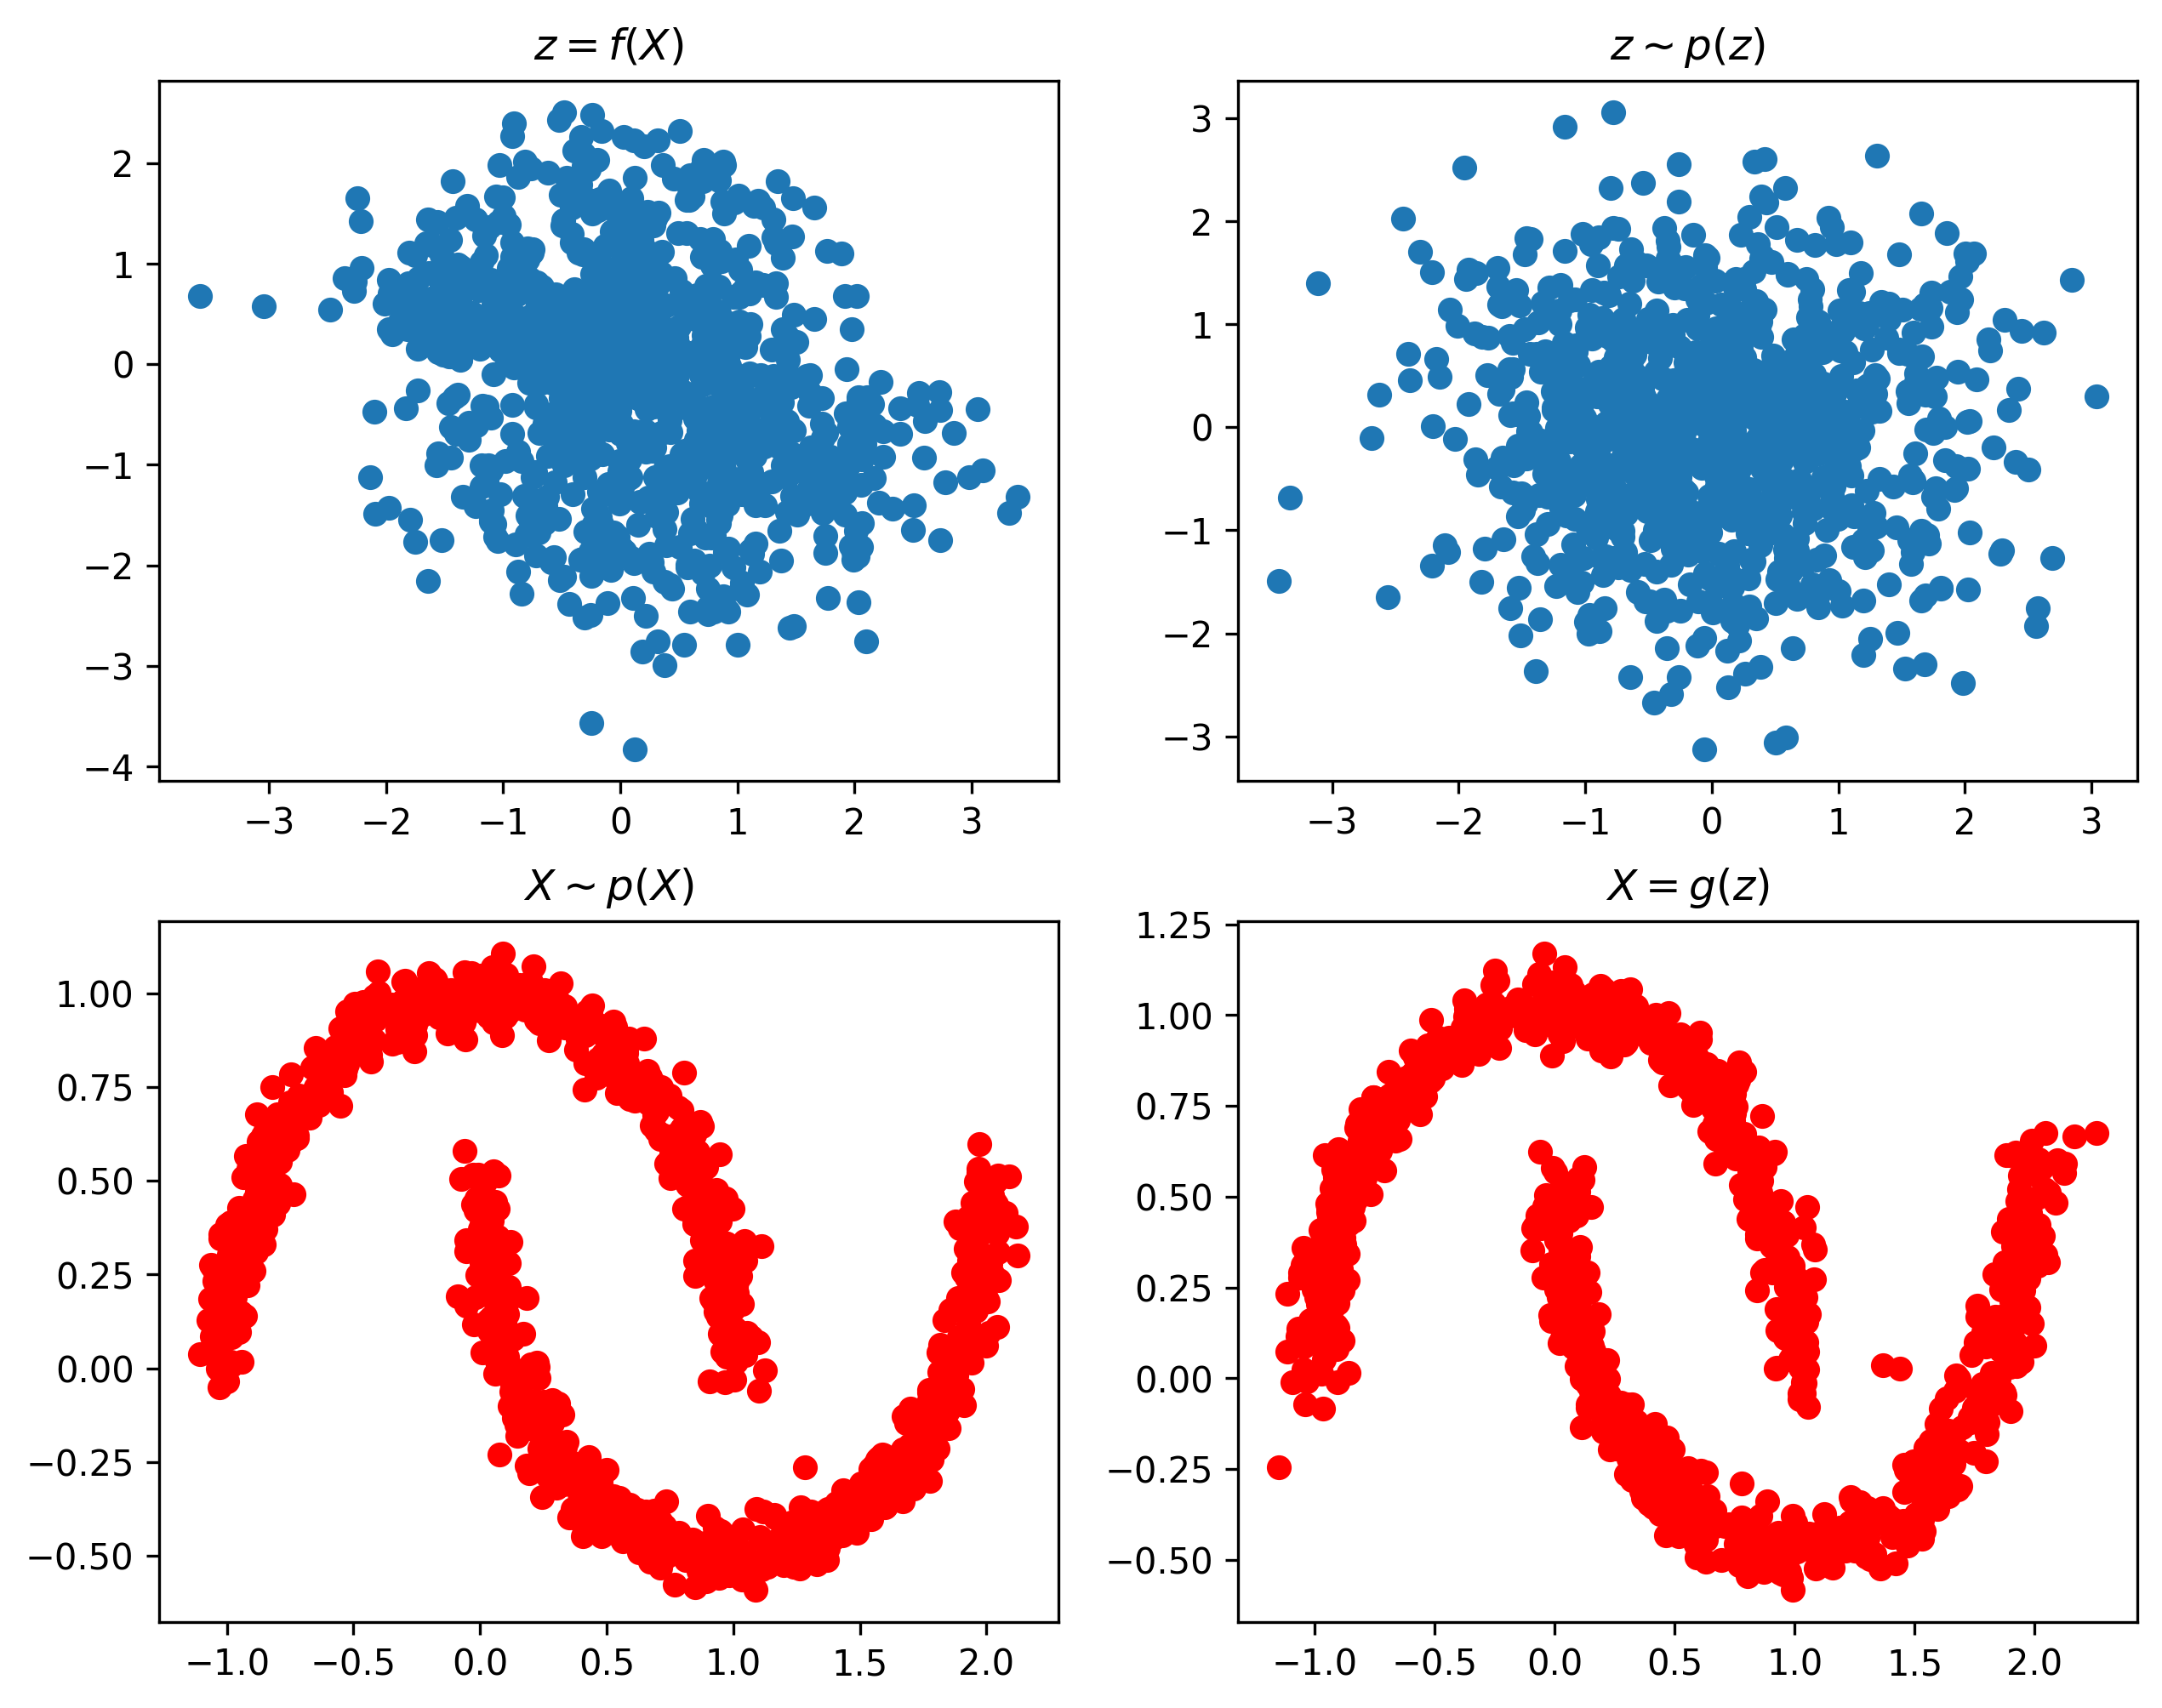

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.LeakyReLU, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.718
iter 500: loss = 0.562
iter 1000: loss = 0.646
iter 1500: loss = 0.526
iter 2000: loss = 0.475
iter 2500: loss = 0.403
iter 3000: loss = 0.423
iter 3500: loss = 0.561
iter 4000: loss = 0.437
iter 4500: loss = 0.491
iter 5000: loss = 0.465
CPU times: user 32min 8s, sys: 3.7 s, total: 32min 12s
Wall time: 32min 27s


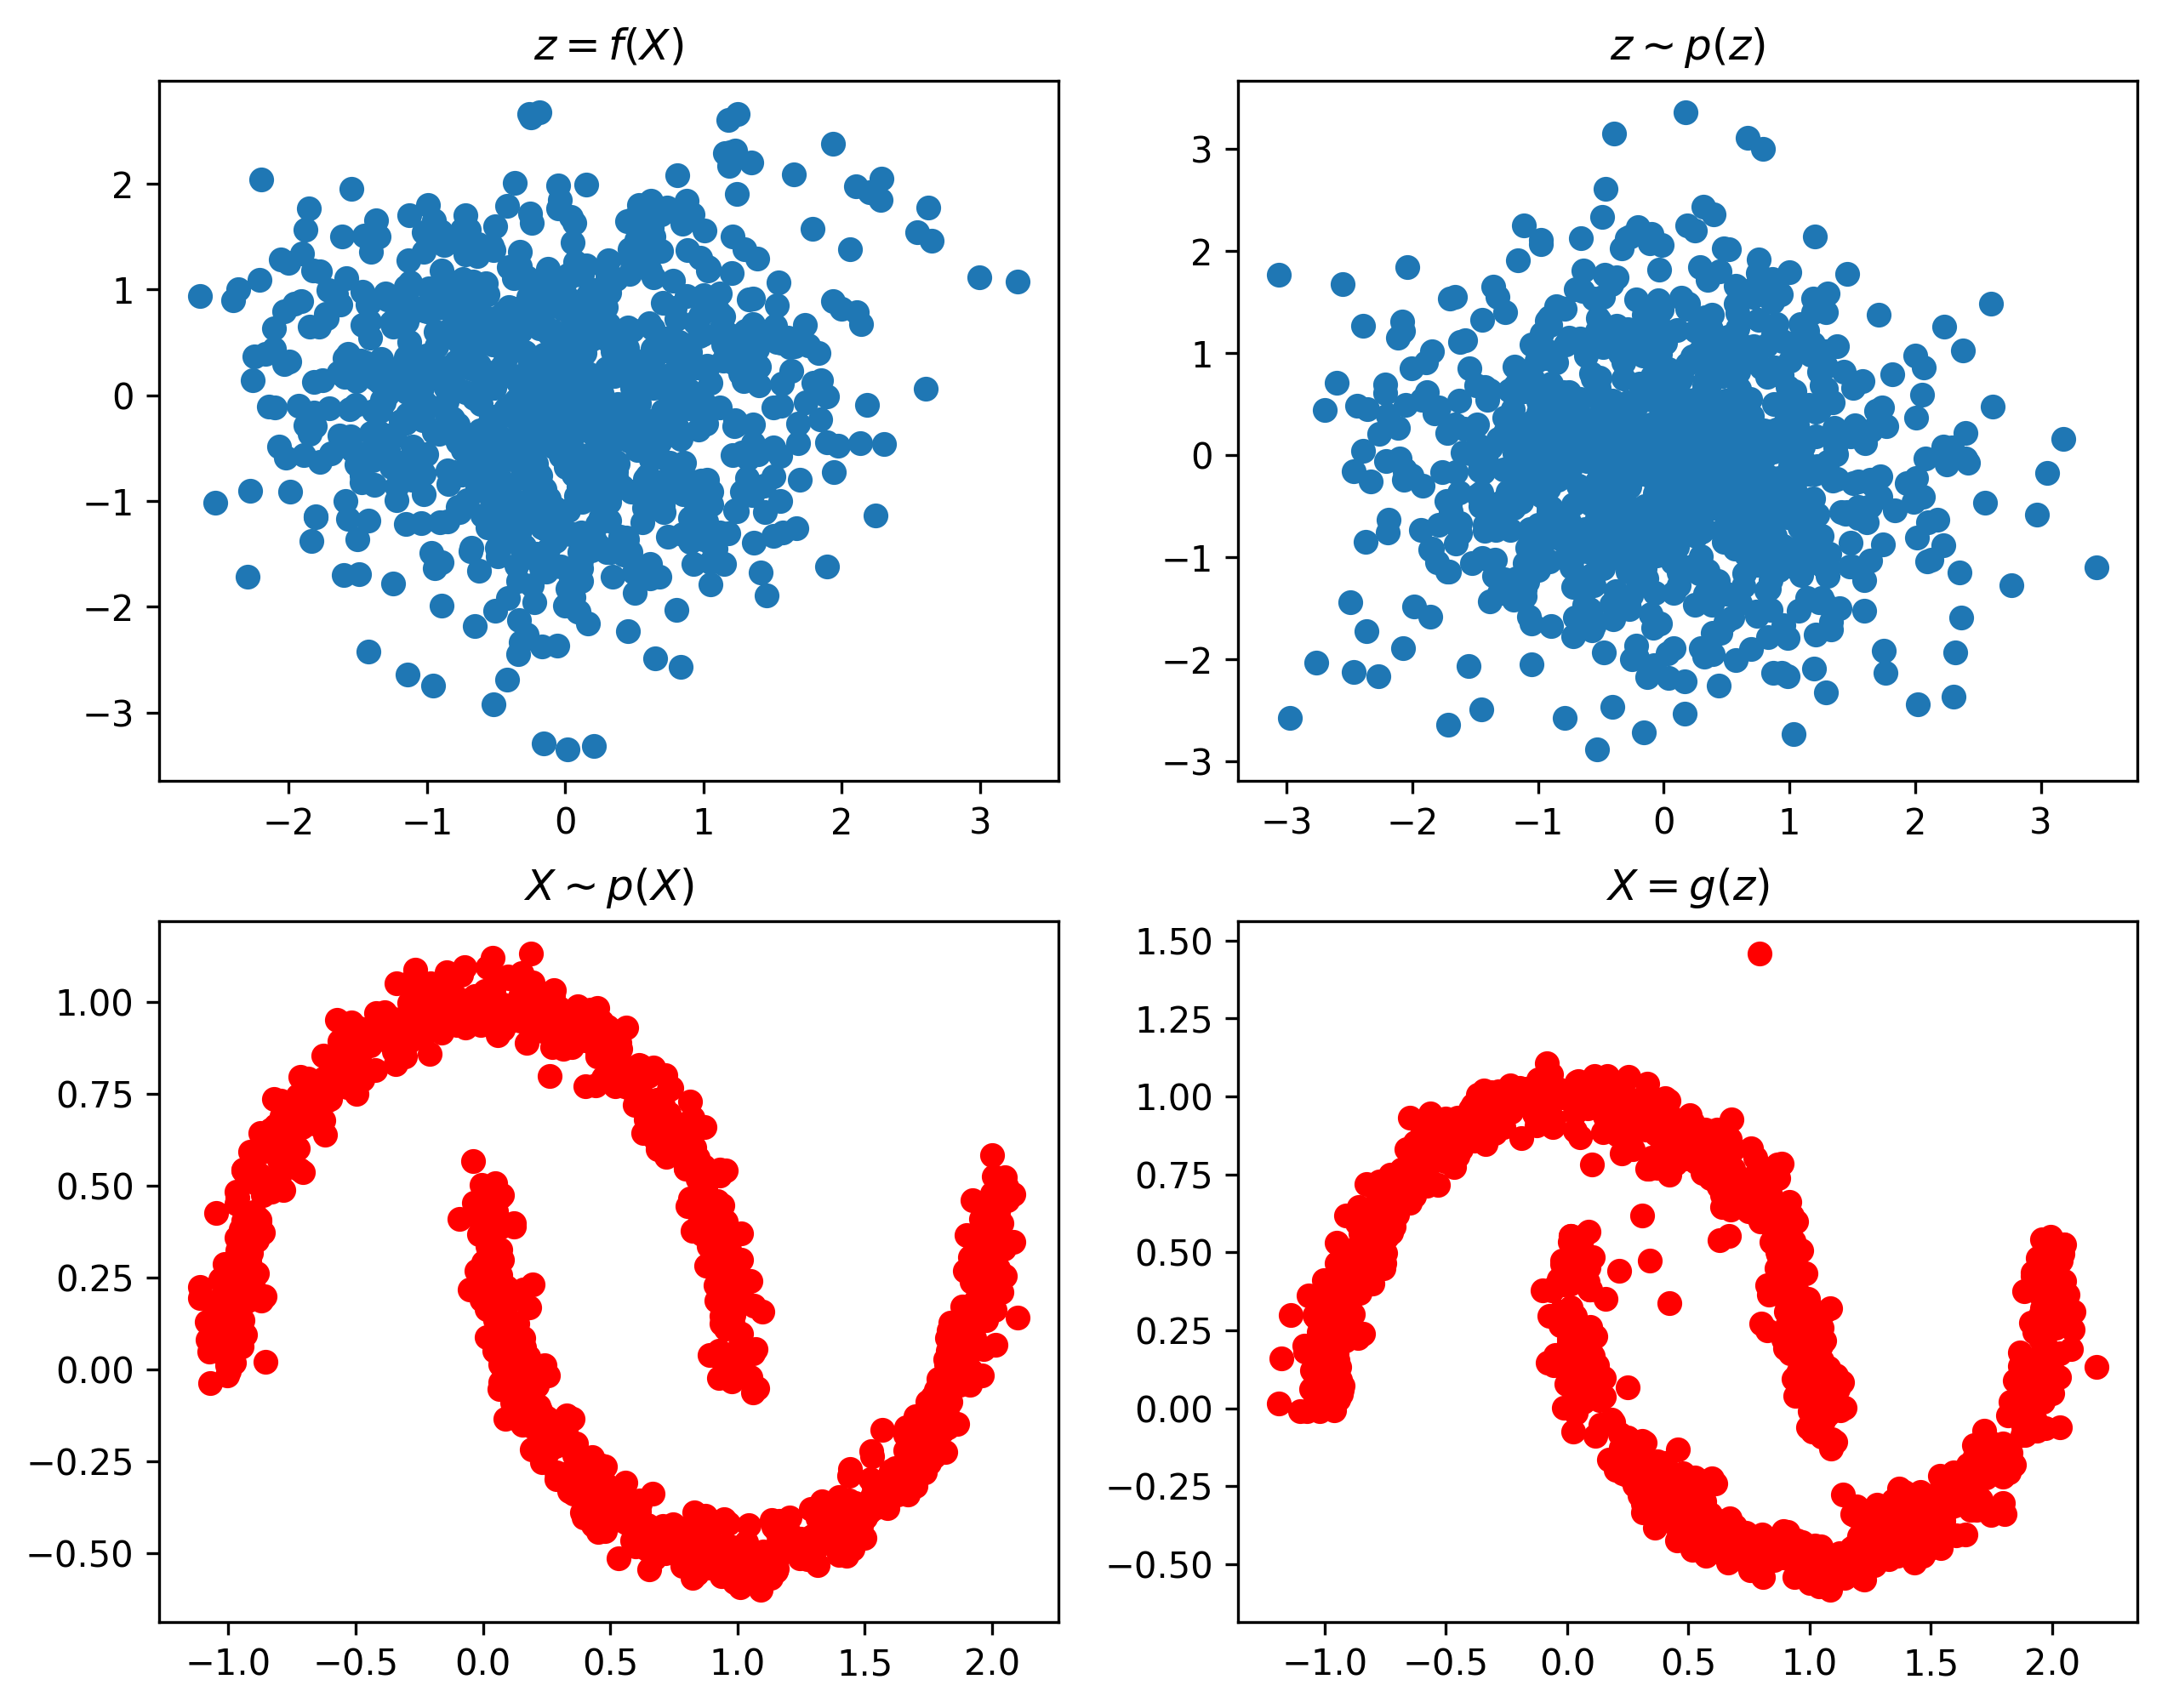

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.Sigmoid, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 21.313
iter 500: loss = 1.982
iter 1000: loss = 1.848
iter 1500: loss = 1.700
iter 2000: loss = 1.645
iter 2500: loss = 1.524
iter 3000: loss = 1.535
iter 3500: loss = 1.433
iter 4000: loss = 1.355
iter 4500: loss = 1.342
iter 5000: loss = 1.433
CPU times: user 32min 13s, sys: 3.66 s, total: 32min 16s
Wall time: 32min 34s


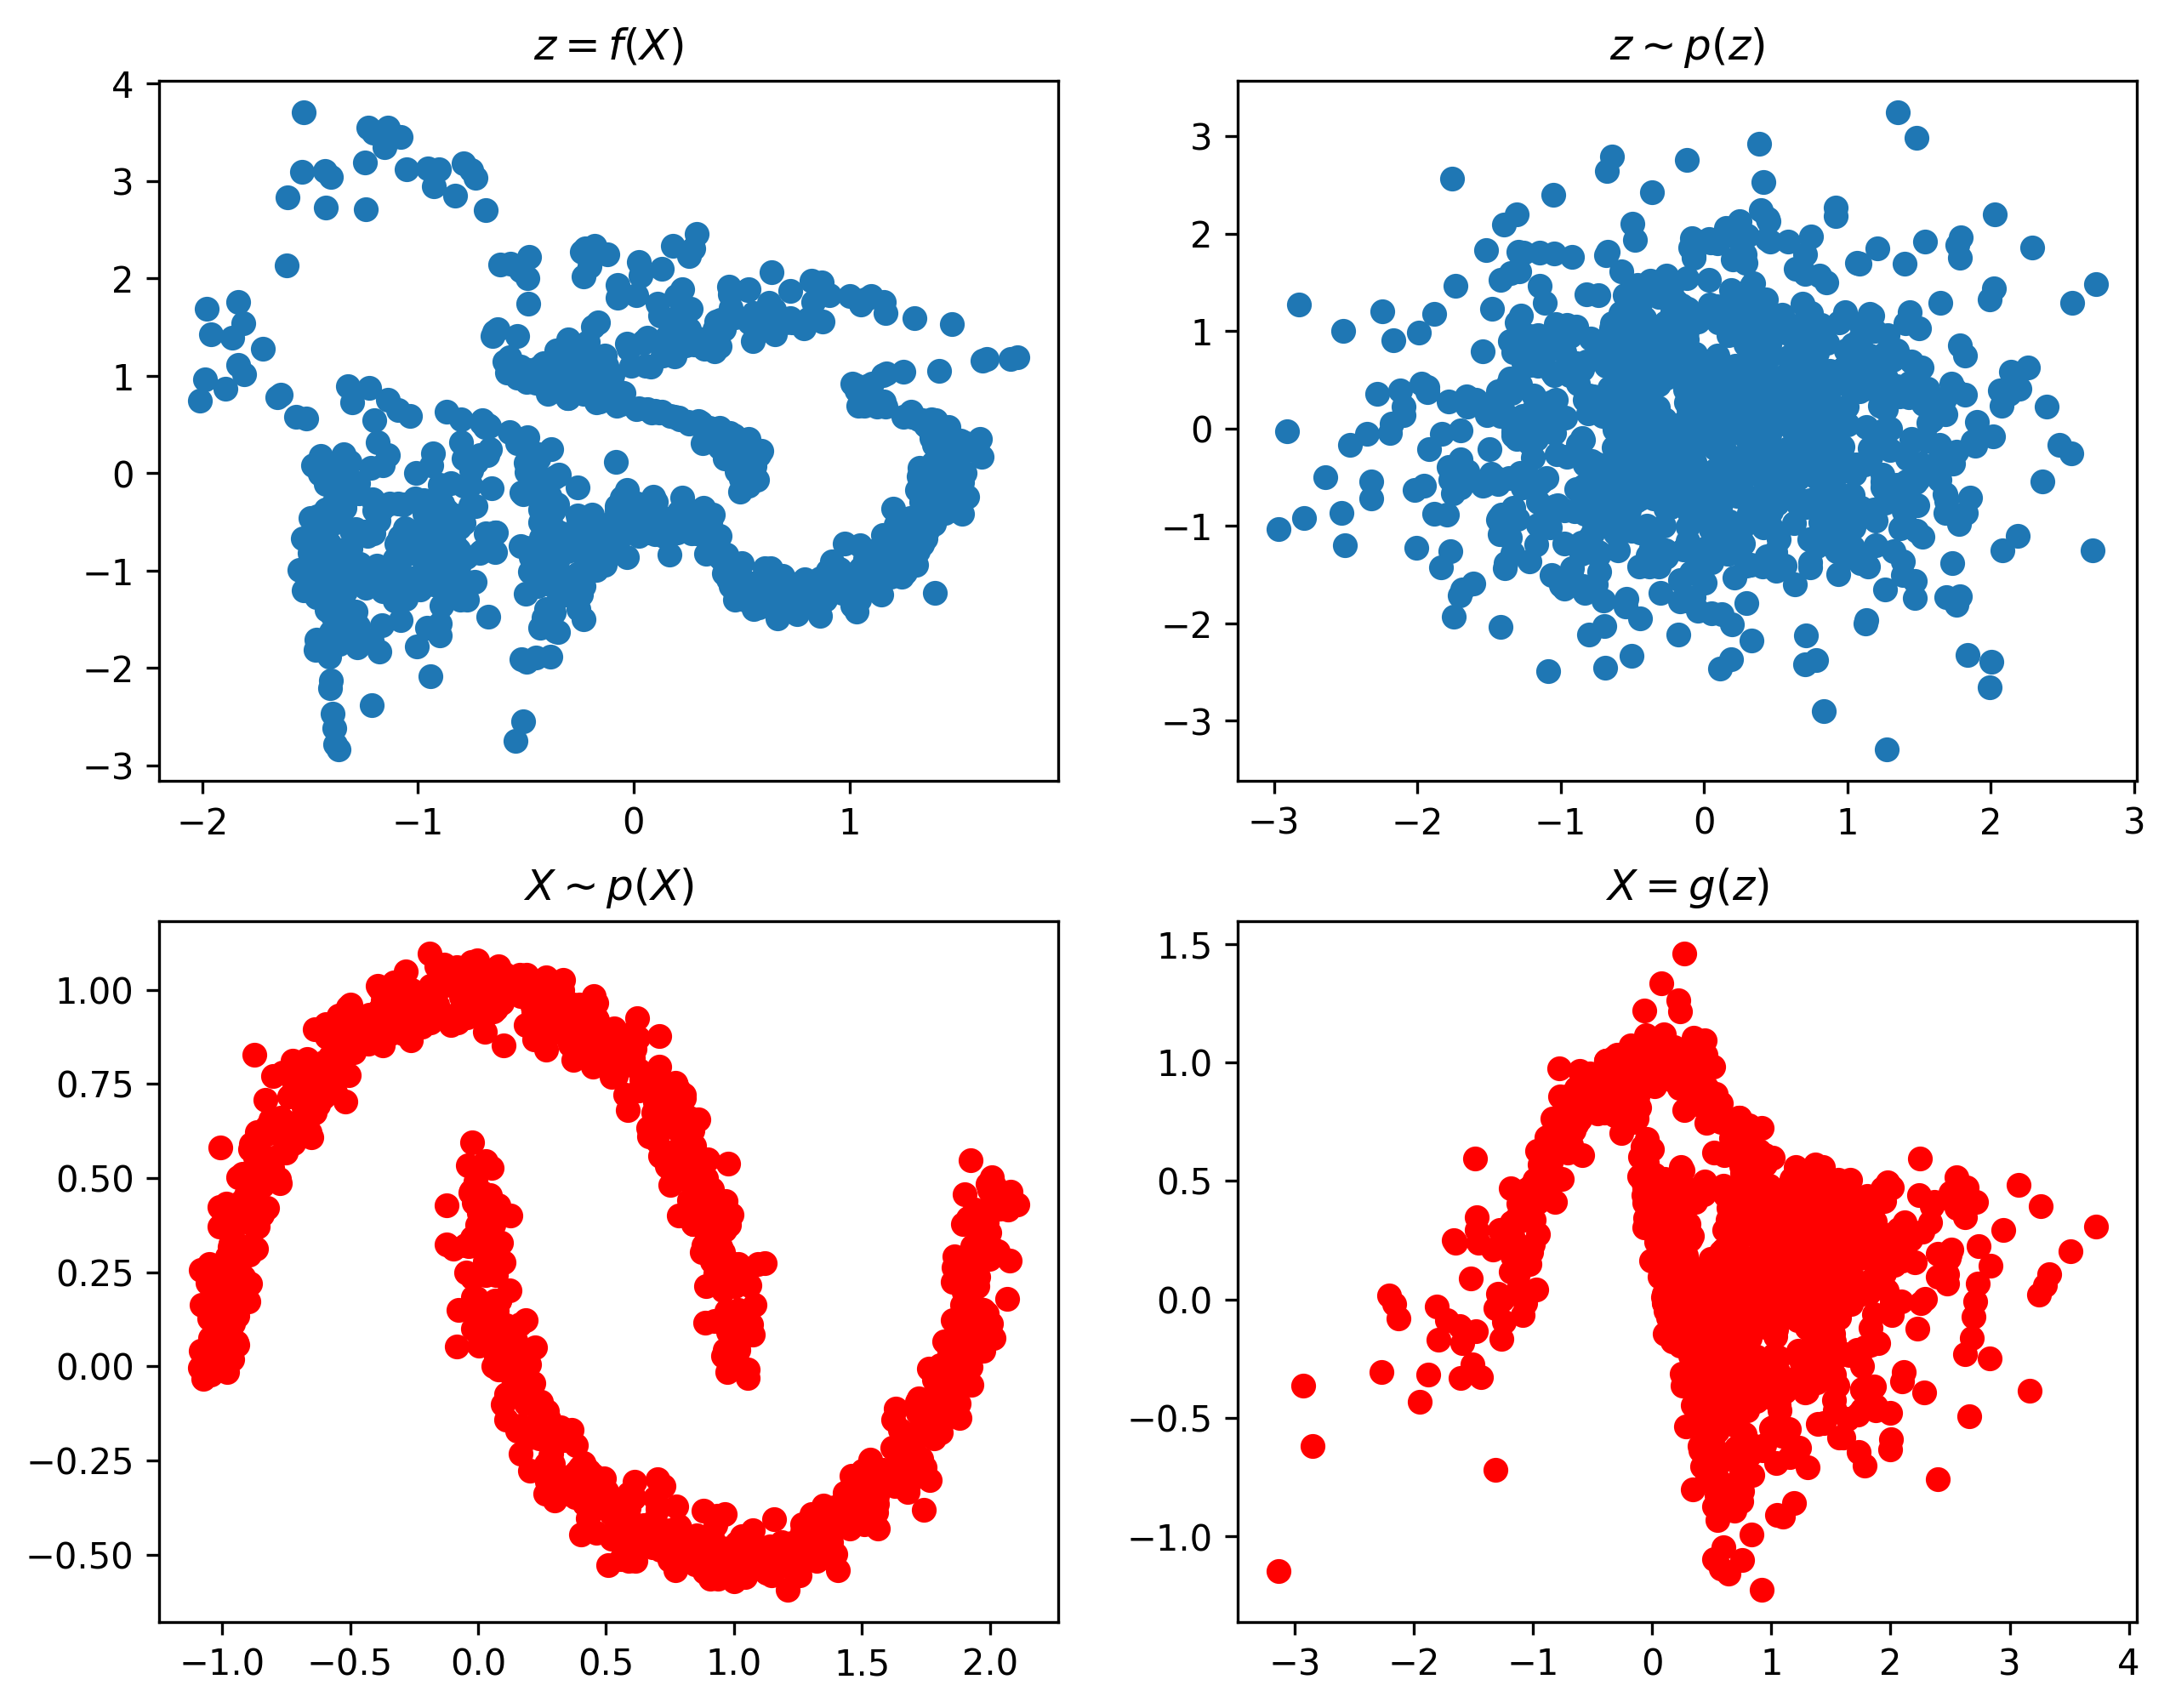

In [ ]:
plot_results(flow)

The highest quality generation result was obtained for the Tanh function, with almost no outliers and irregularities at the edges. The results for ReLU and LeakyReLU in general do not differ much, but for Sigmoid, data of completely unacceptably low quality is generated. The values of the loss function for all activations are similar, except for the Sigmoid, for which the loss is quite high and decreases very slowly. The training time does not depend on the type of nonlinearity function.

Next, we will use the Tanh function as giving the best generation results.

Next consider the influence of the hidden dimension on the quality of the result.

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=32, n_layers=5, nonlinearity=torch.nn.Tanh, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 3.210
iter 500: loss = 1.031
iter 1000: loss = 0.752
iter 1500: loss = 0.694
iter 2000: loss = 0.793
iter 2500: loss = 0.375
iter 3000: loss = 0.347
iter 3500: loss = 0.477
iter 4000: loss = 0.636
iter 4500: loss = 0.369
iter 5000: loss = 0.396
CPU times: user 16min 26s, sys: 2.05 s, total: 16min 28s
Wall time: 17min 5s


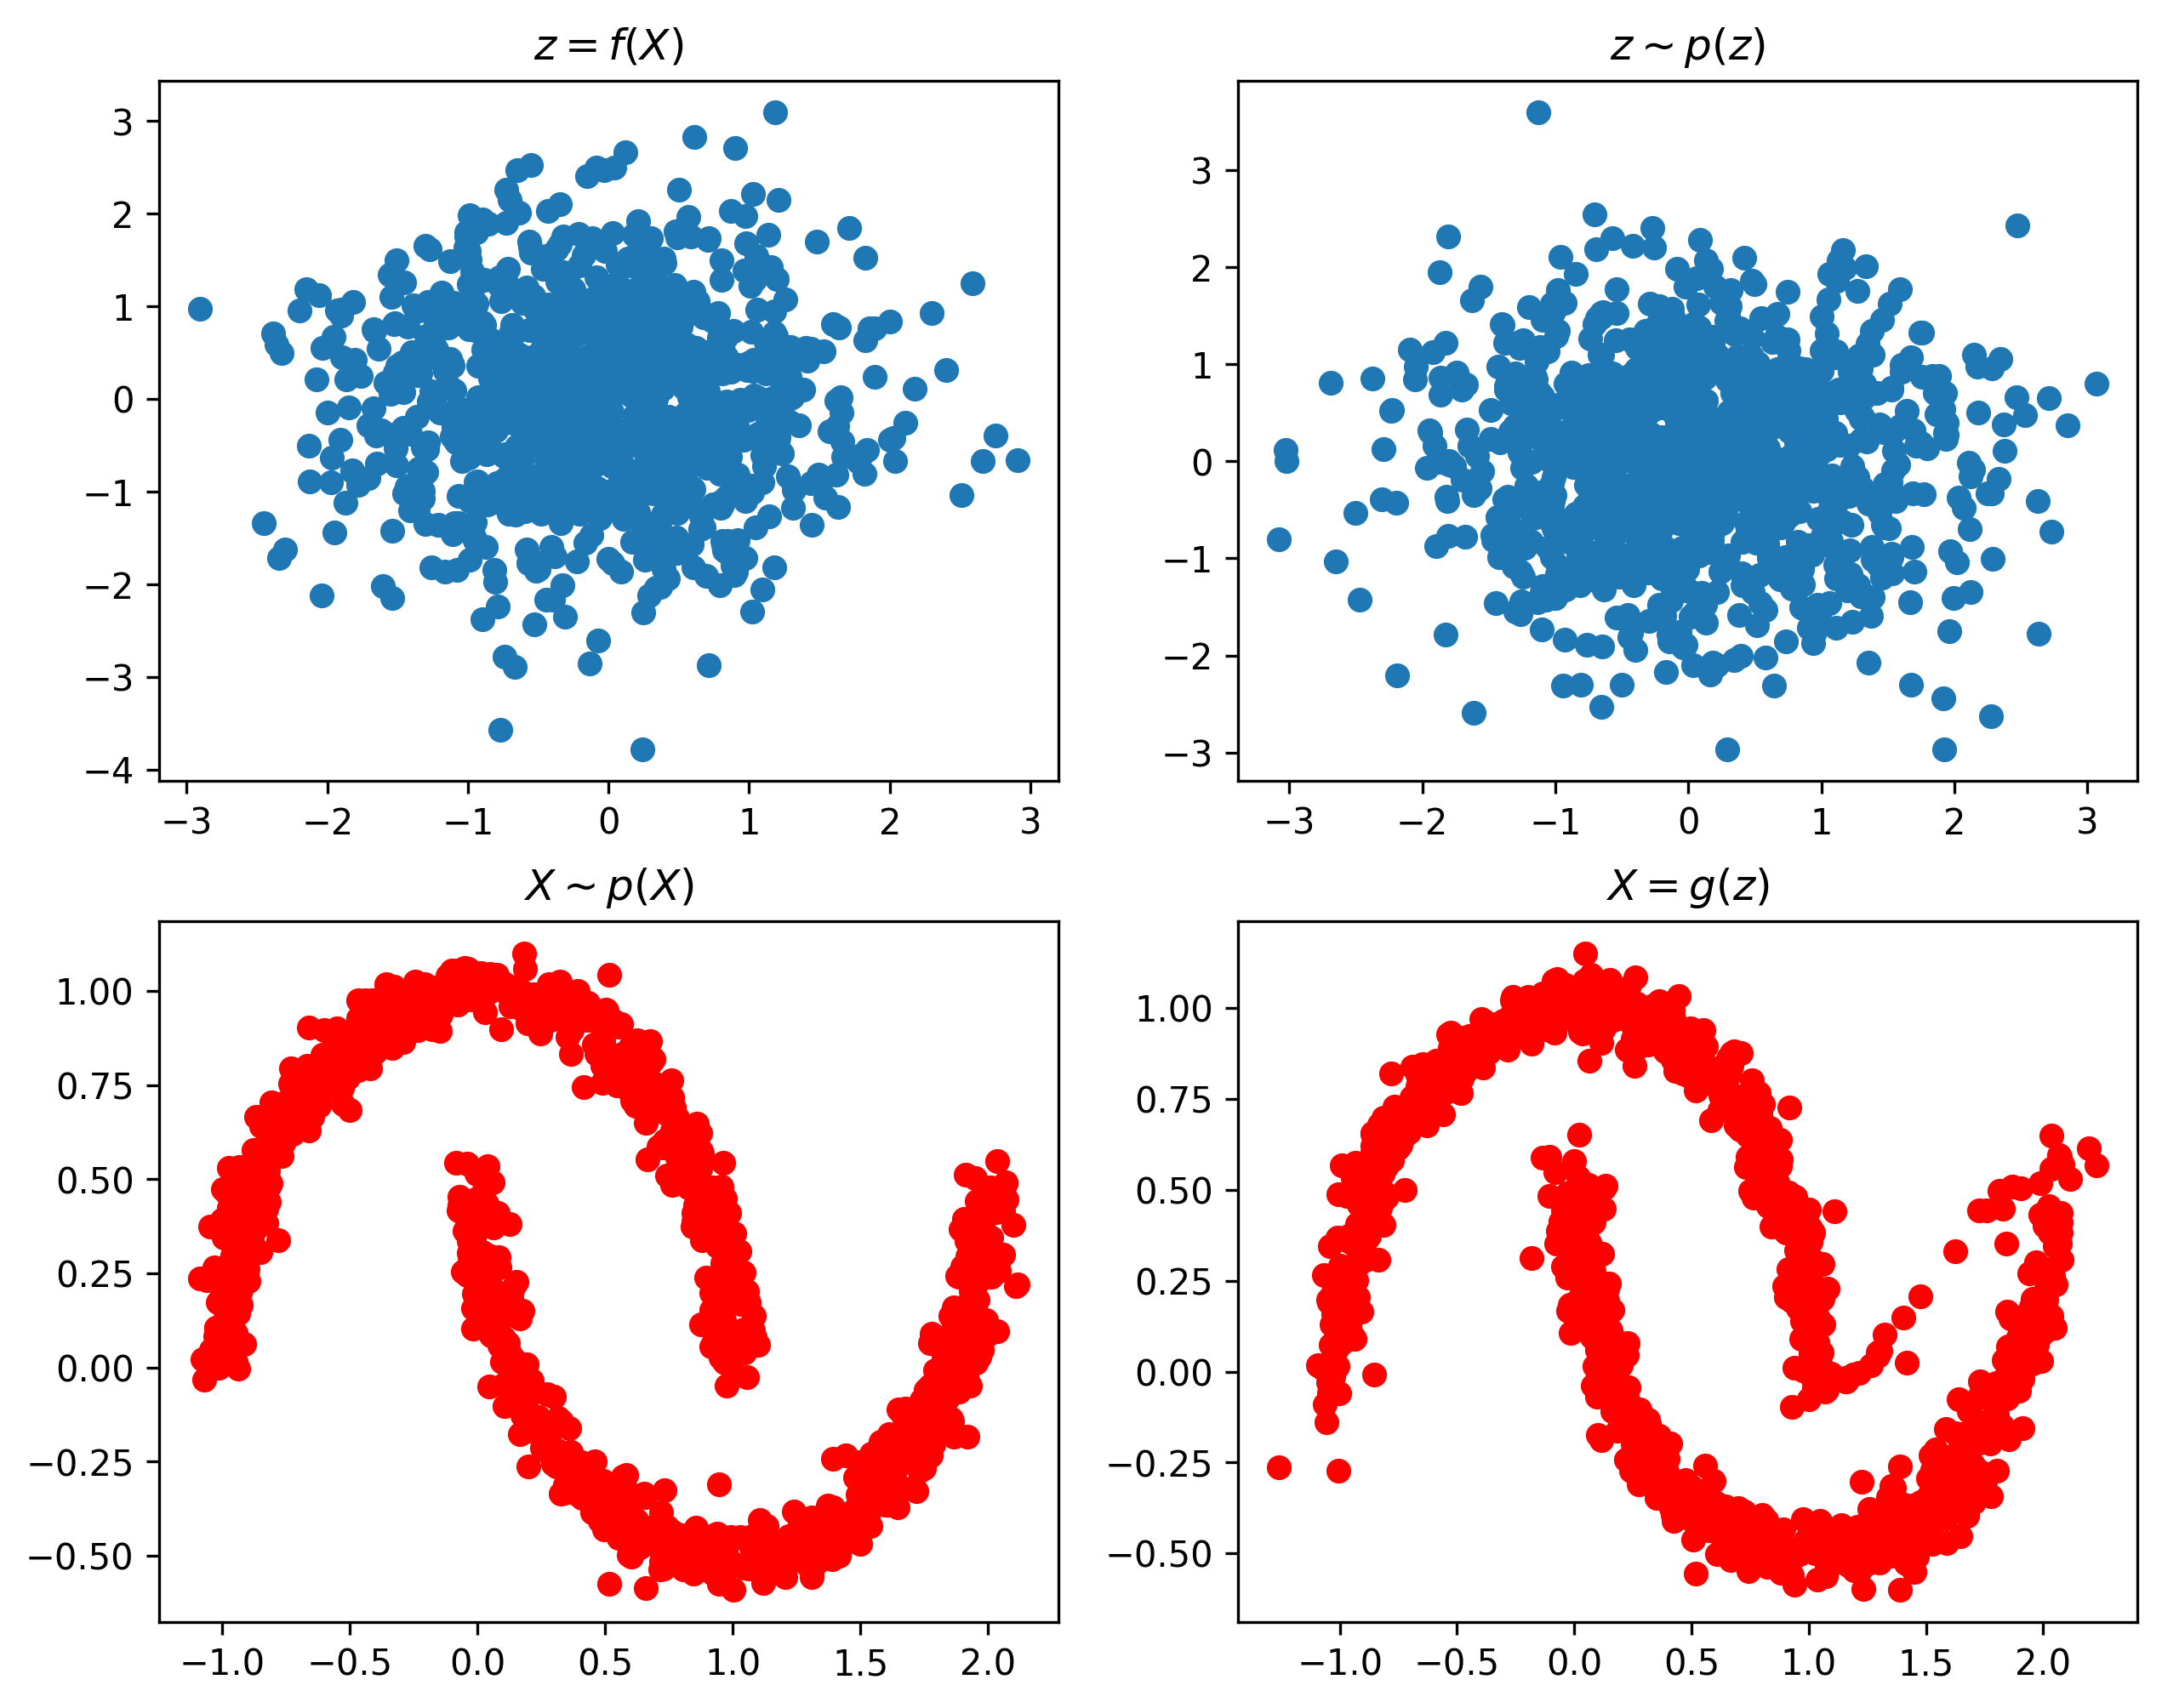

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=64, n_layers=5, nonlinearity=torch.nn.Tanh, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 3.798
iter 500: loss = 0.450
iter 1000: loss = 0.348
iter 1500: loss = 0.381
iter 2000: loss = 0.528
iter 2500: loss = 0.414
iter 3000: loss = 0.385
iter 3500: loss = 0.355
iter 4000: loss = 0.297
iter 4500: loss = 0.416
iter 5000: loss = 0.490
CPU times: user 19min 36s, sys: 2.49 s, total: 19min 38s
Wall time: 19min 45s


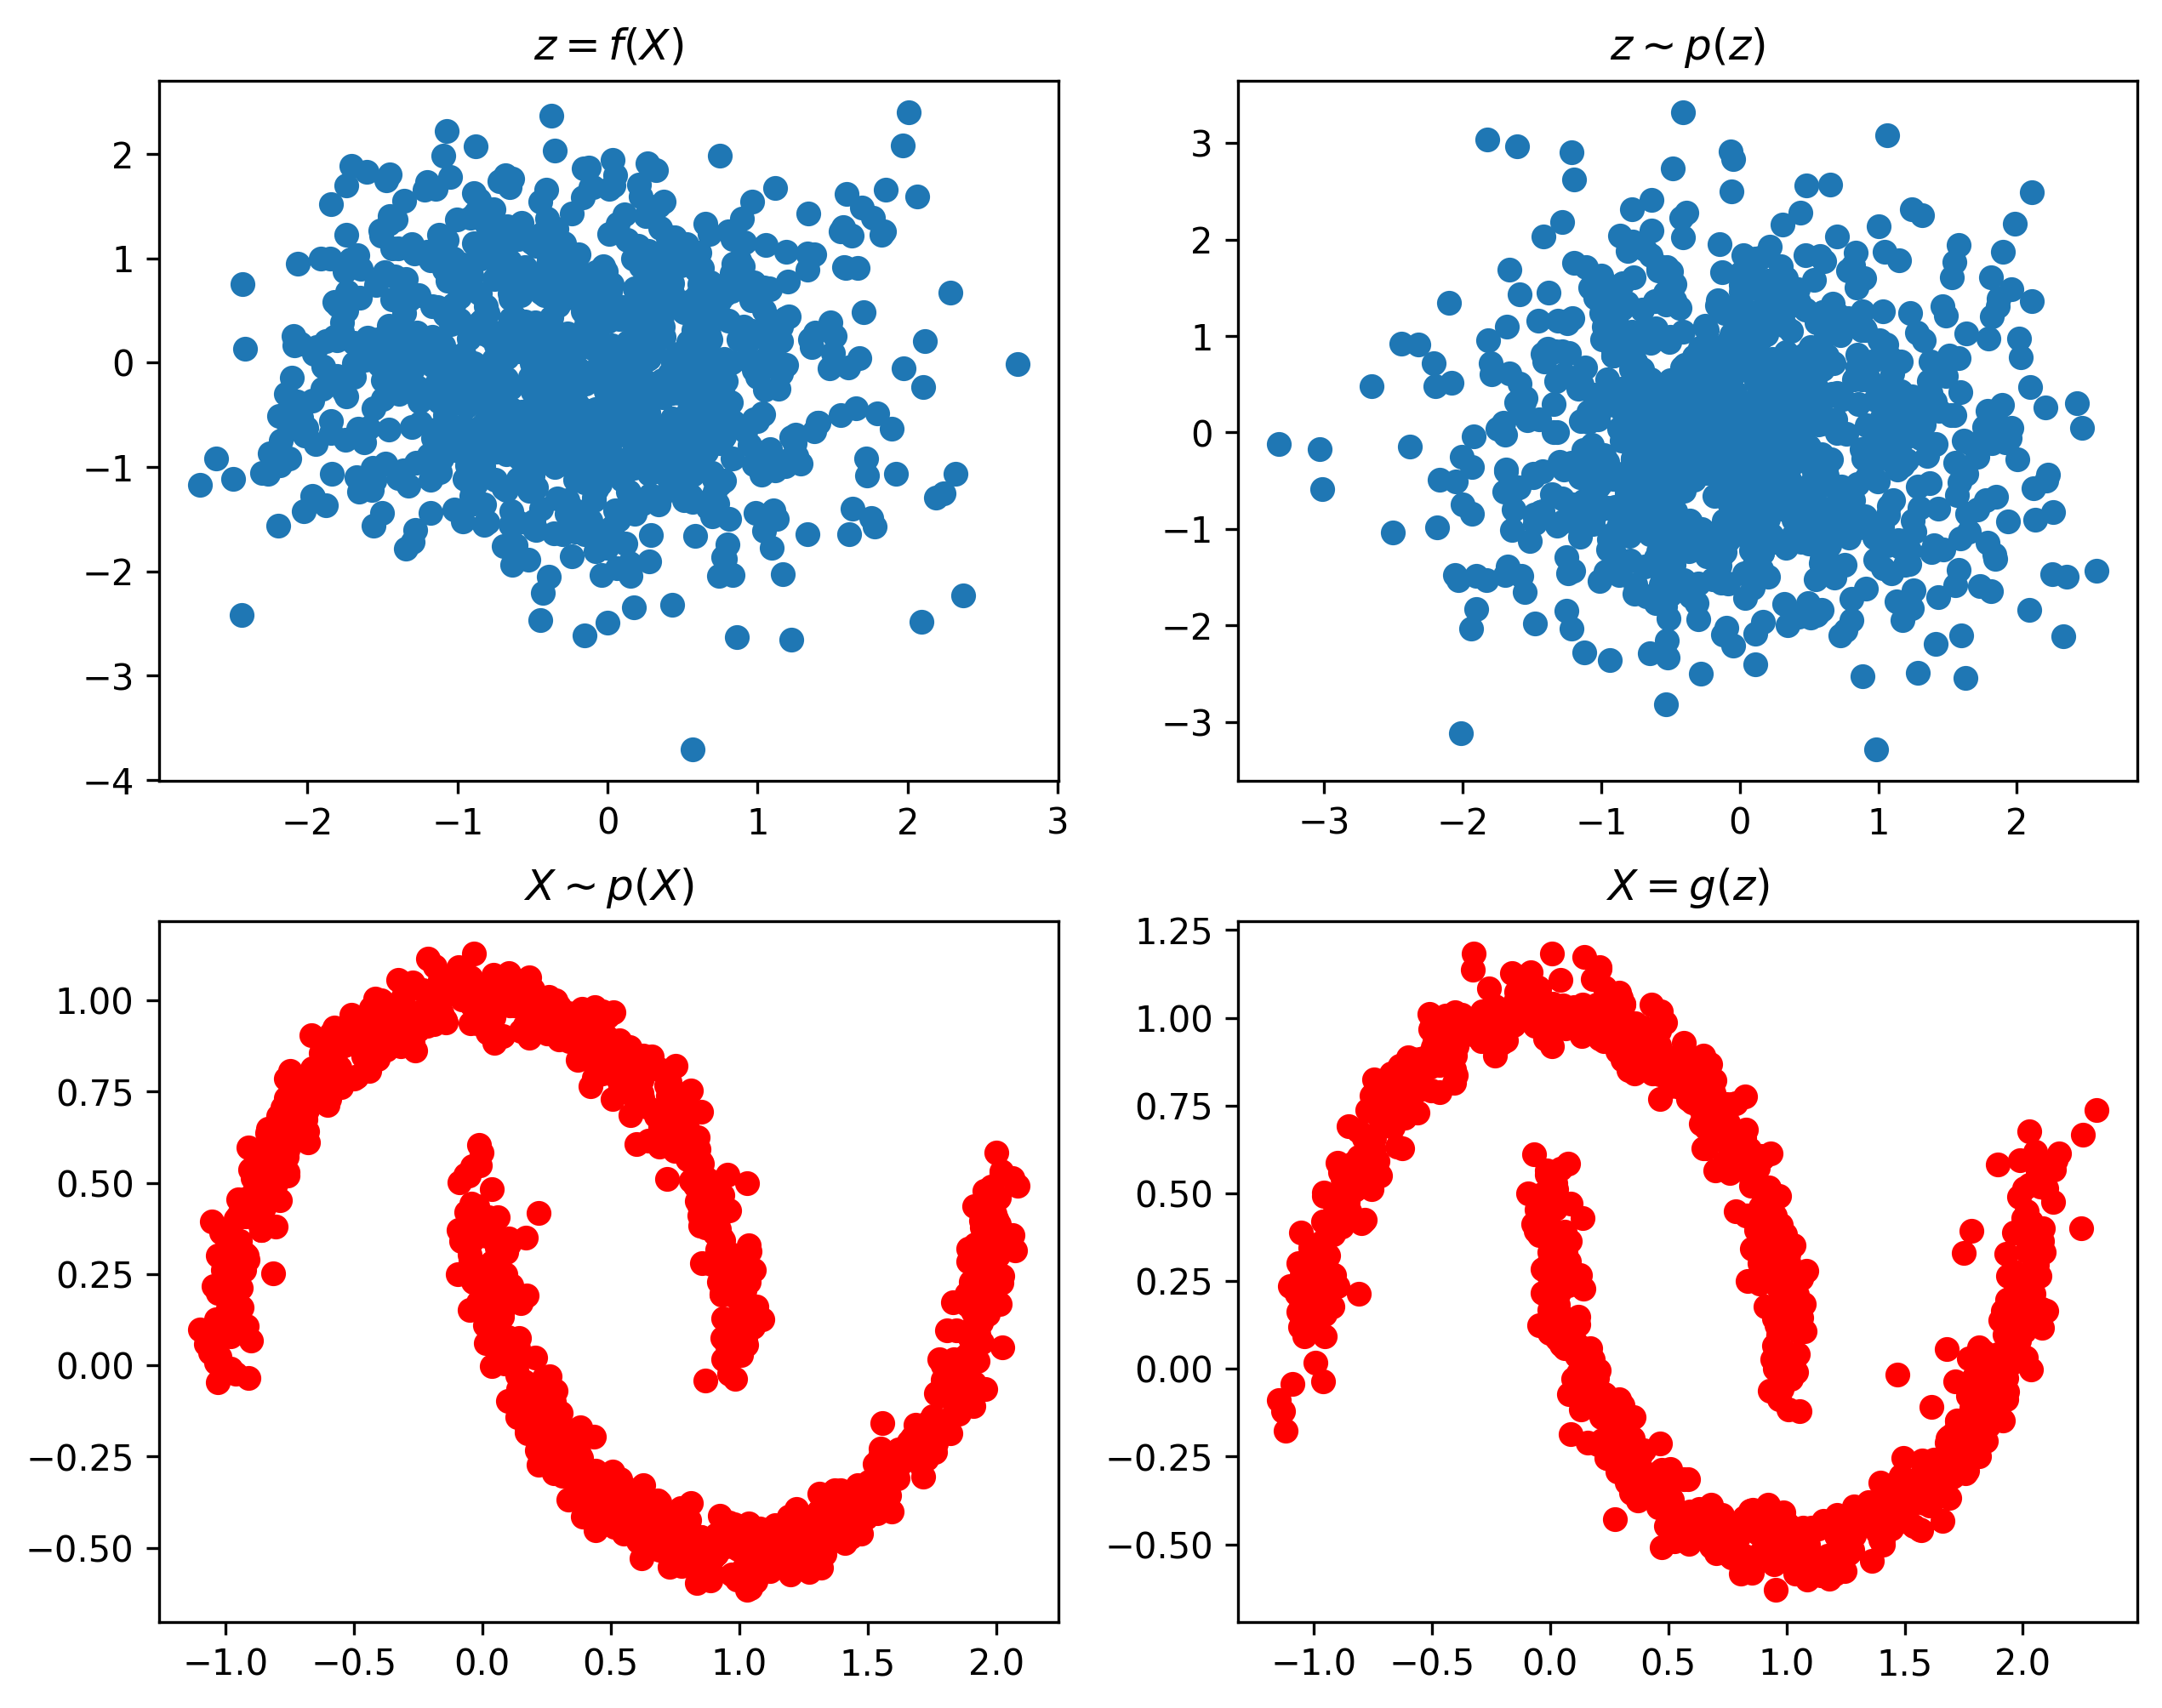

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.Tanh, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.374
iter 500: loss = 0.708
iter 1000: loss = 0.573
iter 1500: loss = 0.467
iter 2000: loss = 0.463
iter 2500: loss = 0.390
iter 3000: loss = 0.342
iter 3500: loss = 0.450
iter 4000: loss = 0.417
iter 4500: loss = 0.449
iter 5000: loss = 0.460
CPU times: user 31min 5s, sys: 3.96 s, total: 31min 9s
Wall time: 31min 19s


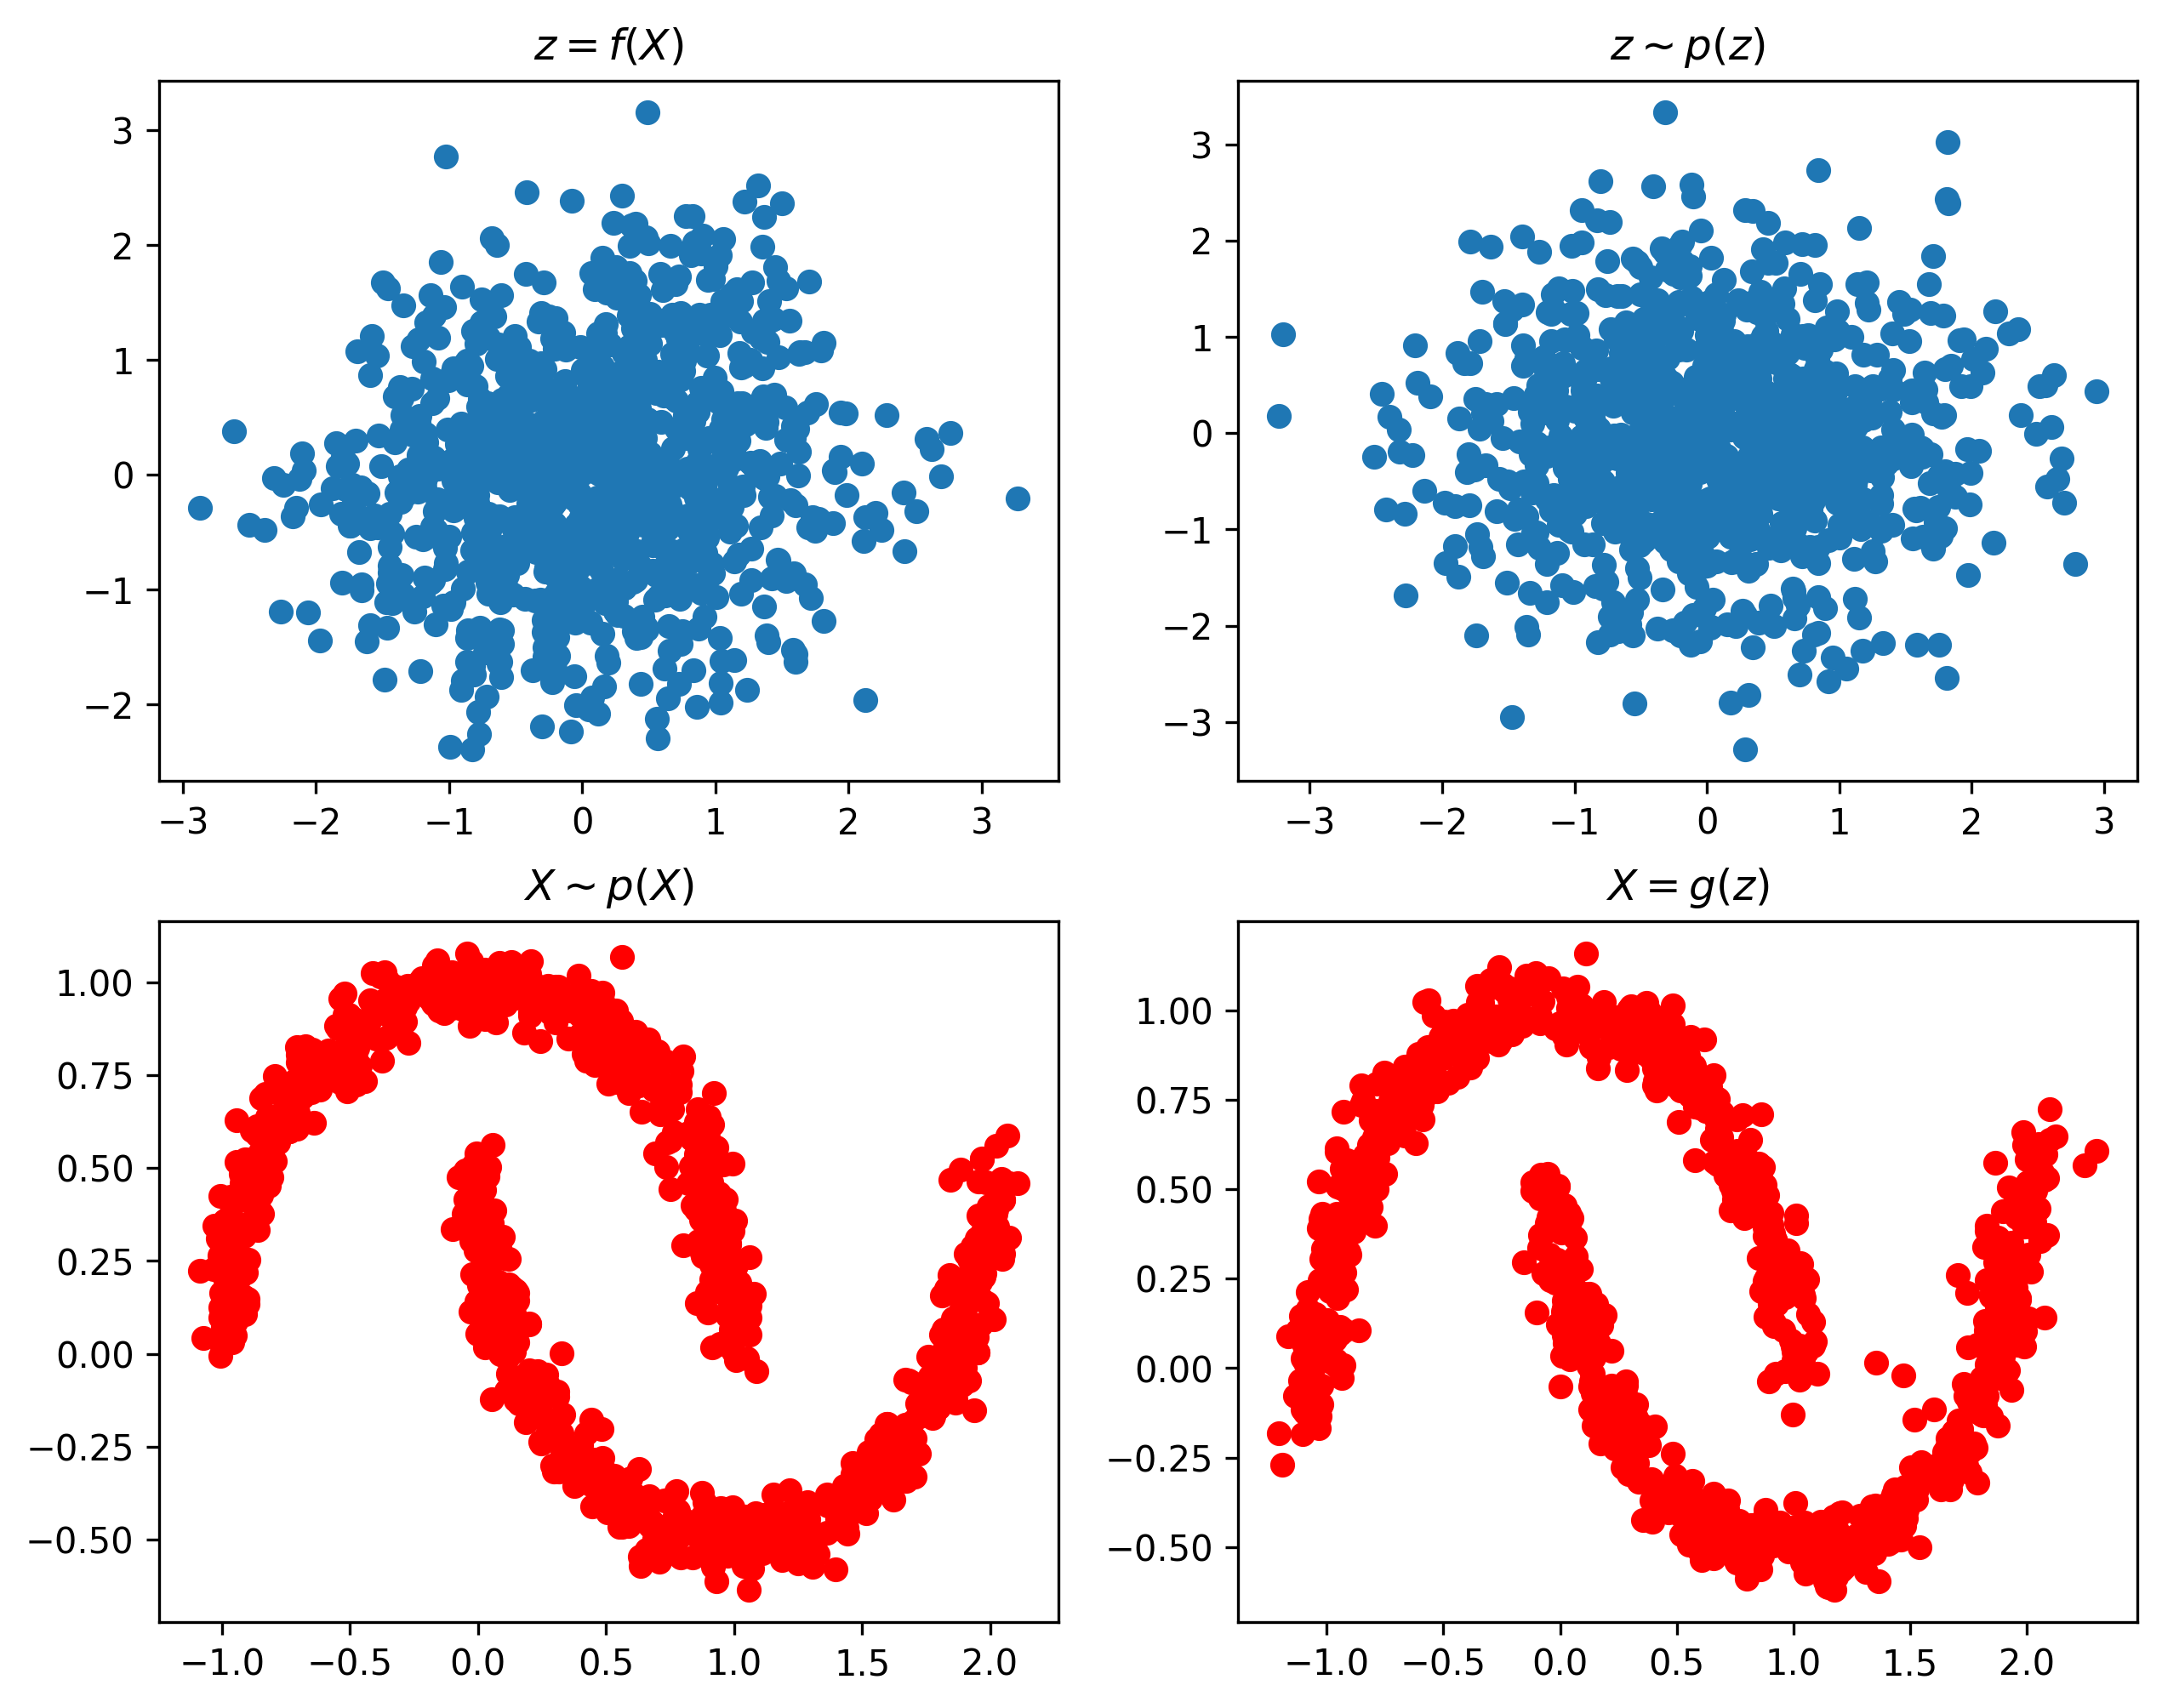

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=256, n_layers=5, nonlinearity=torch.nn.Tanh, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.669
iter 500: loss = 0.609
iter 1000: loss = 0.514
iter 1500: loss = 0.319
iter 2000: loss = 0.406
iter 2500: loss = 0.561
iter 3000: loss = 0.544
iter 3500: loss = 0.591
iter 4000: loss = 0.519
iter 4500: loss = 0.372
iter 5000: loss = 0.359
CPU times: user 1h 10min 38s, sys: 15.1 s, total: 1h 10min 53s
Wall time: 1h 11min 14s


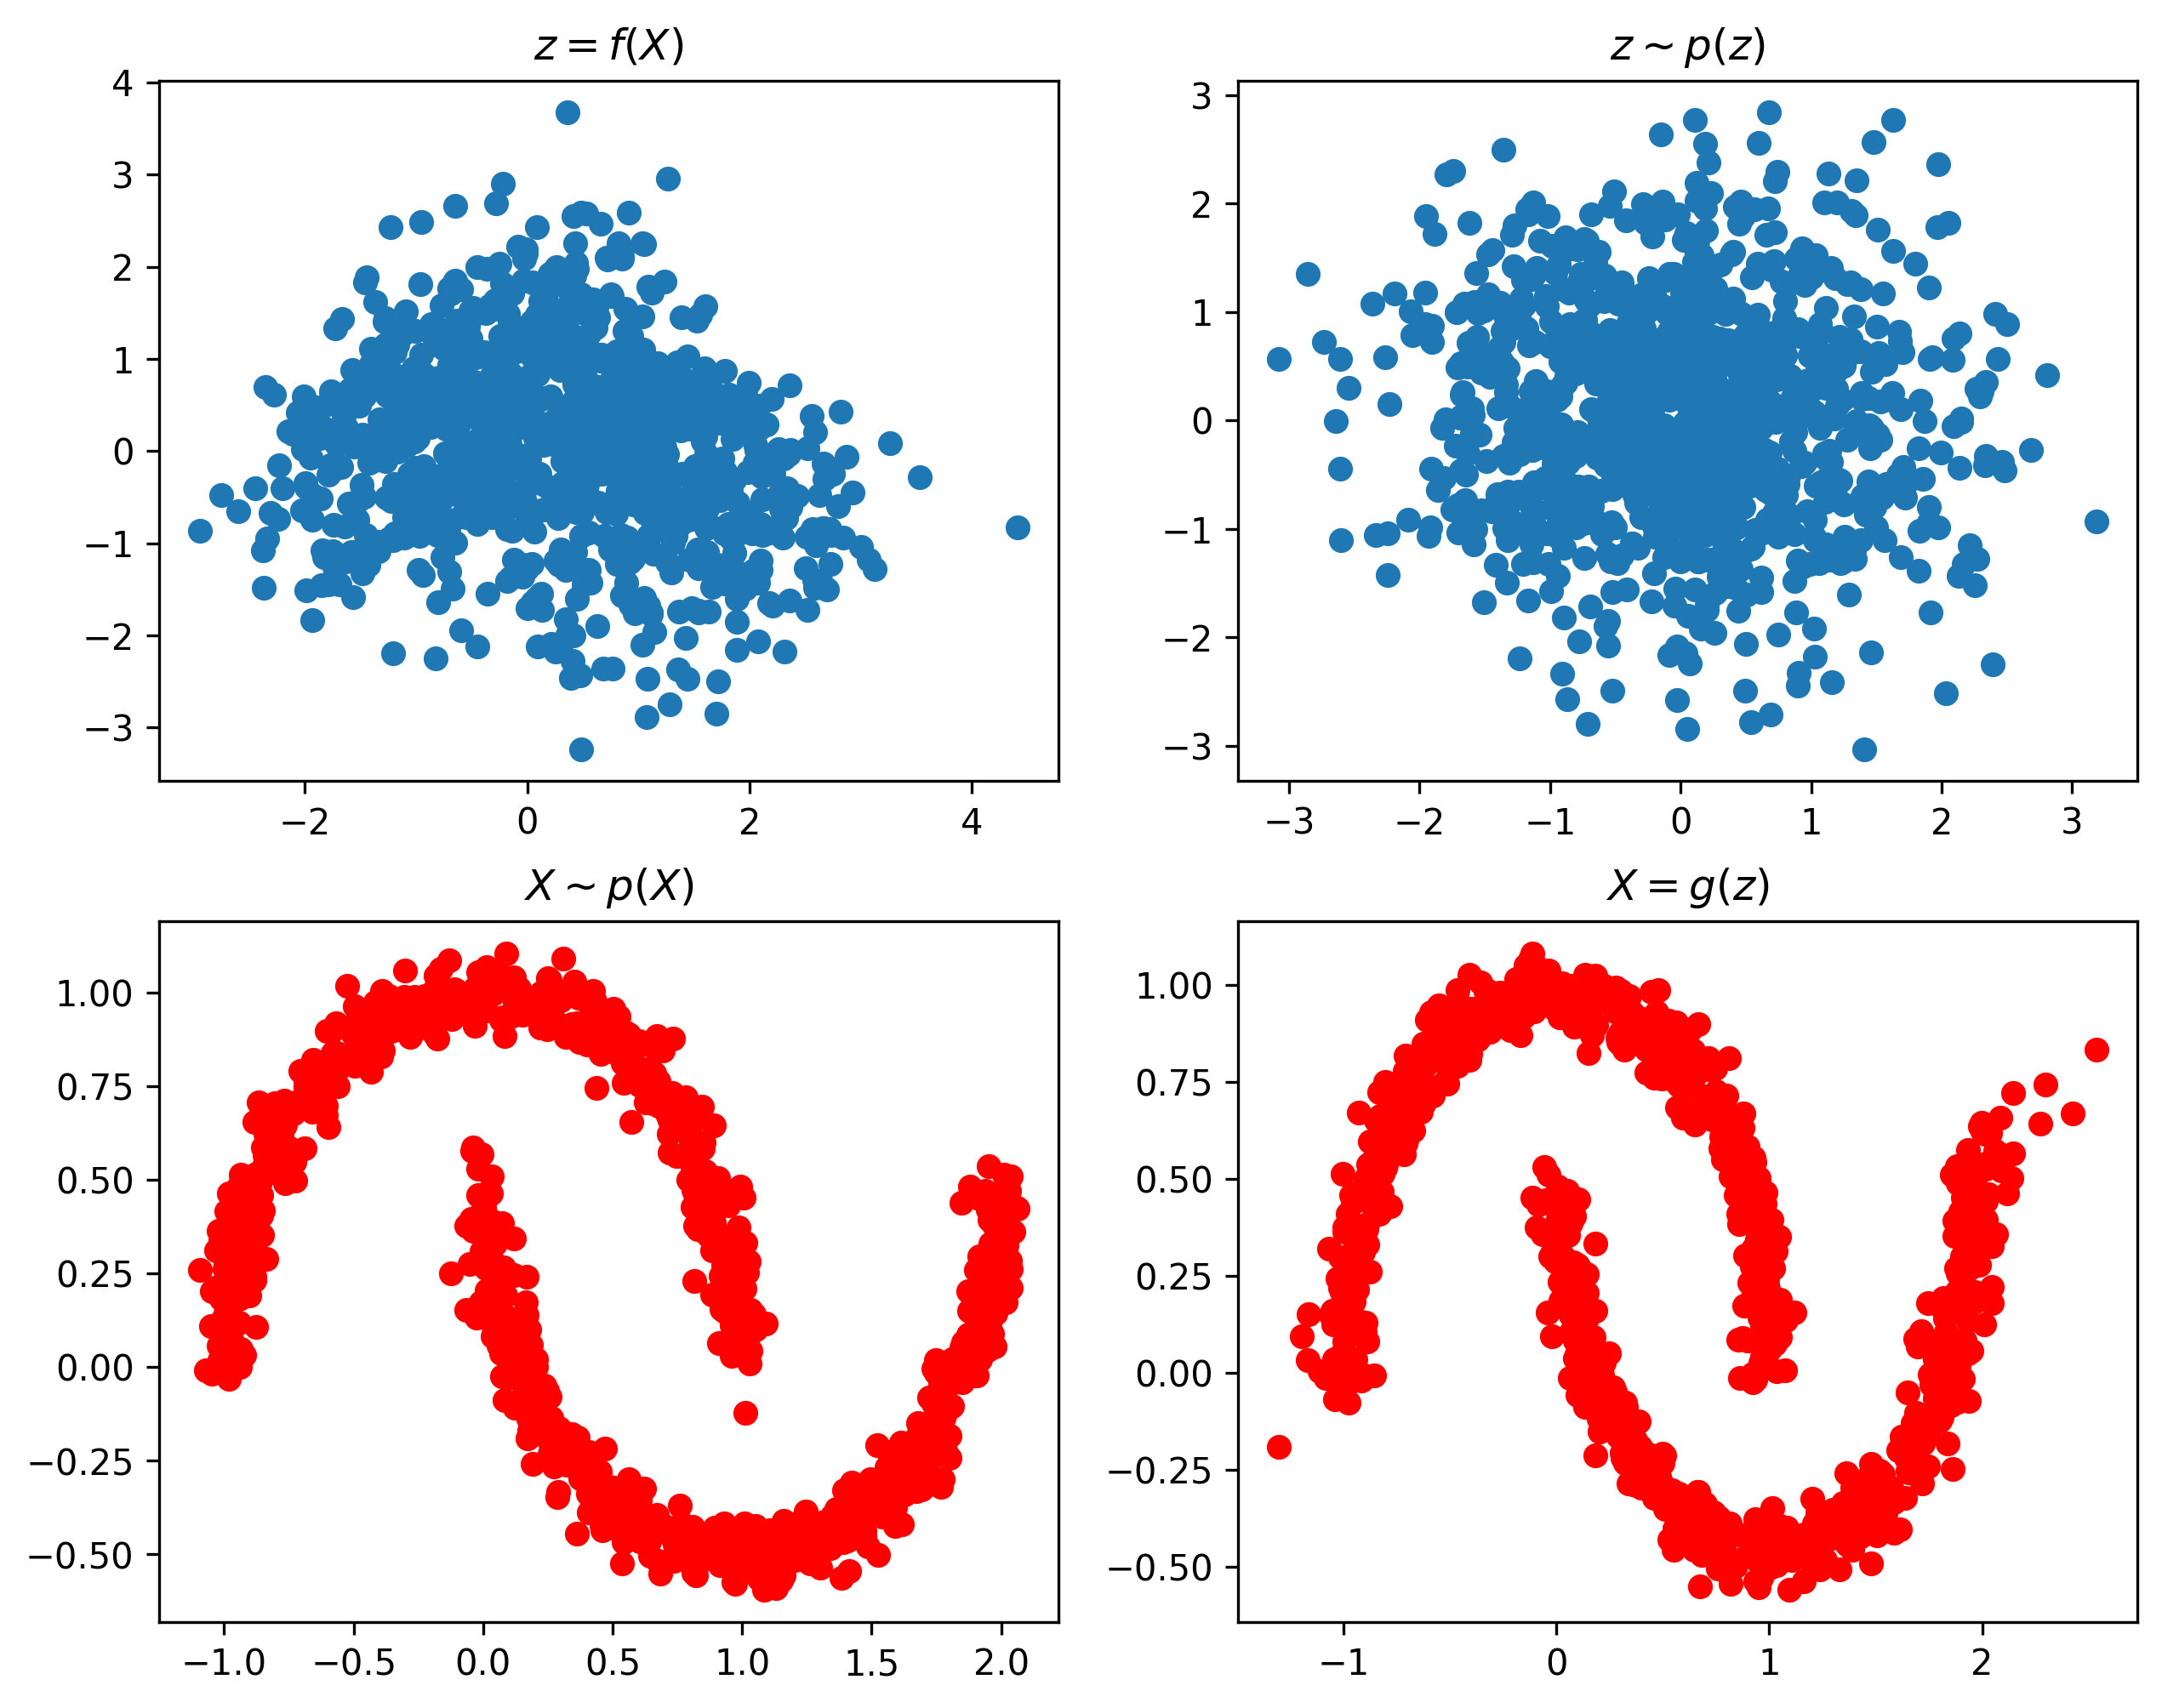

In [ ]:
plot_results(flow)

In [ ]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=512, n_layers=5, nonlinearity=torch.nn.Tanh, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.438
iter 500: loss = 0.632
iter 1000: loss = 0.452
iter 1500: loss = 0.493
iter 2000: loss = 0.414
iter 2500: loss = 0.409
iter 3000: loss = 0.538
iter 3500: loss = 0.419
iter 4000: loss = 0.619
iter 4500: loss = 0.368
iter 5000: loss = 0.521
CPU times: user 3h 48min 41s, sys: 26 s, total: 3h 49min 7s
Wall time: 3h 52min 25s


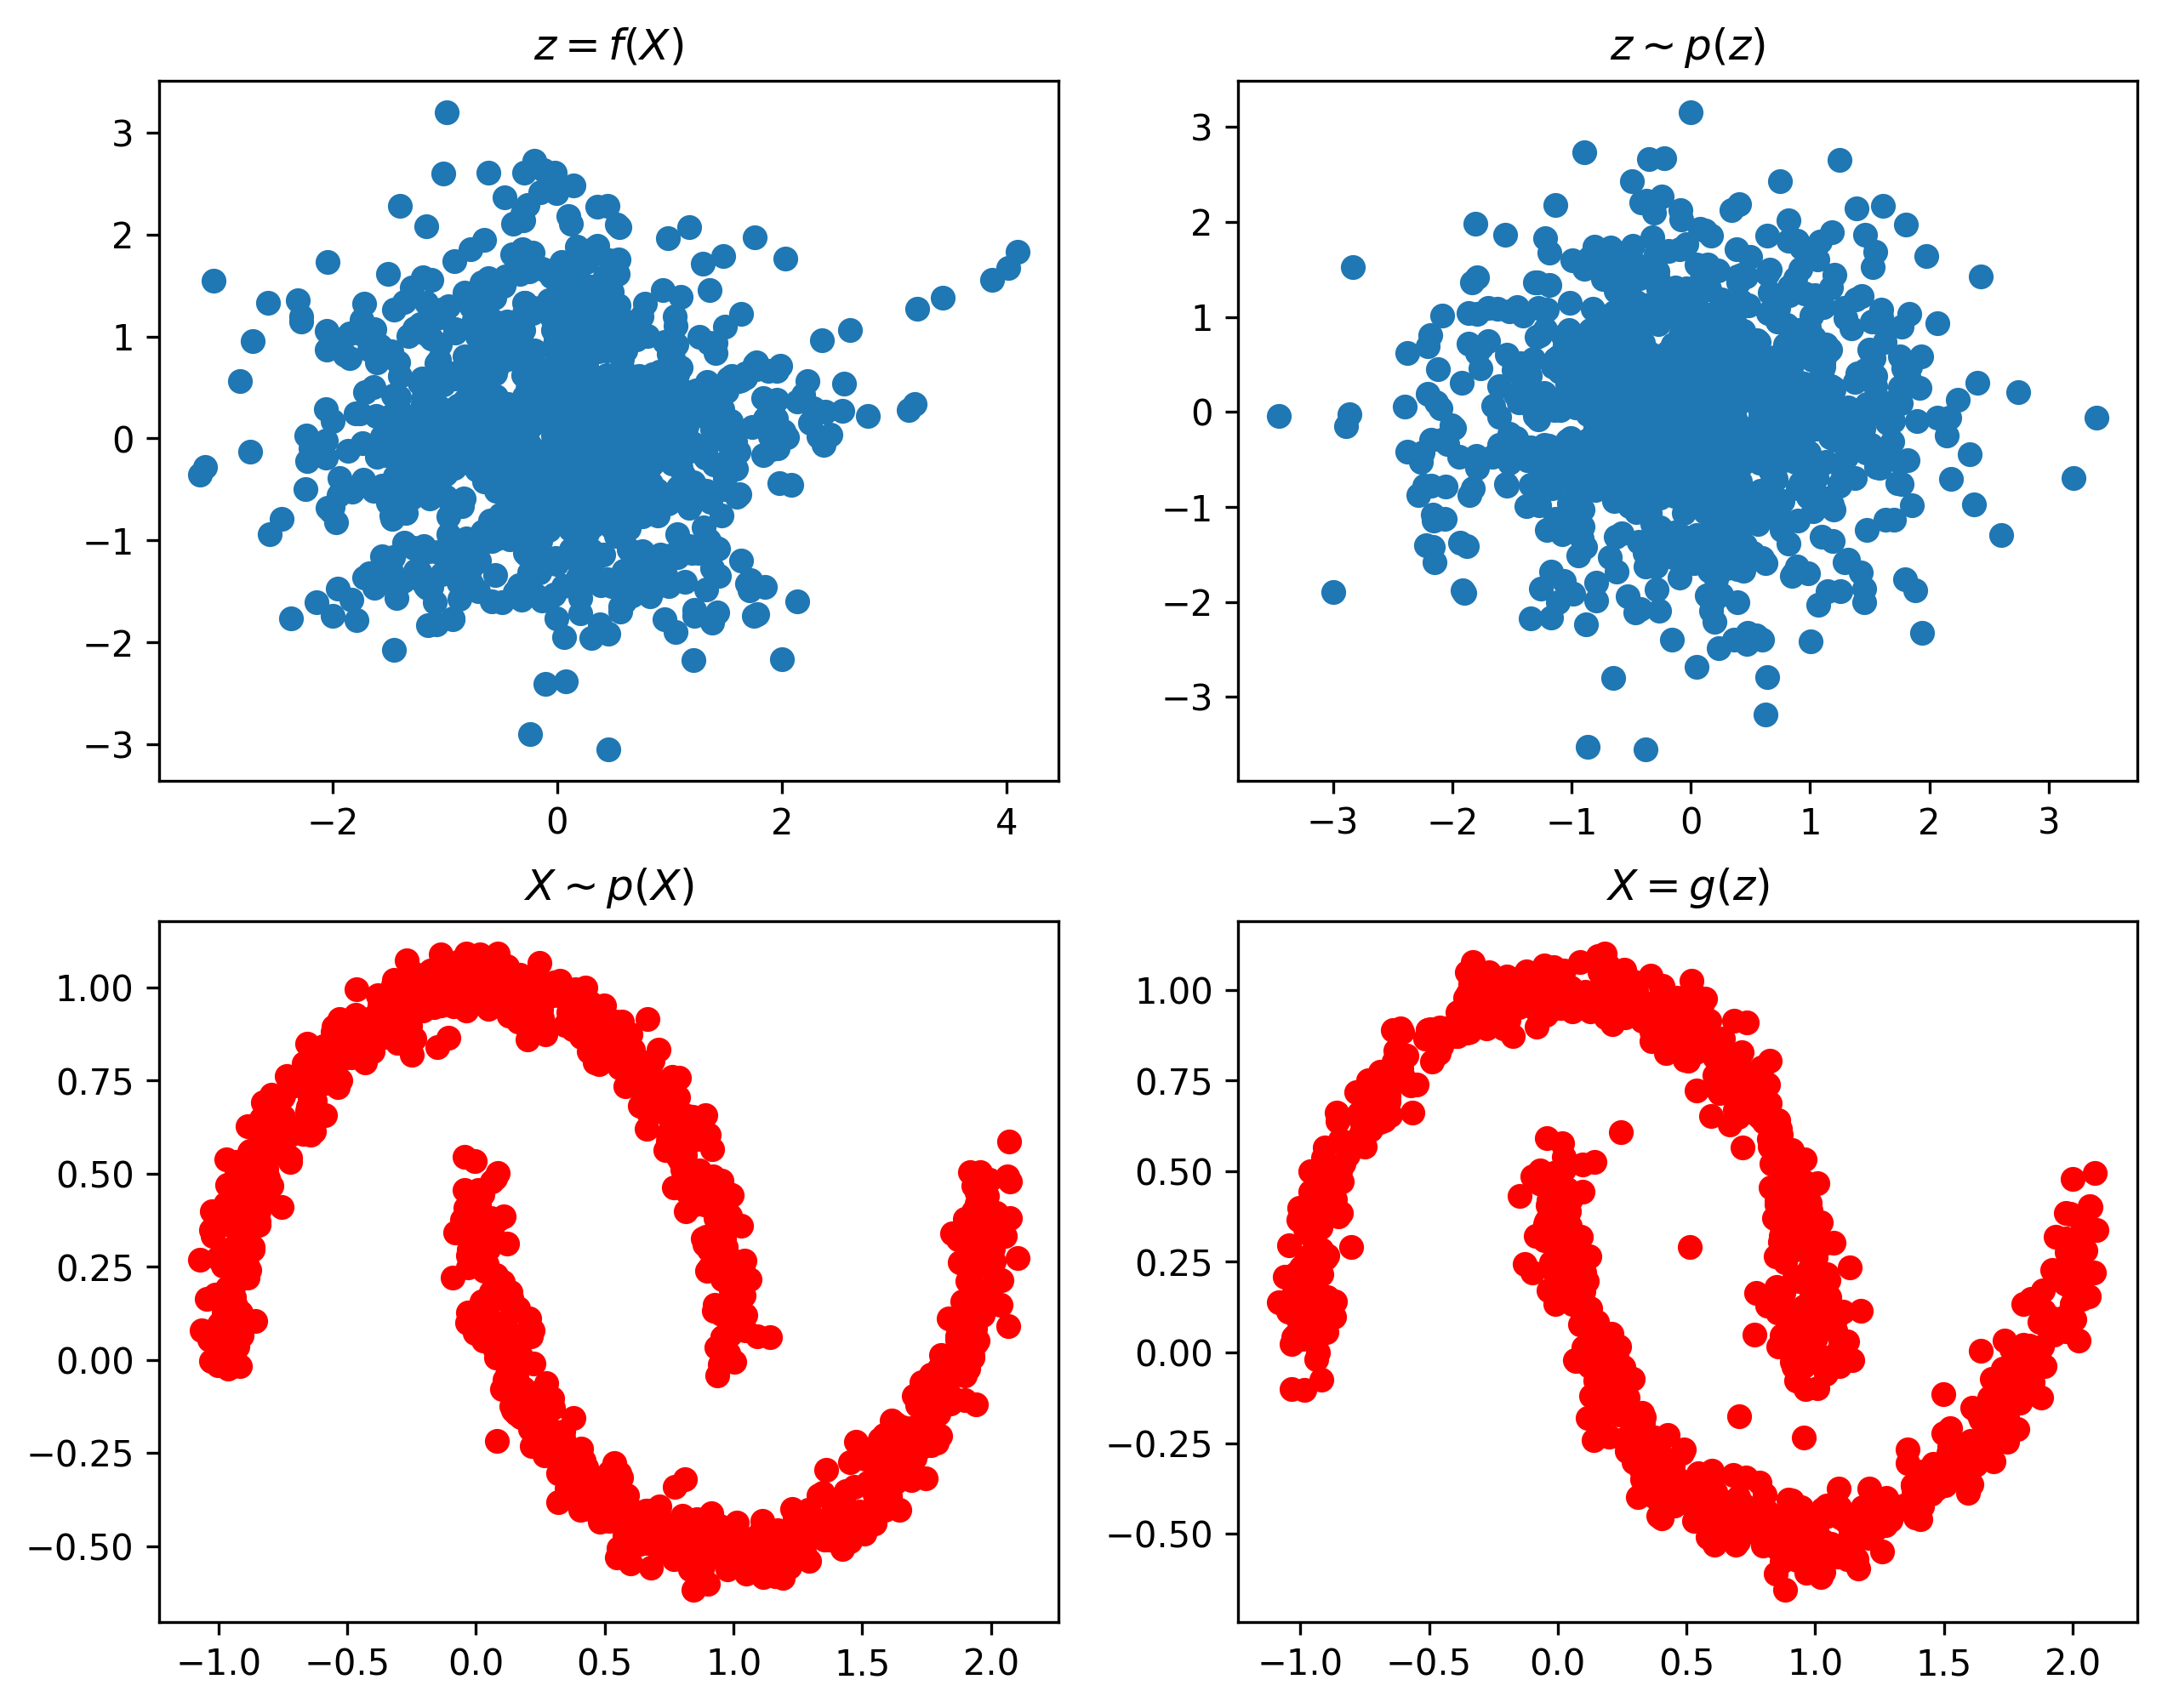

In [ ]:
plot_results(flow)

With the hidden dimension in the range from 64 to 256, the results are quite acceptable and similar, but with smaller and larger dimension artifacts are observed in the resulting images. To some extent, it is possible to say that with increasing hidden dimensionality, the model becomes more flexible, and this may contribute to improving the quality of generation, however, to achieve an acceptable result, more training time and the use of other optimization parameters may be required. Also, increasing the hidden dimension significantly increases the training time. The results for the value 128 can be called optimal in terms of visual result quality and training time. 

Now let's look at different ways to initialize network linear layers weights. It is worth noting that in pytorch the default initialization of weights in the Linear layer is Kaiming uniform. 'None' value in following experiments is equivalent to default pytorch initialization.

In [ ]:
%%time
#Equivalent to Kaiming uniform
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.Tanh, initialization=None, number_of_coupling_layers=50)

iter 0: loss = 2.300
iter 500: loss = 0.790
iter 1000: loss = 0.414
iter 1500: loss = 0.494
iter 2000: loss = 0.448
iter 2500: loss = 0.409
iter 3000: loss = 0.302
iter 3500: loss = 0.533
iter 4000: loss = 0.655
iter 4500: loss = 0.339
iter 5000: loss = 0.531
CPU times: user 32min 14s, sys: 4.01 s, total: 32min 18s
Wall time: 33min 59s


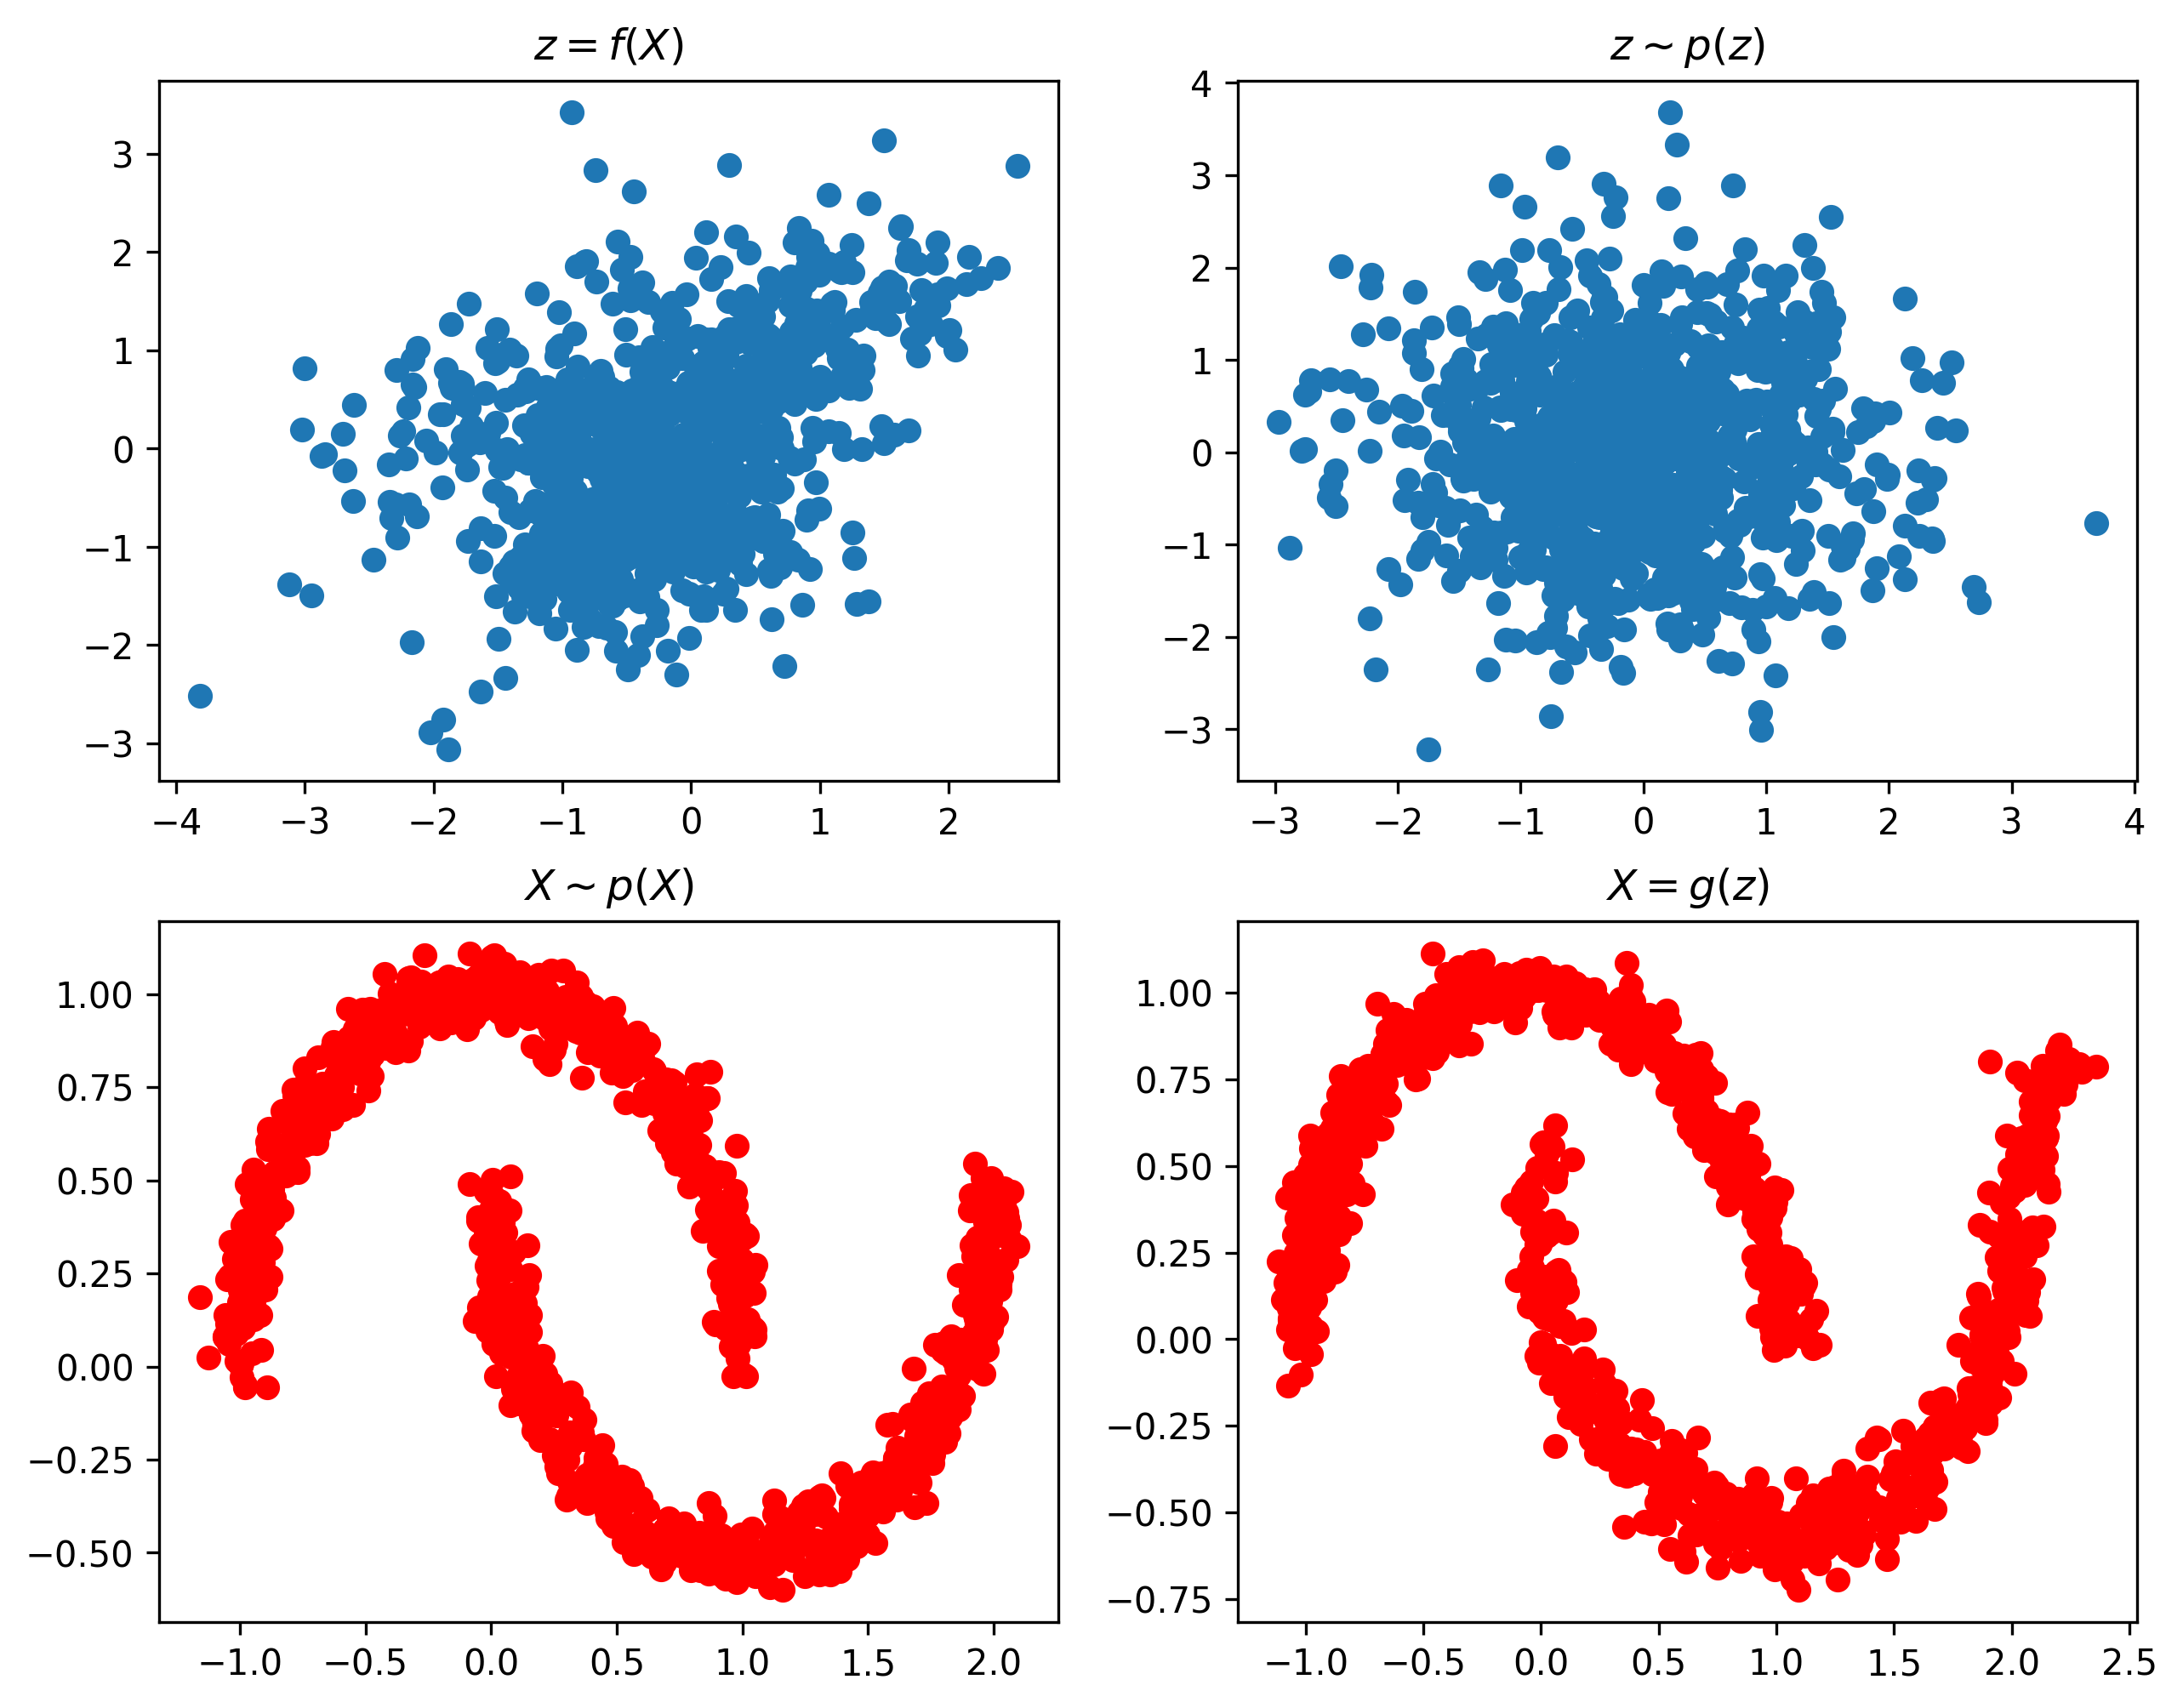

In [ ]:
plot_results(flow)

In the case of Kaiming normal initialization, at least somehow acceptable results were obtained only when the number of linear and coupling layers was reduced. In other cases, the quality of the result was extremely low, and the values of the loss function were extremely high.

In [70]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=3, nonlinearity=torch.nn.Tanh, initialization=init_kaiming_normal, number_of_coupling_layers=10)

iter 0: loss = 5.228
iter 500: loss = 1.277
iter 1000: loss = 0.880
iter 1500: loss = 0.864
iter 2000: loss = 0.799
iter 2500: loss = 0.843
iter 3000: loss = 0.789
iter 3500: loss = 0.812
iter 4000: loss = 0.771
iter 4500: loss = 0.601
iter 5000: loss = 0.695
CPU times: user 4min 44s, sys: 596 ms, total: 4min 44s
Wall time: 4min 49s


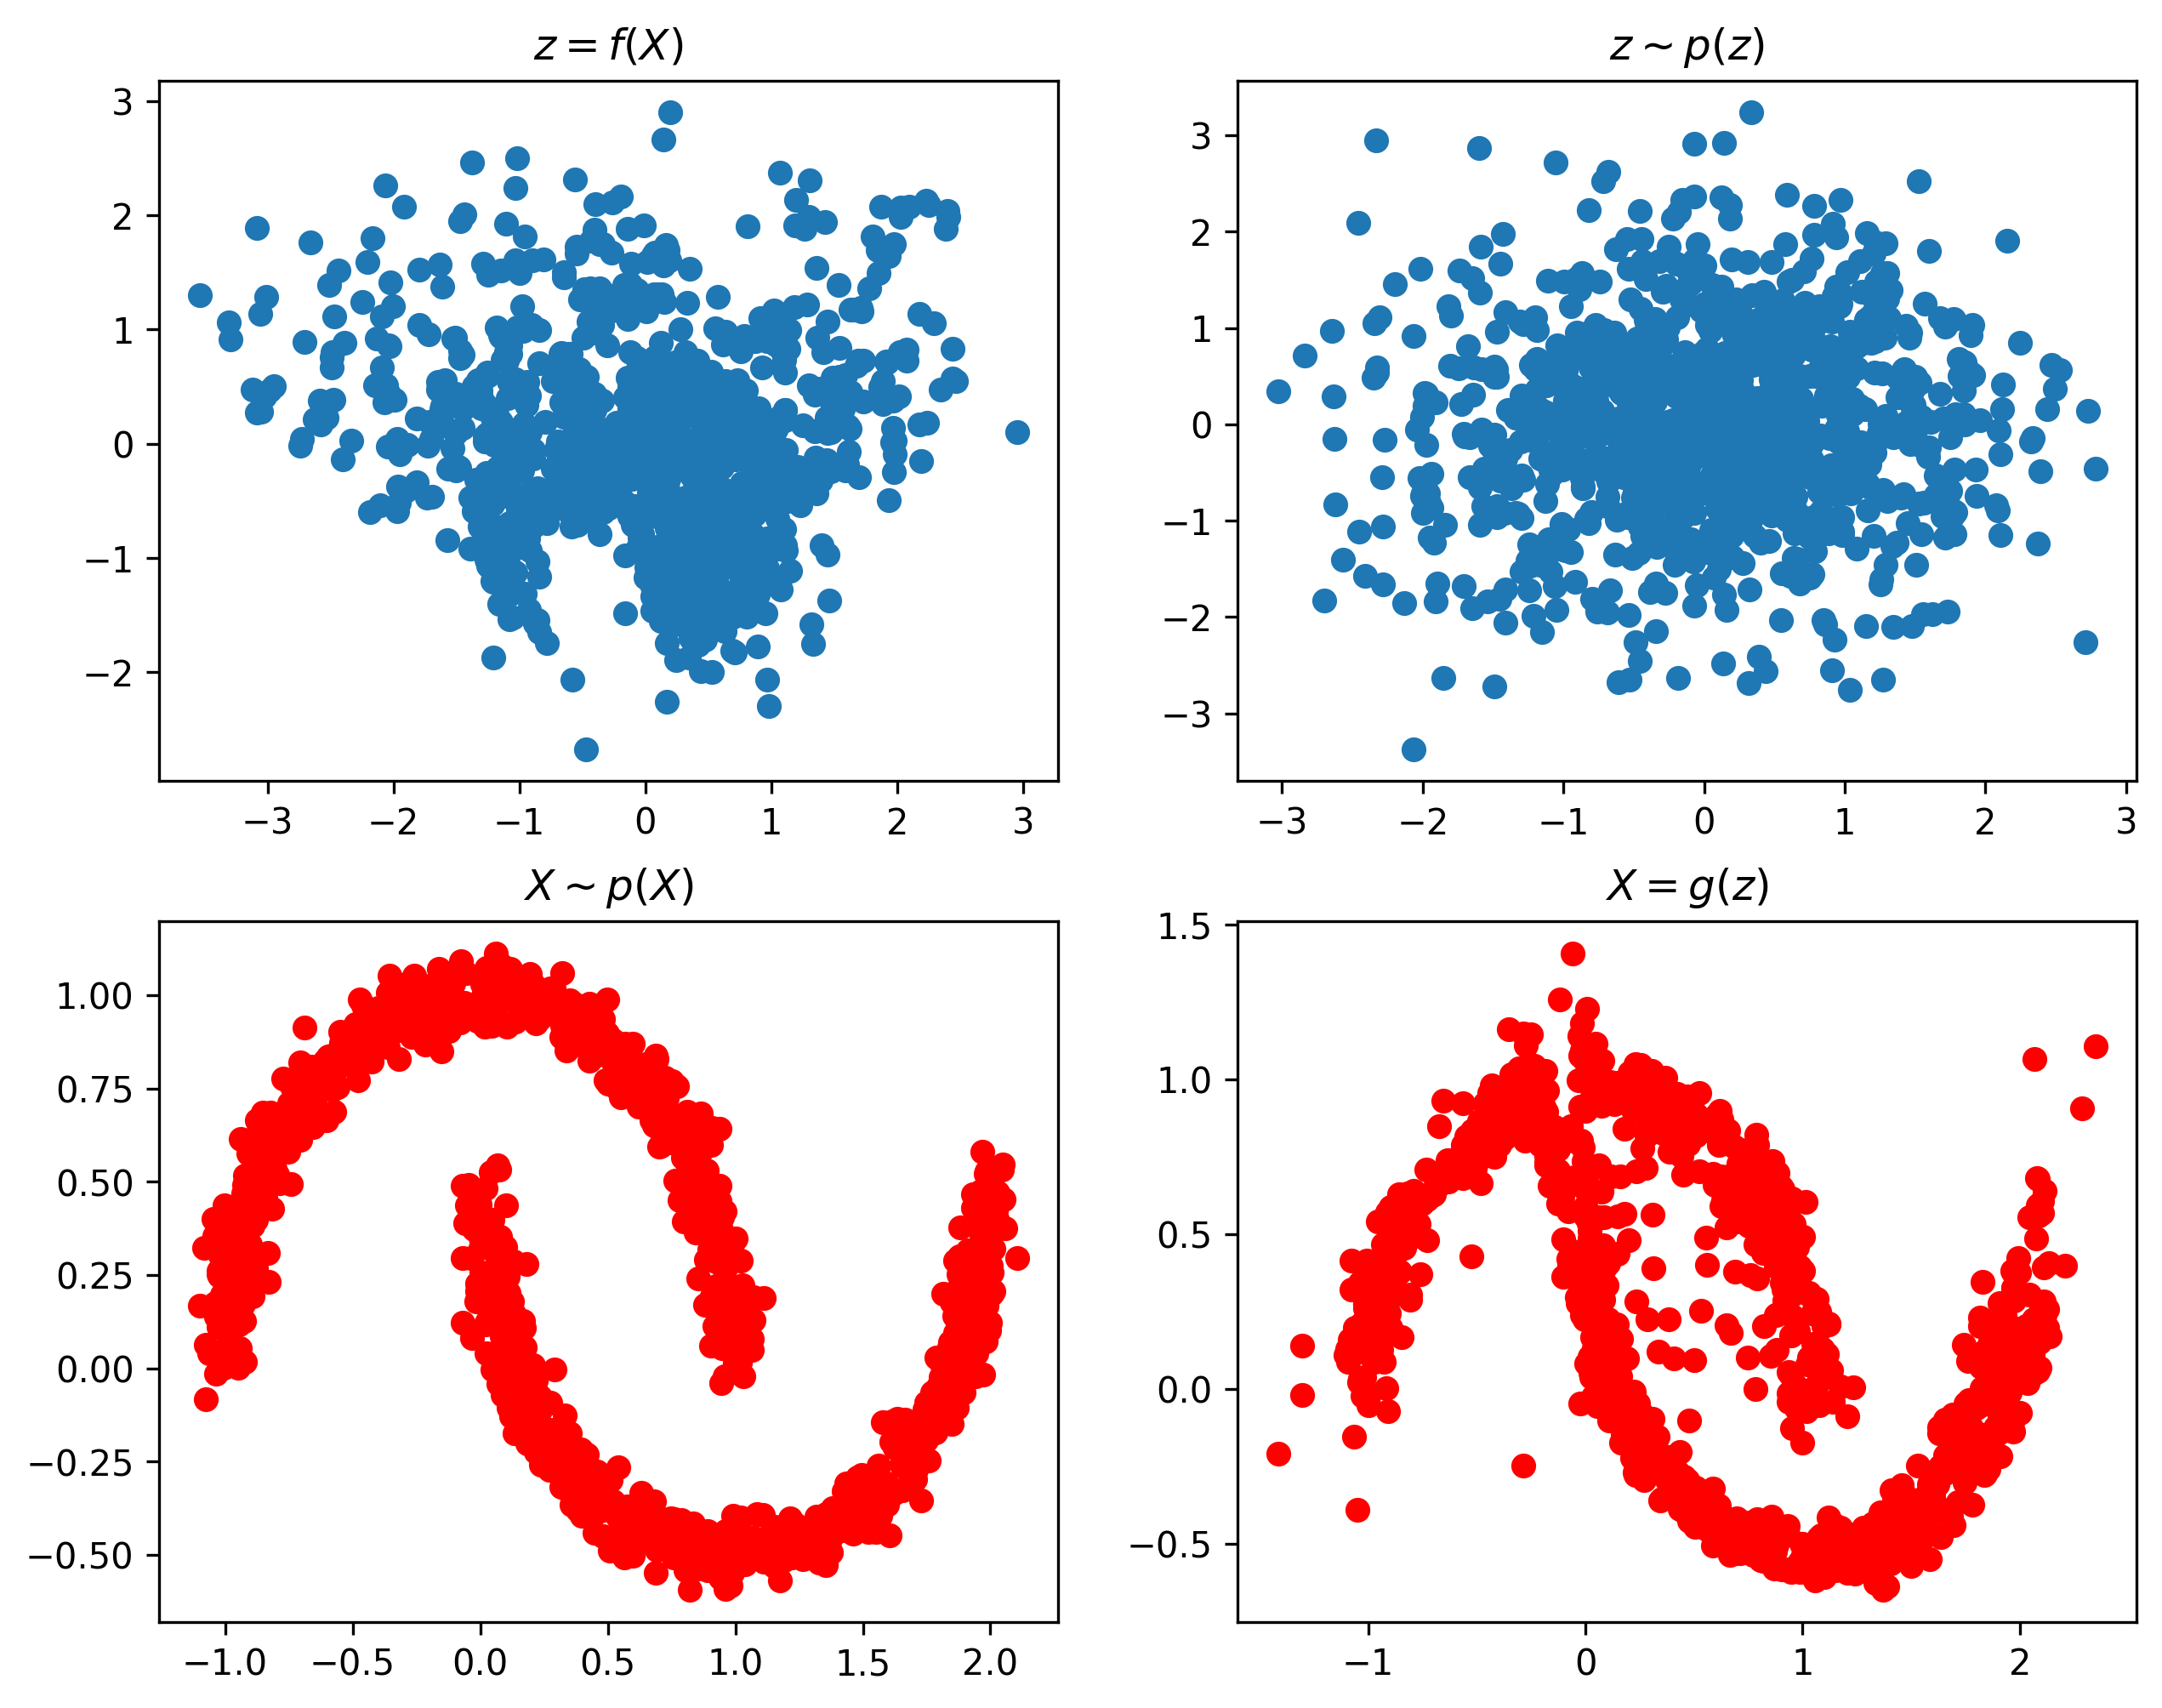

In [72]:
plot_results(flow)

In [64]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=5, nonlinearity=torch.nn.Tanh, initialization=init_xavier_uniform, number_of_coupling_layers=50)

iter 0: loss = 8.887
iter 500: loss = 1.687
iter 1000: loss = 1.181
iter 1500: loss = 1.004
iter 2000: loss = 0.722
iter 2500: loss = 0.563
iter 3000: loss = 0.603
iter 3500: loss = 0.657
iter 4000: loss = 0.539
iter 4500: loss = 0.551
iter 5000: loss = 0.717
CPU times: user 31min 27s, sys: 3.57 s, total: 31min 30s
Wall time: 31min 47s


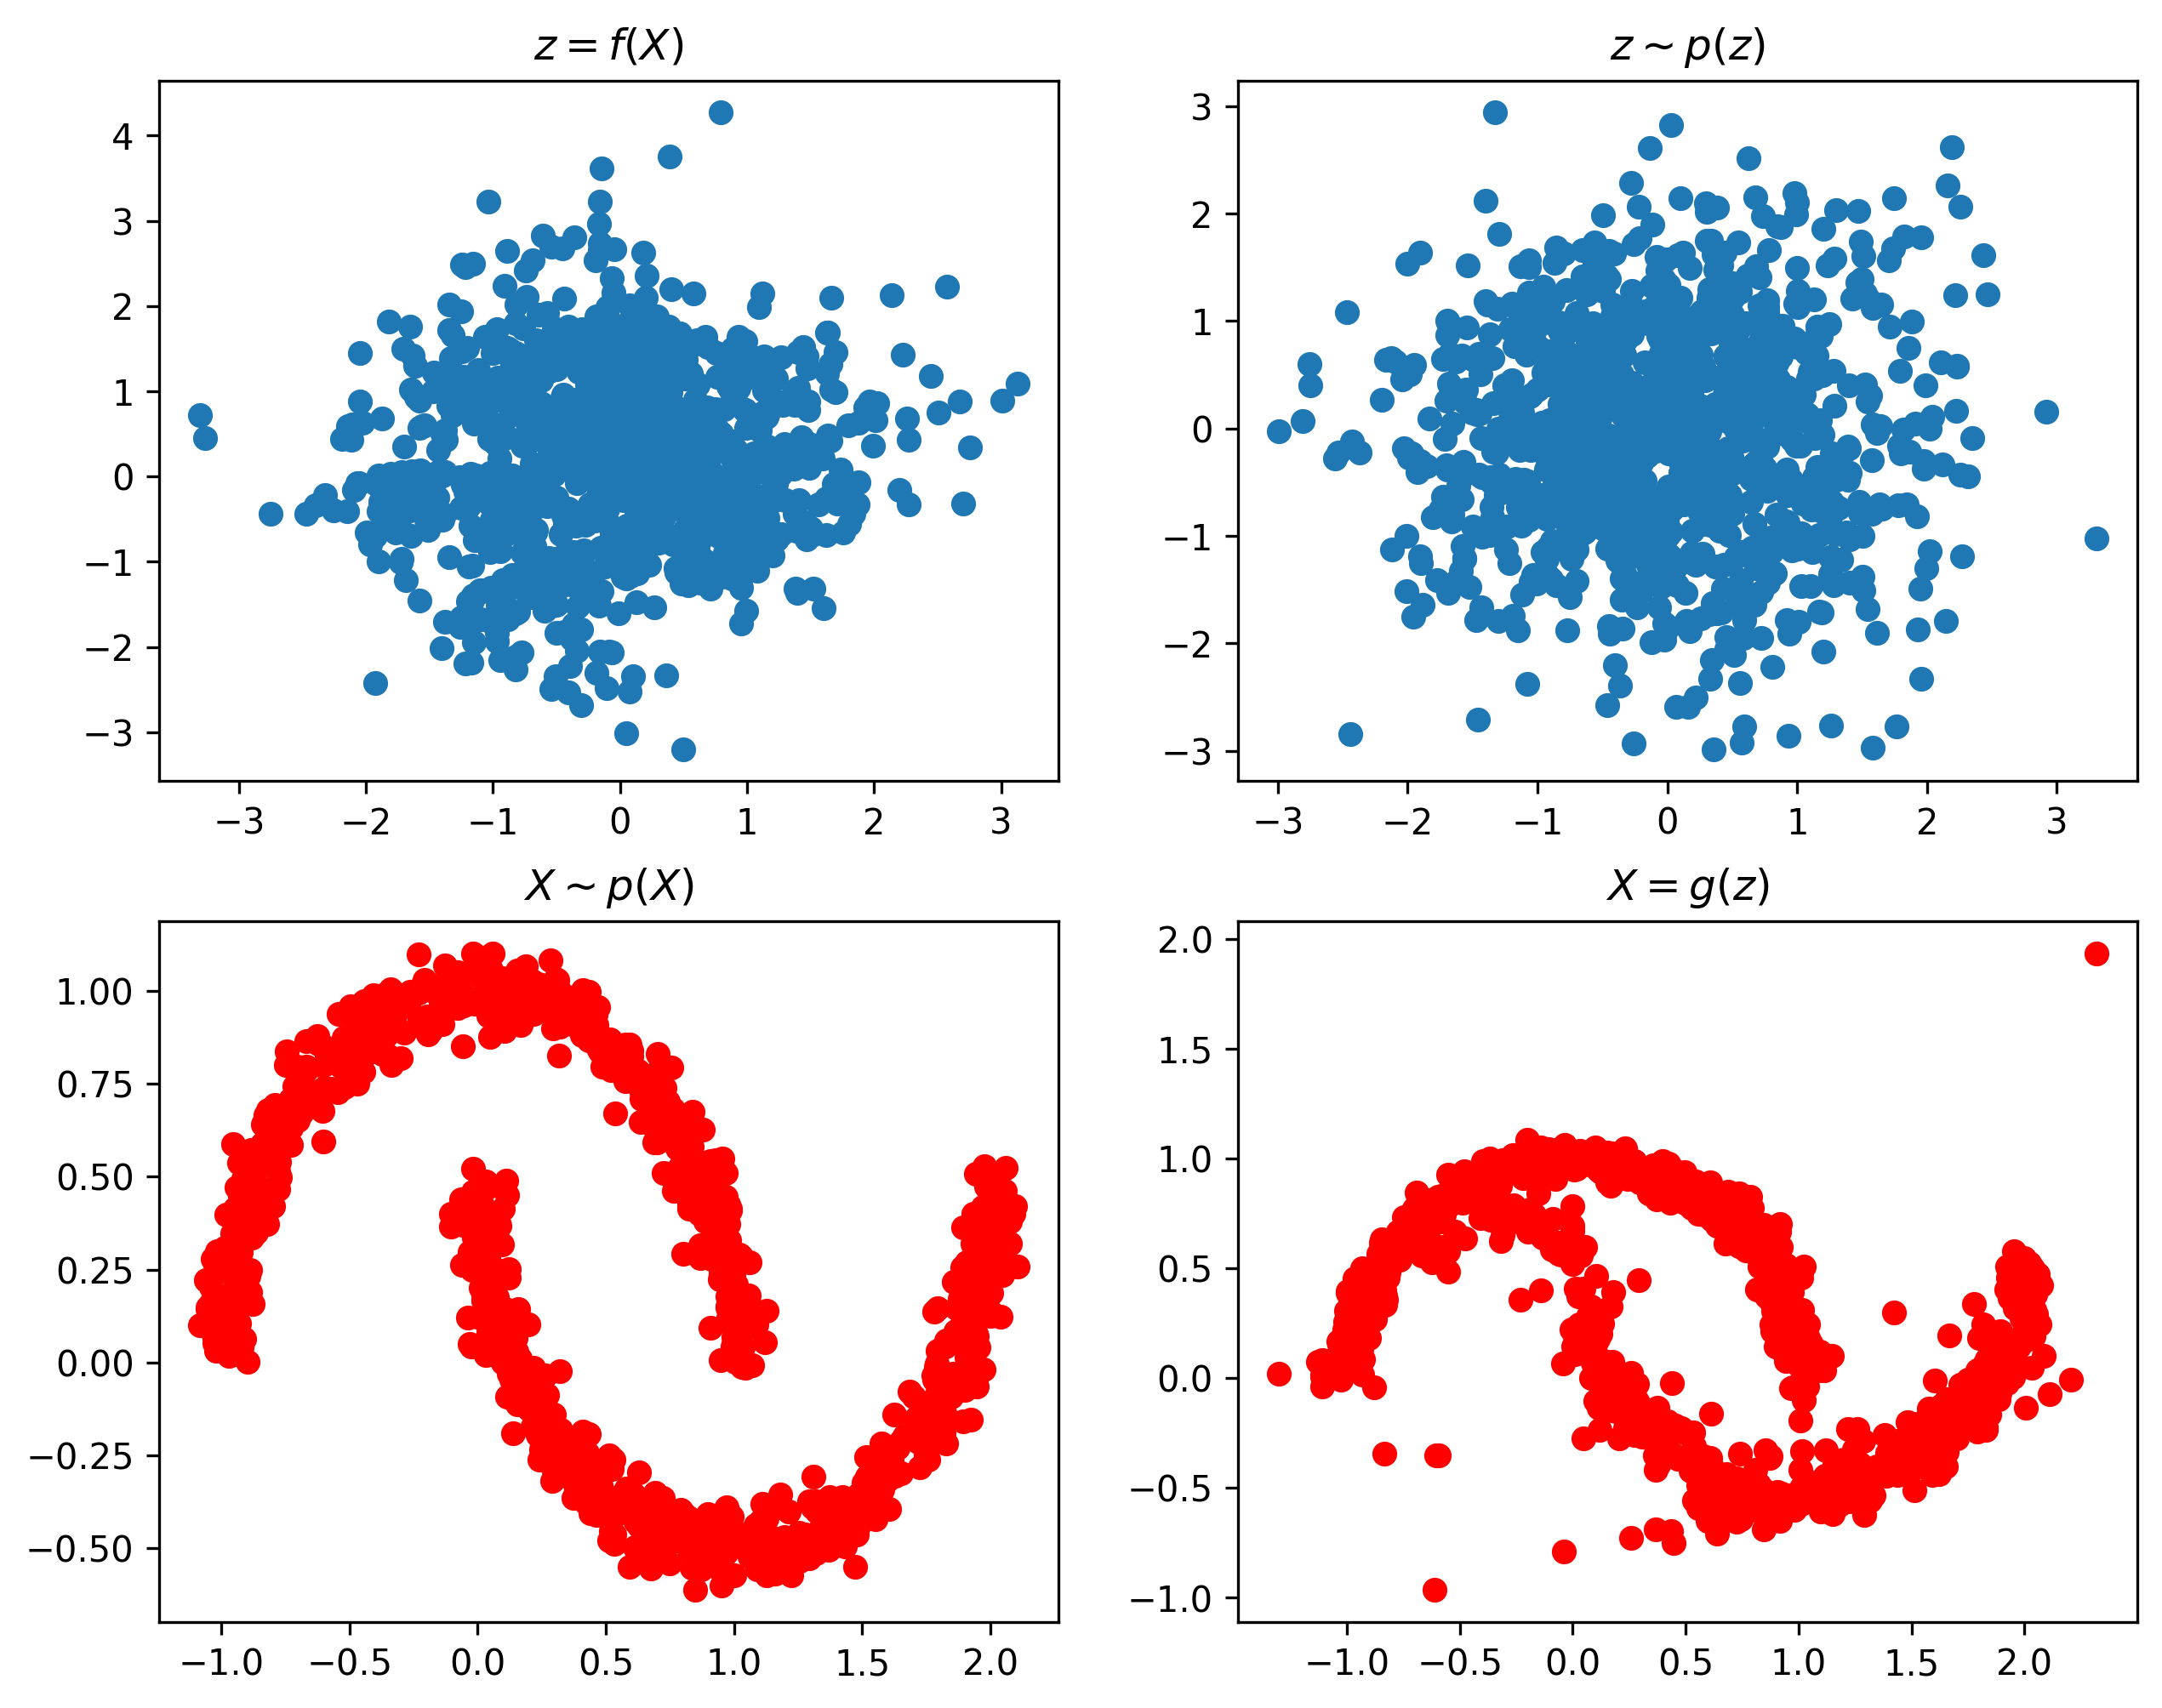

In [65]:
plot_results(flow)

For the Xavier normal initialization, the situation is very similar to the Kaiming normal initialization, so some parameters were changed.

In [75]:
%%time
flow = create_and_train_model(x_dim=2, hidden_dim=128, n_layers=3, nonlinearity=torch.nn.Tanh, initialization=init_xavier_normal, number_of_coupling_layers=10)

iter 0: loss = 2.610
iter 500: loss = 0.537
iter 1000: loss = 0.801
iter 1500: loss = 0.736
iter 2000: loss = 0.667
iter 2500: loss = 0.560
iter 3000: loss = 0.760
iter 3500: loss = 0.701
iter 4000: loss = 0.636
iter 4500: loss = 0.504
iter 5000: loss = 0.548
CPU times: user 4min 40s, sys: 572 ms, total: 4min 41s
Wall time: 4min 43s


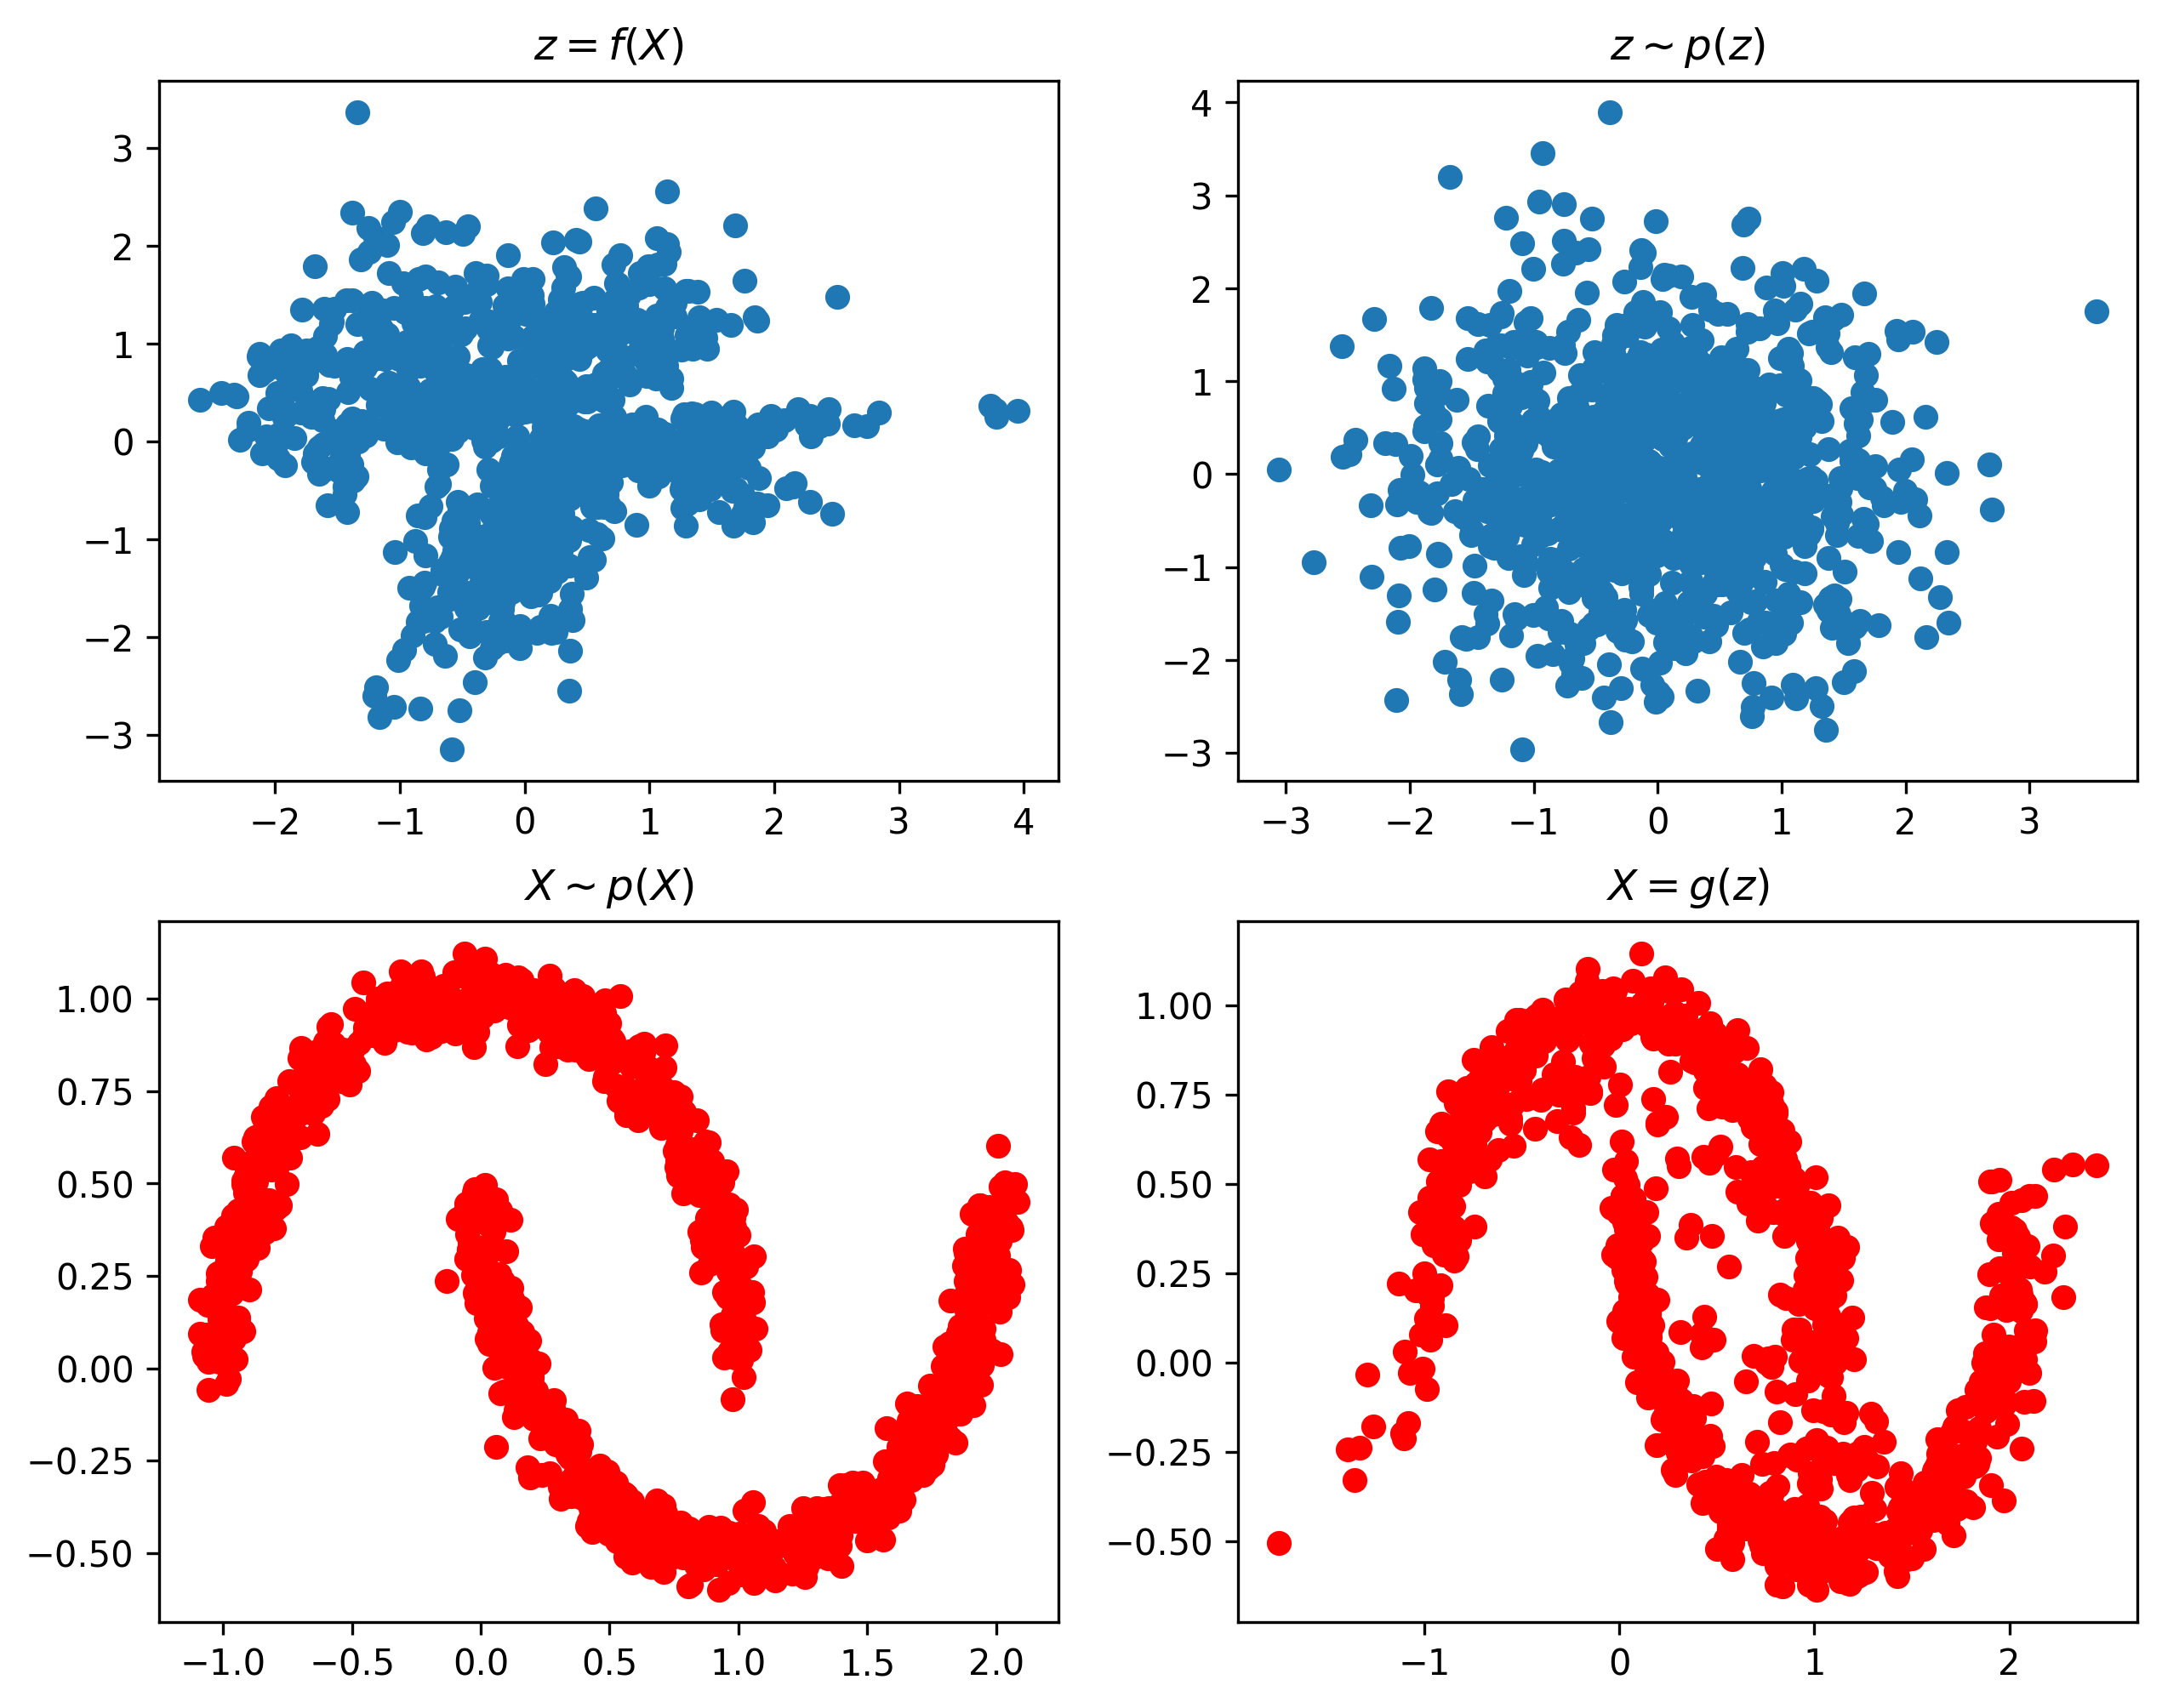

In [76]:
plot_results(flow)

The best results were generated when using default pytorch weights initialization (Kaiming uniform), in other cases, the quality was much worse. In general, it is possible to say that the quality of generation strongly depends on the type of initialization of the weights, in many ways even stronger than on the other parameters considered in this notebook.

## Provide answers for the folowing questions:

1. What architecture worked better in your experiments?


In the experiments a relatively simple architecture of a fully connected network with consecutive linear layers of the same size was considered and architecture parameters such as the number of coupling layers, the number of linear layers, the type of activation function, the dimension of the linear layer, the type of initialization of weights were considered. In these experiments the model with 5 linear layers, hidden size equal to 128, 50 coupling layers, Tanh nonlinearity and Kaiming uniform weight initialization showed itself in the best way. The corresponding best parameters can be called intermediate, that is, a simpler architecture does not achieve equally good results, but the complication of the model also does not give an increase in quality, although perhaps a larger number of training epochs and using other optimization parameters may allow a more complex architecture to learn properly and achieve higher generation quality. The results obtained by the best model look quite realistic and high-quality, and the values of the loss function are quite small, although they decrease during the training process is not quite stable.

2. Did you find what is important for stable training (initializations, nonlinearities, ...)?


In general, each of the considered parameters (number of linear and coupling layers, nonlinearity type, weights initialization type, hidden size) has some effect on the final result. 

With an increase in the number of coupling layers, the generation result becomes better and more realistic, and the value of the loss function decreases very slightly, but the training time of the model increases. Visually, the best results were obtained with 50 layers. With the increase in the number of coupling layers, the number of tunable parameters of the model increases, the model becomes more flexible, however, since the transformations used in RealNVP are quite simple and are performed within the framework of one epoch, it does not require more epochs of training and the use of specifically other parameters of the optimizer, and the quality of the result increases at the same time. However, it is difficult to talk about an explicit dependency between the quality of generation and the number of coupling layers, since the results, for example, for 10 layers, seem to be of higher quality than for 20 and 30, so most likely the optimal number of coupling layers lies in a certain bounded range. In general, all the generation results can be called relatively realistic.

As for the number of linear layers, for too few or too many layers, the quality of generation begins to fall, due to simplicity in the first case and complexity of architecture and, accordingly, complexity of its training in the second case. Increasing the number of training epochs and changing the parameters of the optimizer probably may allow complex architectures to achieve better results. The best results were achieved for 5 layers. Also the increase in the number of linear layers significantly increases the network training time.


For the dimension of the hidden layer, the situation is about the same. With the hidden dimension in the range from 64 to 256, the results are quite acceptable and similar, but with smaller and larger dimension artifacts are observed in the resulting images. To some extent, it is possible to say that with increasing hidden dimensionality, the model becomes more flexible, and this may contribute to improving the quality of generation, however, to achieve an acceptable result, more training time and the use of other optimization parameters may be required. Also, increasing the hidden dimension significantly increases the training time. The results for the value 128 can be called optimal in terms of visual result quality and training time. 

Among all the activation functions considered, the highest quality generation result was obtained for the Tanh function, with almost no outliers and irregularities at the edges. The results for ReLU and LeakyReLU in general do not differ much, but for Sigmoid, data of completely unacceptably low quality is generated. The values of the loss function for all activations are similar, except for the Sigmoid, for which the loss is quite high and decreases very slowly. The training time does not depend on the type of nonlinearity function.

In general, all the considered architecture parameters have an impact on the final result. However, the type of initialization of the network weights has the strongest influence on the quality of generation. The best results were generated when using default pytorch weights initialization (Kaiming uniform), in other cases, the quality was much worse. In general, it is possible to say that the quality of generation strongly depends on the type of initialization of the weights, in many ways even stronger than on the other parameters considered in this notebook.

As for the stability of the learning process, in general, in all experiments, the value of the loss function decreased, but in almost all cases it decreased rather unmonotonous and not stable enough. The loss values noticeably decreased for about the first 500 iterations, and then began to decrease slightly, sometimes with an abrupt slight increases, and as a result, the loss values began to fluctuate around a certain value, but in general this cannot be called stabilization. Changing the parameters of the model architecture and the optimizer (learning rate, weight decay, optimizer type etc) could not fully solve this problem. Probably some instability is related to the design of the Real NVP itself. In the implementation considered in the experiments, transformations were applied to different parts of the input vector alternately, probably this could affect the learning process. Also, the transformations used in Real NVP are quite simple, and it is probably necessary to apply them more times (that is, to train the model longer) in order to achieve better quality and stabilize the loss function. From observations in the experiments conducted, it can be noted that with a relatively small number of connecting layers, the initial loss values are slightly smaller, and fewer values fluctuations are observed, and the type of initialization of the weights also influences the behavior of the loss function in a strong way. In general, it is likely that the stability of training also largely depends on the parameters of the optimizer.



3. How convergence speed (in iterations) depends on the complexity of architecture?


With the increase in the size and complexity of the architecture, the learning time increases significantly. It is difficult to accurately determine the nature of the dependence of the increase in training time on the value of a certain architecture parameter, but in general the dependence is similar to a linear one. Convergence to the full extent, that is, stabilization of losses, was not fully achieved in the experiments, the losses rather fluctuated around a certain value. Since the default number of epochs equal to 5000 was used in the experiments, it seems that a larger number of epochs is required for full convergence in the value of losses.


# Optional Research Assignments:

This assignment is optional. It will give you up to 2 additional points for one of the assignments.   
#### 1. VAE: 
Use normalizing flow to get more expressive $q(z\,|\,x)$,  https://arxiv.org/abs/1505.05770. TL;dr; use decoder to predict $z_0 \sim q_0(z_0|x)$, then use NF to obtain $z_k = f_k \circ \dots \circ f_1(z)$ sample from a more flexible distribution. Compare it with a conventional normal distribution, what is working better? Compare it with conventional VAE  that uses the same number of parameters as VAE with NF.

#### 2. More complex data: 
Train NFs for a more complex dataset e.g. MNIST (downscale is possible), make samples look reasonable e.g., solid fraction of samples can be recognized as a valid digits. Worth to use Conv2d layers for s and t.
